# Big Data Coursework

## Data Processing and Machine Learning in the Cloud 

This is the **INM432 Big Data coursework 2021**. 
This coursework extended elements of **theory** and as well as **practical components** . 

## Code and Report

Your tasks are porting, parallelization, extension, evaluation, and theoretical reflection. 
The **coding tasks** are to be completed in (a copy of) **this notebook**. 
Write your code in the **indicated cells** and **include** the **output** in the submitted notebook.  
Make sure that your **code contains comments** on its **stucture** and explanations of its **purpose**. 

Provide also a **report** with the  **textual answers** as indicated **in a separate PDF document**.  
Include screenshots from the Google Cloud web interface and result tables, as well as written text about the analysis. 


## Submission

Download and submit **the notebook** as an **.ipynb** file and also as a **shareable link** to your notebook (**don’t change the online version after submission**). 

Further, provide a **PDF report document** with answers contraining text, plots, screenshots and tables. **State the number of words** in the document at the end. The report should **not have more than 2000 words**.  



## Introduction and Description

This part of the coursework focuses on parallelisation and scalability in the cloud with Spark and TesorFlow/Keras. 
We start with code based on **lessons 3 and 4** of the [*Fast and Lean Data Science*](https://github.com/GoogleCloudPlatform/training-data-analyst/tree/master/courses/fast-and-lean-data-science) course by Martin Gorner. 
What we will do here is **parallelise** the **pre-processing** and **machine learning** in the cloud and we will perform **evaluation** and **analysis** on the cloud performance, as well as **theoretical discussion**. 

This coursework contains **4 sections**. Section 0 is only about settings and preparations for cloud computing and has no tasks for you (still read the code and comments). 
Section 1 contains tasks about data pre-processing. 
Sections 2 is about machine learning in the cloud. Section 3 contains the theoretical task for discussion. 


### Section 0

This section just contains some necessary code for setting up the environment.

### Section 1 
Section 1 is about reading image files into a dataset and creating TF Record files. 
We will start with an application of some pre-processing steps to a public “Flowers” dataset (3600 images, 5 classes). 
This is not a vast dataset, but it keeps the tasks more manageable and you can scale up later. 

In the **Getting Started** we will work through the code from *Fast and Lean Data Science*. There no task for you here, but you should work through this code before you do the rest.

In **Task 1** we are going to **measure the speed of reading data** in the cloud and we will **parallelise this in Spark**, using Google Cloud (GC) DataProc in **Task 2**. 
For large amounts of training data, the task of creating the TF Record files benefits from parallelisation, which we will also do in Spark in **Task 3**. 

### Section 2

In Section 2, we will **use  pre-processed data** (the public version of the one prepared in Section 1) to train a **deep neural network** in **Tensorflow 2/Keras**. 
We will use transfer learning to take advantage of existing trained models and reduce the training effort. 

We will use the GC **AI-Platform** (formerly Cloud ML) in **Task 4**. 
In contrast to the GC Compute Engine, we can use  machines with GPUs in AI-Platform with free credits. 

### Section 3

This section is about the theoretical discussion, based on to two papers, in **Task 5**. The answers should be given in the PDF report.

### General points

For **all coding tasks**, take the **time of the operations** and for the cloud operations, get performance **information from the web interfaces** for your reporting and analysis. 

The **tasks** are **mostly independent**. The later tasks can mostly be addressed without needed the solution to the earlier ones.  

# Section 0: Set-up

You need to run the imports and authentication every time you work with this notebook. 
Use the local Spark installation and word count as needed. 

### Imports

We import some packages that we will need throughout.  For the cloud you will need separate import sections, that will need to be partly different from that below. 


In [1]:
import os, sys, math
import numpy as np
import scipy as sp
import scipy.stats
import time
import datetime
import string
import random
from matplotlib import pyplot as plt
import tensorflow as tf
print("Tensorflow version " + tf.__version__)
import pickle
AUTO = tf.data.experimental.AUTOTUNE # used in tf.data.Dataset API

Tensorflow version 2.4.1


### Cloud and Drive authentication

This is for authenticating with Google Drive and with GCS, so that we can create and use our own buckets and access DataProc and AI-Platform. 

This section starts with two interactive authentications.

First, we mount Google Drive for persistent local storage and create a directory `DB-CW2` to use for this work. 
Then we'll set up the cloud environment, including a storage bucket.

In [2]:
print('Mounting google drive...')
from google.colab import drive
drive.mount('/content/drive')
#drive.mount('/content/drive',force_remount=True)
%cd "/content/drive/MyDrive"
!mkdir BD-CW
%cd "/content/drive/MyDrive/BD-CW"

Mounting google drive...
Mounted at /content/drive
/content/drive/MyDrive
mkdir: cannot create directory ‘BD-CW’: File exists
/content/drive/MyDrive/BD-CW


Next, we authenticate with the cloud system to enable access to DataProc and AI-Platform.

In [3]:
import sys
if 'google.colab' in sys.modules:
    from google.colab import auth
    auth.authenticate_user()

It is useful to create a new Google Cloud project for this coursework. You can do this on the [GC Console page](https://console.cloud.google.com) by clicking on the entry at the top, right of the *Google Cloud Platform* and choosing *New Project*. **Copy** the **generated project ID** to the next cell.

We also specify the **default project and region**. The REGION should be `us-central1` as that seems to be the only one that reliably works with the free credit. 
This way we don't have to specify this information every time we access the cloud.  

In [4]:
PROJECT = 'big-data-cw-adbr327' ### Replace xxx with your City login ###
### it seems that the project name here has the be all lower case.
!gcloud config set project $PROJECT
REGION = 'us-central1' 
#''us-central1'
!gcloud config set compute/region $REGION
!gcloud config set dataproc/region $REGION
!gcloud config list # show some information

Updated property [core/project].
Updated property [compute/region].
Updated property [dataproc/region].
[component_manager]
disable_update_check = True
[compute]
gce_metadata_read_timeout_sec = 0
region = us-central1
[core]
account = bsaab02@gmail.com
project = big-data-cw-adbr327
[dataproc]
region = us-central1

Your active configuration is: [default]


In [ ]:
!gcloud compute regions list

NAME                     CPUS  DISKS_GB  ADDRESSES  RESERVED_ADDRESSES  STATUS  TURNDOWN_DATE
asia-east1               0/24  0/4096    0/8        0/8                 UP
asia-east2               0/24  0/4096    0/8        0/8                 UP
asia-northeast1          0/24  0/4096    0/8        0/8                 UP
asia-northeast2          0/24  0/4096    0/8        0/8                 UP
asia-northeast3          0/24  0/4096    0/8        0/8                 UP
asia-south1              0/24  0/4096    0/8        0/8                 UP
asia-southeast1          0/24  0/4096    0/8        0/8                 UP
asia-southeast2          0/24  0/4096    0/8        0/8                 UP
australia-southeast1     0/24  0/4096    0/8        0/8                 UP
europe-central2          0/24  0/4096    0/8        0/8                 UP
europe-north1            0/24  0/4096    0/8        0/8                 UP
europe-west1             0/24  0/4096    0/8        0/8                 UP
europe

With the cell below, we **create a storage bucket** that we will use later for **global storage**. 
If the bucket exists you will see a "ServiceException: 409."
**You must create your own bucket to have write access.**

In [5]:
BUCKET = 'gs://{}-storage'.format(PROJECT)
!gsutil mb $BUCKET

Creating gs://big-data-cw-adbr327-storage/...
ServiceException: 409 A Cloud Storage bucket named 'big-data-cw-adbr327-storage' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


The cell below just **defines some routines for displaying images** that will be **used later**. You can see the code by double-clicking, but you don't need to study this.

In [6]:
#@title "Display utility functions [RUN THIS TO ACTIVATE]" { display-mode: "form" }
def display_9_images_from_dataset(dataset):
    plt.figure(figsize=(13,13))
    subplot=331
    for i, (image, label) in enumerate(dataset):
        plt.subplot(subplot)
        plt.axis('off')
        plt.imshow(image.numpy().astype(np.uint8))   
        plt.title(str(label.numpy()), fontsize=16)
        # plt.title(label.numpy().decode(), fontsize=16)
        subplot += 1
        if i==8:
            break
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()

def display_training_curves(training, validation, title, subplot):
    if subplot%10==1: # set up the subplots on the first call
        plt.subplots(figsize=(18,6), facecolor='#F0F0F0')
        plt.tight_layout()
    ax = plt.subplot(subplot)
    ax.set_facecolor('#F8F8F8')
    ax.plot(training)
    ax.plot(validation)
    ax.set_title(title)
    #ax.set_ylabel(title)
    ax.set_xlabel('epoch')
    ax.legend(['train', 'valid.'])

def dataset_to_numpy_util(dataset, N):
    dataset = dataset.batch(N)
    for images, labels in dataset:
        numpy_images = images.numpy()
        numpy_labels = labels.numpy()
        break;
    return numpy_images, numpy_labels

def title_from_label_and_target(label, correct_label):
    correct = (label == correct_label)
    return "{} [{}{}{}]".format(CLASSES[label], str(correct), ', shoud be ' if not correct else '',
                                CLASSES[correct_label] if not correct else ''), correct

def display_one_flower(image, title, subplot, red=False):
    plt.subplot(subplot)
    plt.axis('off')
    plt.imshow(image)
    plt.title(title, fontsize=16, color='red' if red else 'black')
    return subplot+1

def display_9_images_with_predictions(images, predictions, labels):
    subplot=331
    plt.figure(figsize=(13,13))
    classes = np.argmax(predictions, axis=-1)
    for i, image in enumerate(images):
        title, correct = title_from_label_and_target(classes[i], labels[i])
        subplot = display_one_flower(image, title, subplot, not correct)
        if i >= 8:
            break;
              
    plt.tight_layout()
    plt.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
  

### Optional: Install Spark locally for quick testing

You can use the cell below to install a local spark as in the labs, to do quicker small-scale interactive testing. Using the cloud is still required for the final version. 


In [7]:
%cd
!apt-get update -qq
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://archive.apache.org/dist/spark/spark-3.0.1/spark-3.0.1-bin-hadoop2.7.tgz
#!tar -xzf spark-3.0.1-bin-hadoop2.7.tgz
!tar -xzf /content/drive/MyDrive/BD-CW/data/spark-3.0.1-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/root/spark-3.0.1-bin-hadoop2.7"
import findspark
findspark.init()
%cd /content
import pyspark
print(pyspark.__version__)
sc = pyspark.SparkContext.getOrCreate()
print(sc)

/root
/content
3.0.1
<SparkContext master=local[*] appName=pyspark-shell>


# Section 1: Data pre-processing

This section is about the **pre-processing of a dataset** for deep learning with Keras/Tensorflow. 
The tasks are about **parallelisation** and **analysis** the performance of the cloud services. 

## Getting started 

In this section, we get started based on the code from lecture 3 of the 'Fast and Lean Data Science' course to establish the task.


These are some variables with **settings for the *Flowers* dataset**.

In [ ]:
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
SHARDS = 16 # shards are partitiones into shards
TARGET_SIZE = [192, 192] # the resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips'] # labels for the data (folder names)

###Read images and labels

We **read the image files** from a public GCS bucket that contains the *Flowers* dataset. 
**TensorFlow**  class has **functions** to process standard **image files**. The `decode_jpeg_and_label` function also extracts the label name from the path. 

In [ ]:
nb_images = len(tf.io.gfile.glob(GCS_PATTERN)) 
shard_size = math.ceil(1.0 * nb_images / SHARDS)

print("Pattern matches {} images which will be rewritten as {} .tfrec files containing {} images each.".format(nb_images, SHARDS, shard_size))

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

filepathDS = tf.data.Dataset.list_files(GCS_PATTERN) # This also shuffles the images
dataset1 = filepathDS.map(decode_jpeg_and_label, num_parallel_calls=AUTO)


for image, label2 in dataset1.take(1):
    print(image, label2, label2.numpy()) # show what's in a data item

Pattern matches 3670 images which will be rewritten as 16 .tfrec files containing 230 images each.
tf.Tensor(
[[[169 165 156]
  [182 175 165]
  [183 176 166]
  ...
  [ 64  52  36]
  [ 64  52  36]
  [ 64  52  36]]

 [[171 167 158]
  [184 177 167]
  [185 178 168]
  ...
  [ 65  53  37]
  [ 66  54  38]
  [ 67  55  39]]

 [[175 171 162]
  [187 180 170]
  [187 180 170]
  ...
  [ 67  56  38]
  [ 67  55  39]
  [ 68  56  40]]

 ...

 [[108  87  84]
  [108  87  82]
  [114  97  87]
  ...
  [ 89  64  68]
  [128  99 121]
  [114  68 105]]

 [[100  98  83]
  [108  98  86]
  [113  93  86]
  ...
  [ 79  68  62]
  [ 97  80  86]
  [ 95  67  81]]

 [[115 106  97]
  [120  92  91]
  [114  70  83]
  ...
  [  6   8   0]
  [ 25  28  19]
  [ 24  28  14]]], shape=(240, 159, 3), dtype=uint8) tf.Tensor(b'roses', shape=(), dtype=string) b'roses'


Now we can **have a look** at the images with one of the display functions. Note the **different aspect ratios**.

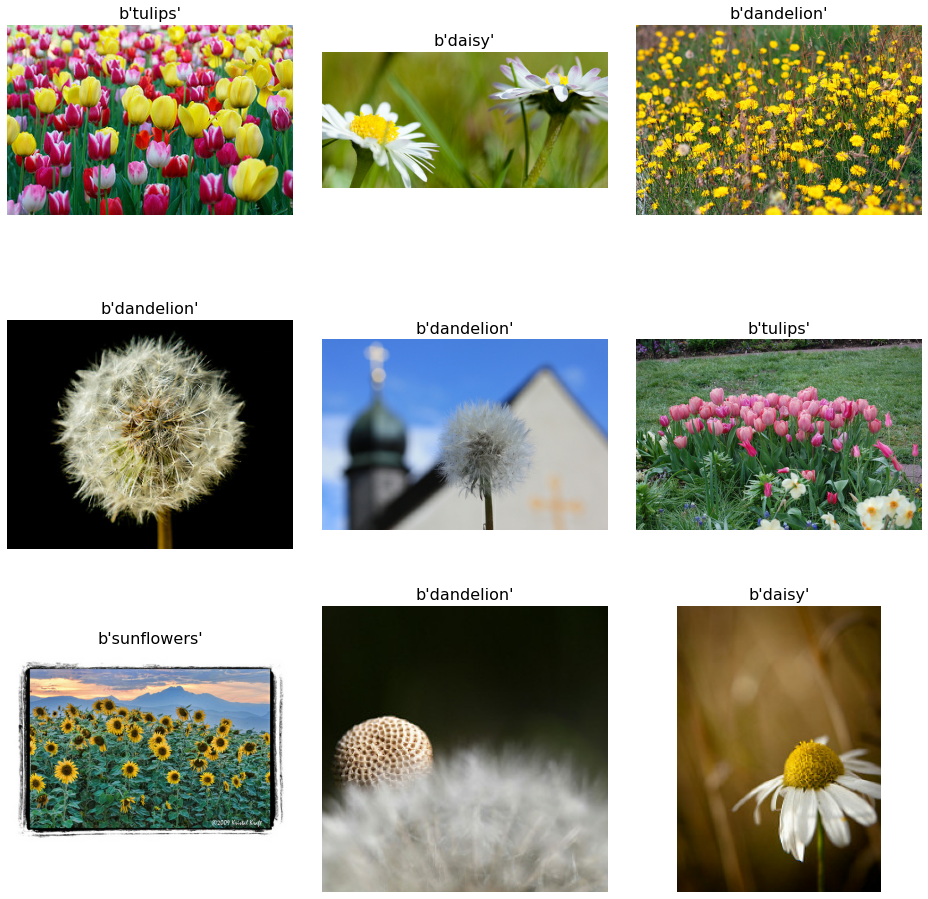

In [ ]:
display_9_images_from_dataset(dataset1)

### Resize and crop images to common size

Standard Neural Networks, like most machine learning algorithms, need **fixed size input items**. 
We achieve this here by resizing and cropping the images to a common target resolution.

In [ ]:
def resize_and_crop_image(image, label):
    # Resize and crop using "fill" algorithm:
    # always make sure the resulting image
    # is cut out from the source image so that
    # it fills the TARGET_SIZE entirely with no
    # black bars and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label
  
dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=AUTO)  

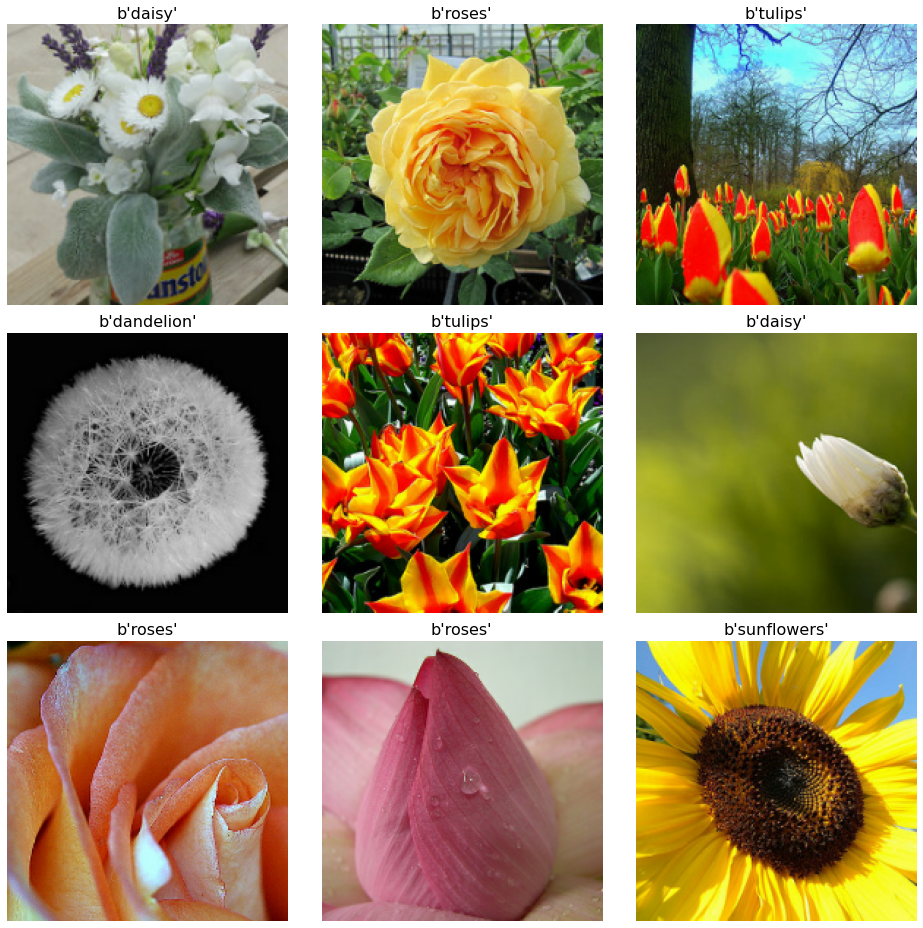

In [ ]:
display_9_images_from_dataset(dataset2)

Now test continuous reading from the dataset.

In [ ]:
batched_dataset = dataset2.batch(8)
sample_set = batched_dataset.take(20)
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape,
        [lbl.decode('utf8') for lbl in label.numpy()]))

Image batch shape (8, 192, 192, 3), ['daisy', 'tulips', 'dandelion', 'roses', 'sunflowers', 'daisy', 'roses', 'sunflowers'])
Image batch shape (8, 192, 192, 3), ['roses', 'roses', 'daisy', 'sunflowers', 'dandelion', 'daisy', 'sunflowers', 'roses'])
Image batch shape (8, 192, 192, 3), ['roses', 'tulips', 'dandelion', 'roses', 'dandelion', 'roses', 'sunflowers', 'tulips'])
Image batch shape (8, 192, 192, 3), ['daisy', 'tulips', 'dandelion', 'dandelion', 'daisy', 'daisy', 'sunflowers', 'sunflowers'])
Image batch shape (8, 192, 192, 3), ['dandelion', 'dandelion', 'tulips', 'roses', 'tulips', 'tulips', 'dandelion', 'sunflowers'])
Image batch shape (8, 192, 192, 3), ['daisy', 'tulips', 'sunflowers', 'dandelion', 'roses', 'tulips', 'sunflowers', 'roses'])
Image batch shape (8, 192, 192, 3), ['tulips', 'tulips', 'daisy', 'daisy', 'sunflowers', 'dandelion', 'tulips', 'dandelion'])
Image batch shape (8, 192, 192, 3), ['dandelion', 'tulips', 'sunflowers', 'daisy', 'sunflowers', 'tulips', 'sunflow

## Improving Speed 

Using individual image files didn't look very fast. The 'Lean and Fast Data Science' course introduced **two techniques to improve the speed**.


### Recompress the images

By **compressing** the images in the **reduced resolution** we save on the size. 
This **costs some CPU time**, but **saves network and disk bandwith**, especially when the data are **read mutliple times**. 


In [ ]:
def recompress_image(image, label):
  height = tf.shape(image)[0]
  width = tf.shape(image)[1]
  image = tf.cast(image, tf.uint8)
  image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
  return image, label, height, width

dataset3 = dataset2.map(recompress_image, num_parallel_calls=AUTO)
dataset4 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 

In [ ]:
# This is a quick test to get an idea how long recompressions takes.  
BATCH_SIZE = 8
dataset4 = dataset3.batch(BATCH_SIZE)
BATCH_NUMBER = 3 # number of batches
test_set = dataset4.take(BATCH_NUMBER)
for image, label, height, width in test_set:
    print("Image batch shape {}, {})".format(image.numpy().shape, [lbl.decode('utf8') for lbl in label.numpy()])) 

Image batch shape (8,), ['tulips', 'daisy', 'sunflowers', 'roses', 'daisy', 'roses', 'roses', 'sunflowers'])
Image batch shape (8,), ['sunflowers', 'tulips', 'sunflowers', 'sunflowers', 'sunflowers', 'tulips', 'sunflowers', 'sunflowers'])
Image batch shape (8,), ['dandelion', 'tulips', 'sunflowers', 'roses', 'dandelion', 'daisy', 'sunflowers', 'dandelion'])


### Write the dataset to TFRecord files

By writing **multiple samples into a single file**, we can make further speed gains.

There are **ready-made pre-processed data** versions available, e.g. here: 
`gs://flowers-public/tfrecords-jpeg-192x192-2/`, that we can use for comparison and later use.

First we need to **define a location** where we want to put the file. 


In [ ]:
GCS_OUTPUT = BUCKET + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names

Now we can **write the TFRecord files** to the bucket. 

Running the cell takes some time and **only needs to be done once** or not at all, as you can use the publicly available data for the next few cells. 

In [ ]:
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
  return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
  return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  

def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
  class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
  one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
  feature = {
      "image": _bytestring_feature([img_bytes]), # one image in the list
      "class": _int_feature([class_num]) #,        # one class in the list
  }
  return tf.train.Example(features=tf.train.Features(feature=feature))
  
print("Writing TFRecords")
tt0 = time.time()
filenames = tf.data.Dataset.list_files(GCS_PATTERN) 
dataset1 = filenames.map(decode_jpeg_and_label, num_parallel_calls=AUTO)
dataset2 = dataset1.map(resize_and_crop_image, num_parallel_calls=AUTO)  
dataset3 = dataset2.map(recompress_image, num_parallel_calls=AUTO)
dataset3 = dataset3.batch(shard_size) # sharding: there will be one "batch" of images per file 
for shard, (image, label, height, width) in enumerate(dataset3):
  # batch size used as shard size here
  shard_size = image.numpy().shape[0]
  # good practice to have the number of records in the filename
  filename = GCS_OUTPUT + "{:02d}-{}.tfrec".format(shard, shard_size)
  # You need to change GCS_OUTPUT to your own bucket to actually create new files  
  with tf.io.TFRecordWriter(filename) as out_file:
    for i in range(shard_size):
      example = to_tfrecord(out_file,
                            image.numpy()[i], # re-compressed image: already a byte string
                            label.numpy()[i] #, height.numpy()[i], width.numpy()[i]
                            )
      
      out_file.write(example.SerializeToString())
    print("Wrote file {} containing {} records".format(filename, shard_size))

print("Total time: "+str(time.time()-tt0))

Writing TFRecords
Wrote file gs://big-data-cw-adbr327-storage/tfrecords-jpeg-192x192-2/flowers00-230.tfrec containing 230 records
Wrote file gs://big-data-cw-adbr327-storage/tfrecords-jpeg-192x192-2/flowers01-230.tfrec containing 230 records
Wrote file gs://big-data-cw-adbr327-storage/tfrecords-jpeg-192x192-2/flowers02-230.tfrec containing 230 records
Wrote file gs://big-data-cw-adbr327-storage/tfrecords-jpeg-192x192-2/flowers03-230.tfrec containing 230 records
Wrote file gs://big-data-cw-adbr327-storage/tfrecords-jpeg-192x192-2/flowers04-230.tfrec containing 230 records
Wrote file gs://big-data-cw-adbr327-storage/tfrecords-jpeg-192x192-2/flowers05-230.tfrec containing 230 records
Wrote file gs://big-data-cw-adbr327-storage/tfrecords-jpeg-192x192-2/flowers06-230.tfrec containing 230 records
Wrote file gs://big-data-cw-adbr327-storage/tfrecords-jpeg-192x192-2/flowers07-230.tfrec containing 230 records
Wrote file gs://big-data-cw-adbr327-storage/tfrecords-jpeg-192x192-2/flowers08-230.tfr

### Test the TFRecord files

We can now **read from the TFRecord files**. By default, we use the files in the public bucket. Comment out the 1st line of the cell below to use the files written in the cell above.

In [ ]:
#GCS_OUTPUT = 'gs://flowers-public/tfrecords-jpeg-192x192-2/' # remove/change to use your own files

GCS_OUTPUT = 'gs://big-data-cw-adbr327-storage/tfrecords-jpeg-192x192-2/' # remove/change to use your own files

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple    
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

    
filenames = tf.io.gfile.glob(GCS_OUTPUT + "*.tfrec")
datasetDecoded = load_dataset(filenames)

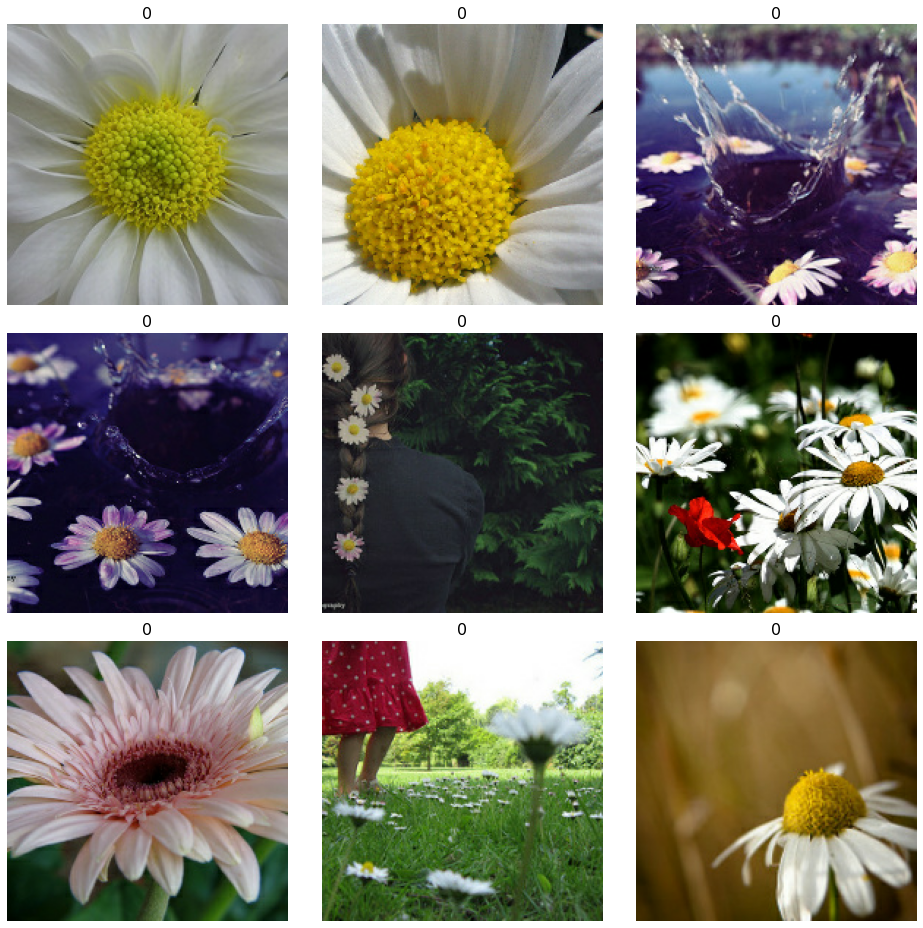

In [ ]:
display_9_images_from_dataset(datasetDecoded)

Let's have a look **if reading from the TFRecord** files is **quicker**. 

In [ ]:
batched_dataset = datasetDecoded.batch(8)
sample_set = batched_dataset.take(20)
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (8, 192, 192, 3), ['4', '0', '2', '3', '3', '3', '2', '1'])
Image batch shape (8, 192, 192, 3), ['1', '4', '4', '0', '0', '0', '4', '4'])
Image batch shape (8, 192, 192, 3), ['1', '0', '2', '4', '0', '3', '4', '0'])
Image batch shape (8, 192, 192, 3), ['3', '4', '2', '3', '3', '1', '0', '4'])
Image batch shape (8, 192, 192, 3), ['3', '3', '1', '1', '1', '3', '4', '2'])
Image batch shape (8, 192, 192, 3), ['1', '4', '3', '3', '3', '3', '3', '4'])
Image batch shape (8, 192, 192, 3), ['0', '1', '3', '4', '3', '4', '0', '4'])
Image batch shape (8, 192, 192, 3), ['2', '4', '3', '2', '0', '2', '1', '1'])
Image batch shape (8, 192, 192, 3), ['3', '0', '2', '3', '3', '1', '0', '1'])
Image batch shape (8, 192, 192, 3), ['0', '4', '4', '3', '3', '4', '0', '0'])
Image batch shape (8, 192, 192, 3), ['1', '0', '2', '3', '3', '3', '1', '3'])
Image batch shape (8, 192, 192, 3), ['4', '2', '0', '1', '3', '4', '2', '2'])
Image batch shape (8, 192, 192, 3), ['2', '2', '1', '2', '2', '0

## Task1: Cloud Speed tests (8%)

We have just seen that **reading from the pre-processed TFRecord files** is **faster** than reading individual image files and decoding on the fly. 
This task is about **understanding and quantifying this effect** better. 

### 1a): Speed test (5%)

Start by implementing **code for time measurement** to determine the **throughput in images per second**. 
Don't render the images, just print some basic information in order to **avoid measuring image rendering time**. 
It's useful to write to the null device for longer measurements (e.g. 
`print('string', \ file=open("/dev/null",mode='w')`).

Use batches ( `dataset.batch(batch_size)` ) and select a sample with (`dataset.take(batch_number)`). 
Good starting values are 8 and 10, i.e. we take 10 batches of 8 samples each. 

Use the `time.time()` to take the **time measurement** and take it multiple times, reading from the same dataset. 

**Vary** the size of the batch (`batch_size`) and the number of batches (`batch_number`) and **store the results for different values**. 
Store also the **results for each repetition** over the same dataset (repeat 2 or 3 times).

The speed test should be packaged into a **function** `time_configs()` that takes a dataset and the batch_sizes, batch_numbers, and number of repetitions as **arguments** to run a series of tests. 



In [ ]:

import pandas as pd
#from time import time

def time_configs(batch_sizes, batch_numbers, repetitions, dataset, dataset_name):
    df = pd.DataFrame(columns=['batch_size','batch_numbers','repetition','dataset_size','imgs_sec'])
    print('Start ({}):'.format(dataset_name))
    start_time = time.time()
    for batch_size_i in batch_sizes:
        for batch_number_i in batch_numbers:
            batched_dataset = dataset.batch(batch_size_i)
            sample_set = batched_dataset.take(batch_number_i)
            for repetition_i in repetitions:
                batchRepetitionSTime = time.time()                                                     #Repetition start
                for image, label in sample_set: 
                    print("Image batch shape {}, {})".format(image.numpy().shape,[str(lbl) for lbl in label.numpy()]),
                    file=open("/dev/null",mode='w'))
                batchRepetitionETime = time.time()                                                     #Repetition end
                resultsBatchRepetition = (batch_size_i*batch_number_i) / (batchRepetitionETime - batchRepetitionSTime)
                print(' Batch Size:{} , Batch Number:{}, Repetition:{} , Images(Total):{} ,' 
                ' Throughput:{:.2f} (images per second)'.format(
                    batch_size_i,batch_number_i,repetition_i, batch_size_i*batch_number_i,resultsBatchRepetition))
                # Save results in a Dataframe for later access
                df.loc[len(df.index)]=list([batch_size_i, batch_number_i, repetition_i,batch_size_i*batch_number_i, resultsBatchRepetition])

    print('End ({})\nTotal Time (seconds):{}\n\n'.format(dataset_name,time.time()-start_time))
    return df



After output to a dataframe we can print the results

**Try your function** with a **small number** of configurations of batch_sizes batch_numbers and repetions, so that we get a set of parameter combinations and corresponding reading speeds.
Try reading from the image files (dataset2) and the TFRecord files (datasetDecoded).


In [ ]:
# Testing with small numbers with dataset2 (Image Files)
# Here are some useful values for testing
batch_sizes = [4,8] #[2,4] 
batch_numbers = [4,6] #[3,6] 
repetitions = [1,2] 

train_image_df = time_configs(batch_sizes, batch_numbers, repetitions, dataset2, 'dataset_2')

train_tfrecord_df = time_configs(batch_sizes, batch_numbers, repetitions, datasetDecoded, 'TFRecord files')

Start (dataset_2):
 Batch Size:4 , Batch Number:4, Repetition:1 , Images(Total):16 , Throughput:8.95 (images per second)
 Batch Size:4 , Batch Number:4, Repetition:2 , Images(Total):16 , Throughput:7.40 (images per second)
 Batch Size:4 , Batch Number:6, Repetition:1 , Images(Total):24 , Throughput:8.27 (images per second)
 Batch Size:4 , Batch Number:6, Repetition:2 , Images(Total):24 , Throughput:8.24 (images per second)
 Batch Size:8 , Batch Number:4, Repetition:1 , Images(Total):32 , Throughput:7.62 (images per second)
 Batch Size:8 , Batch Number:4, Repetition:2 , Images(Total):32 , Throughput:8.00 (images per second)
 Batch Size:8 , Batch Number:6, Repetition:1 , Images(Total):48 , Throughput:8.41 (images per second)
 Batch Size:8 , Batch Number:6, Repetition:2 , Images(Total):48 , Throughput:9.11 (images per second)
End (dataset_2)
Total Time (seconds):28.970288515090942


Start (TFRecord files):
 Batch Size:4 , Batch Number:4, Repetition:1 , Images(Total):16 , Throughput:22.95 

### 1b) Speed test analysis (3%)

Do a linear regression over reading speed as a function of parameters. Look at the parameters `batch_size`, `batch_number`, `repetition` and the dataset size (`batch_size * batch_number`). 

Print the regression results (slope, intercept, pvalue etc) and plot the measurements and the regression line for each of the 4 parameters. 


In [ ]:
### CODING TASK ###

batch_sizes = [4,8,16,32,64] 
batch_numbers = [5,8,12,15,20,25]
repetitions = [1,2,3] 

batch_sizes = "4 8 16 32 64"
batch_numbers = "5 8 12 15 20 25"

# Reading from the image files (dataset2)
image_df = time_configs(batch_sizes, batch_numbers, repetitions, dataset2, 'Image files')

# Reading from the TFRecord files (datasetDecoded)
tfrecord_df = time_configs(batch_sizes, batch_numbers, repetitions, datasetDecoded, 'TFRecord files')

Start (Image files):
 Batch Size:4 , Batch Number:5, Repetition:1 , Images(Total):20 , Throughput:8.87 (images per second)
 Batch Size:4 , Batch Number:5, Repetition:2 , Images(Total):20 , Throughput:9.61 (images per second)
 Batch Size:4 , Batch Number:5, Repetition:3 , Images(Total):20 , Throughput:8.95 (images per second)
 Batch Size:4 , Batch Number:10, Repetition:1 , Images(Total):40 , Throughput:10.15 (images per second)
 Batch Size:4 , Batch Number:10, Repetition:2 , Images(Total):40 , Throughput:9.96 (images per second)
 Batch Size:4 , Batch Number:10, Repetition:3 , Images(Total):40 , Throughput:9.28 (images per second)
 Batch Size:4 , Batch Number:12, Repetition:1 , Images(Total):48 , Throughput:10.03 (images per second)
 Batch Size:4 , Batch Number:12, Repetition:2 , Images(Total):48 , Throughput:11.20 (images per second)
 Batch Size:4 , Batch Number:12, Repetition:3 , Images(Total):48 , Throughput:9.63 (images per second)
 Batch Size:4 , Batch Number:15, Repetition:1 , Imag

In [ ]:
### CODING TASK ###

# Import Linear Regression libraries
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns
from scipy import stats
import numpy as np

def linear_regression(image_frame,tfrecord_frame):
    
    # Create a dictionary to iterate over the 2 datasets
    dict_dataframes = {'Image File': image_frame, 'TFRecord': tfrecord_frame}

    fig, axes = plt.subplots(2,4,figsize=(30,14))
    row = 1
    for df_name, df in dict_dataframes.items():
        
        
        train_df = df.copy()

        X = np.array(train_df[train_df.columns[:-1]]) 
        y = np.array(train_df[train_df.columns[-1]])

        # Print all statistics
        # print(results.summary())

        #plt.subplots(figsize=(16, 8))  
        count=1

        for attributeIndex in range (0, X.shape[1]):
            #print(row)
            #plt.subplot(row,4,count)
            X = np.array(train_df.iloc[:, [attributeIndex]])
            y = np.array(train_df[train_df.columns[-1]])
            
            
            slope, intercept, r_value, p_value, std_err = stats.linregress(X[:,0],y.reshape(-1,1)[:,0])

            # reg = lr.fit(X, y)
            # Y_pred = lr.predict(X)
            # #print('Prediction:',Y_pred) 
            # slope_model = reg.coef_
            # coef_model = reg.intercept_ 

            Y_pred = slope*train_df[train_df.columns[attributeIndex]] + intercept
            sns.scatterplot(
                x=train_df[train_df.columns[attributeIndex]],
                y=train_df[train_df.columns[-1]], color='blue',ax=axes[row-1][count-1])
            
            sns.lineplot(
                x=train_df[train_df.columns[attributeIndex]],
                y=Y_pred, color='red',ax=axes[row-1][count-1])
            
            axes[row-1][count-1].xaxis.get_label().set_fontsize(14)
            axes[row-1][count-1].yaxis.get_label().set_fontsize(14)
            
            axes[row-1][count-1].tick_params(axis='x', labelsize=14)
            axes[row-1][count-1].tick_params(axis='y', labelsize=14)
            #axes[row-1][count-1].set_xticklabels(labels=train_df[train_df.columns[attributeIndex]],fontsize=16)
            #axes[row-1][count-1].set_yticklabels(labels=train_df[train_df.columns[-1]],fontsize=16)

            # Set lin_formula = slope_model[0]*X[:,0] + coef_model
            axes[row-1][count-1].set_title(str(df_name) + '\n' + 'y=' + str(np.round(slope,3)) +
                      ' x ' + str(train_df.columns[attributeIndex]) + '+' + str(np.round(intercept,3)) + 
                      ' | P-Value:' + str(np.round(p_value,3)) +  ' | r2-Score:' + str(np.round(r_value,3)),
                      fontdict={'fontsize': 14})
            axes[row-1][count-1].grid(True)

            count+=1

        row = row + 1

    #fig.patch.set_facecolor('w')
    #plt.grid(True)
    plt.tight_layout(pad=6)
    plt.suptitle('Image File vs TFRecord (Speed test analysis)', fontsize=16)
    plt.show()


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


**Now we call the function to plot the linear regression over the Images and TFRecord files.**

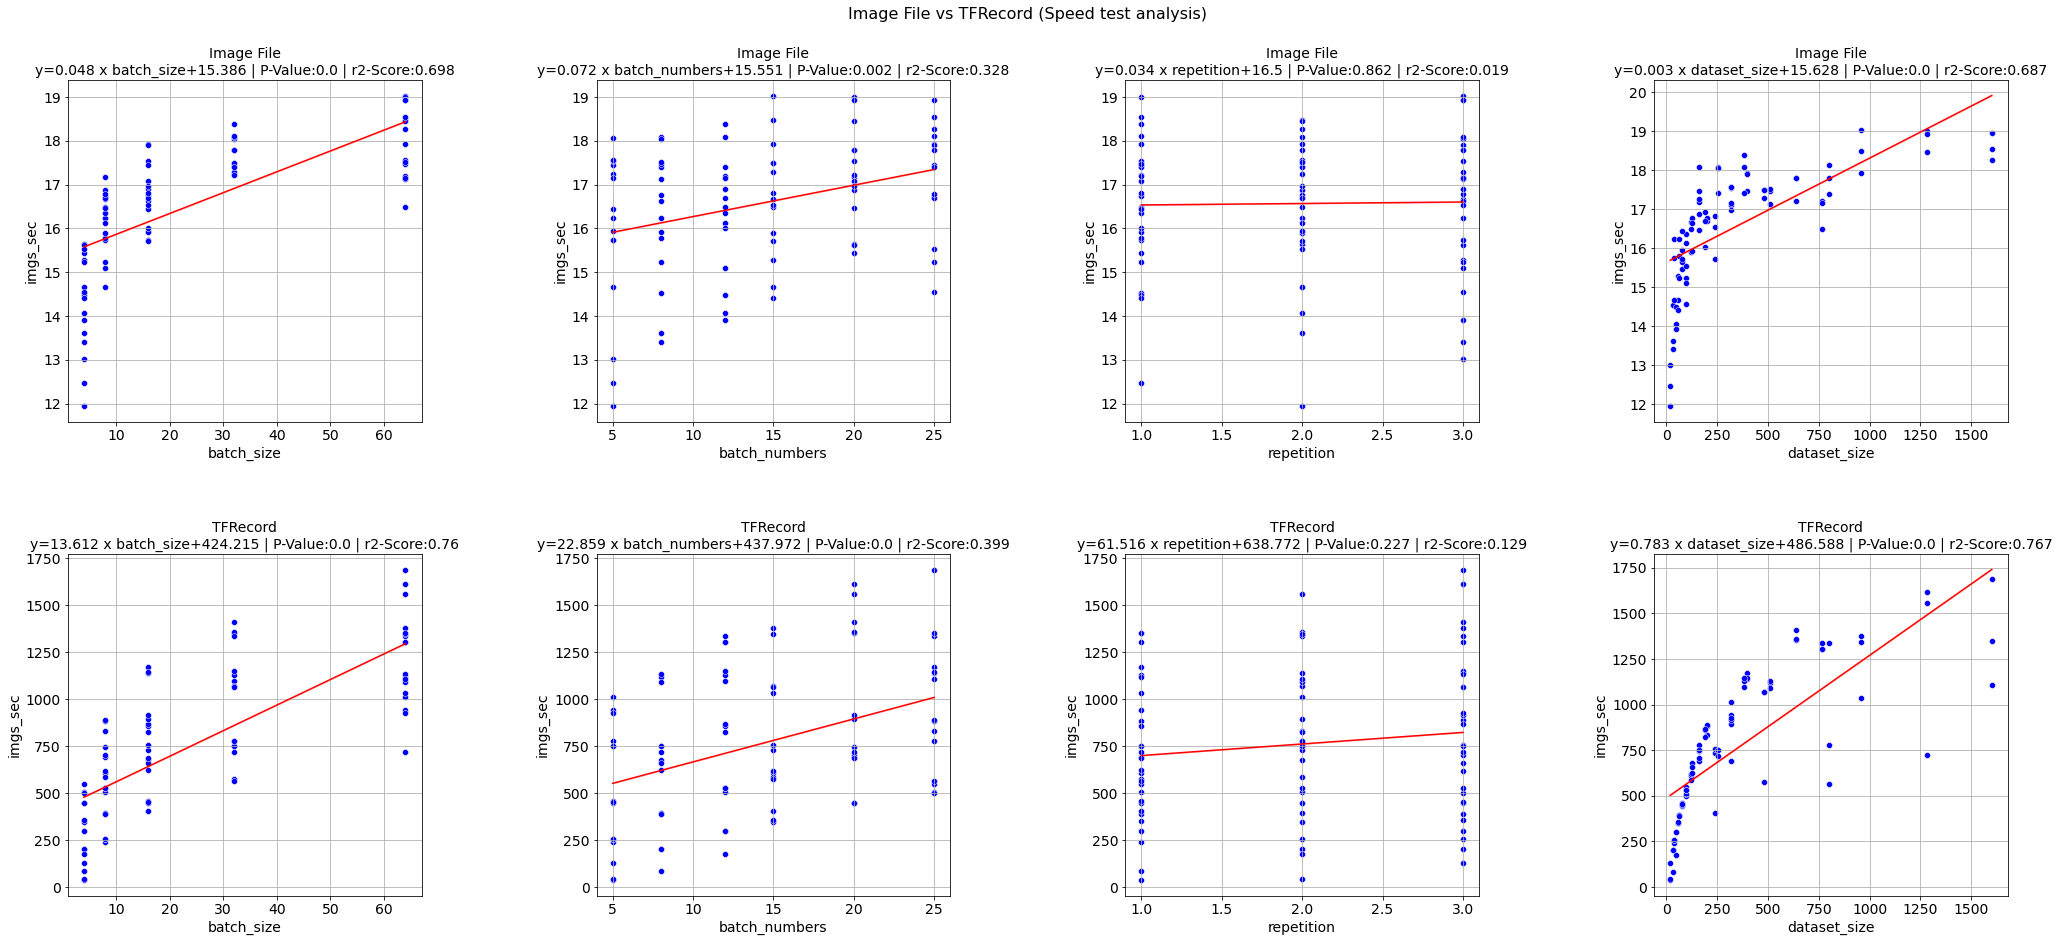

In [ ]:
linear_regression(image_df,tfrecord_df)

## Task 2: Parallelising the speed test with Spark in the cloud. (32%)

As an exercise in **Spark programming and optimisation** as well as **performance analysis**, we will now implement the **speed test** with multiple parameters in parallel with Spark. 
Runing mutliple tests in parallel would **not be a useful approach on a single machine, but it can be in the cloud** (you will be asked to reason about this later). 


### Preparation: Running Spark in the cloud 

In order to test multiple configurations in parallel we will use Spark on GCS DataProc. 

You may need to enable the DataProc API on the [console DataProc page](https://console.cloud.google.com/dataproc/clusters/), if you have not done so, yet.  

First we need to spin up a cluster that runs Spark. We start with a single machine, just to try it out. 

We are using the `gcloud dataproc clusters` command. [Click here for documentation](https://cloud.google.com/sdk/gcloud/reference/dataproc/clusters). The `--image-version 1.4-ubuntu18` makes sure we get current software. 

Starting a cluster can take a few minutes. You can wait for the cell to finish processing or interrupt its execution and check on the [console DataProc page](https://console.cloud.google.com/dataproc/clusters/) if the cluster is ready.



In [ ]:
CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 --single-node \
    --master-machine-type n1-standard-2 \
    --master-boot-disk-type pd-ssd --master-boot-disk-size 100 \
    --max-idle 3600s 

Waiting on operation [projects/big-data-cw-adbr327-304523/regions/us-central1/operations/4cdd9457-1292-36ae-9591-60a66fecaa64].
Created [https://dataproc.googleapis.com/v1/projects/big-data-cw-adbr327-304523/regions/us-central1/clusters/big-data-cw-adbr327-304523-cluster] Cluster placed in zone [us-central1-f].


The `--max-idle 3600s` flag means that the cluster will be **deleted automatically** once it has been **idle for 1 hour**. This helps avoid cost for a cluster left running by accident. 

This is a single-node cluster. This is created a bit more quickly than a multi-node cluster, but set-up is still quite slow (several minutes) because of the **restrictions on the free tier**. 
You **can switch to paid tier** and still use your free credit, but then you **may use up your free credit more quickly** and have to **pay for usage**.
If you stay in the free tier Google promises not to charge you. The free tier resources are sufficient for this coursework, if you use the local spark installation for testing and set paramters with care. All the development of this coursework was done with a free tier account. 

We have not specified the region (we could have used `--region $REGION`) as we set already the default for dataproc in the beginning. 

You can run the **command below to get extensive information** about your running cluster. 
However, it is usually **more practical** to look at the [console DataProc page](https://console.cloud.google.com/dataproc/clusters/). 
You can check the details and current state of your cluster by clicking on its name. 
Double-check there at the end of your working session to make sure that no clusters are left running, especially when you are not in free mode any more. 

In [ ]:
!gcloud dataproc clusters describe $CLUSTER 

clusterName: big-data-cw-adbr327-304523-cluster
clusterUuid: 028baeb0-1175-454e-bfcd-cea9351168da
config:
  configBucket: dataproc-staging-us-central1-416265621505-ttjizxoz
  endpointConfig: {}
  gceClusterConfig:
    networkUri: https://www.googleapis.com/compute/v1/projects/big-data-cw-adbr327-304523/global/networks/default
    serviceAccountScopes:
    - https://www.googleapis.com/auth/bigquery
    - https://www.googleapis.com/auth/bigtable.admin.table
    - https://www.googleapis.com/auth/bigtable.data
    - https://www.googleapis.com/auth/cloud.useraccounts.readonly
    - https://www.googleapis.com/auth/devstorage.full_control
    - https://www.googleapis.com/auth/devstorage.read_write
    - https://www.googleapis.com/auth/logging.write
    zoneUri: https://www.googleapis.com/compute/v1/projects/big-data-cw-adbr327-304523/zones/us-central1-f
  lifecycleConfig:
    idleDeleteTtl: 3600s
    idleStartTime: '2021-03-20T11:37:12.931Z'
  masterConfig:
    diskConfig:
      bootDiskSizeG

Now that our cluster is running, we can submit a Spark job. A minimal Spark job is just a Python script. A simple "Hello World" Spark script is provided in a public cloud bucket. Let's have a look at it:

In [ ]:
!gsutil cat gs://dataproc-examples/pyspark/hello-world/hello-world.py 

#!/usr/bin/python
import pyspark
sc = pyspark.SparkContext()
rdd = sc.parallelize(['Hello,', 'world!'])
words = sorted(rdd.collect())
print(words)



... and run it on the cluster. We submit the job with the `gcloud dataproc jobs` command ([click here for the documentation](https://cloud.google.com/sdk/gcloud/reference/dataproc/jobs)) with the cluster name.


In [ ]:
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER \
    gs://dataproc-examples/pyspark/hello-world/hello-world.py 

Job [f9a6544dc2a8465da77d85fc1351aee8] submitted.
Waiting for job output...
21/03/20 11:42:03 INFO org.spark_project.jetty.util.log: Logging initialized @5136ms
21/03/20 11:42:04 INFO org.spark_project.jetty.server.Server: jetty-9.3.z-SNAPSHOT, build timestamp: unknown, git hash: unknown
21/03/20 11:42:04 INFO org.spark_project.jetty.server.Server: Started @5321ms
21/03/20 11:42:04 INFO org.spark_project.jetty.server.AbstractConnector: Started ServerConnector@4bd853e5{HTTP/1.1,[http/1.1]}{0.0.0.0:4040}
21/03/20 11:42:04 WARN org.apache.spark.scheduler.FairSchedulableBuilder: Fair Scheduler configuration file not found so jobs will be scheduled in FIFO order. To use fair scheduling, configure pools in fairscheduler.xml or set spark.scheduler.allocation.file to a file that contains the configuration.
21/03/20 11:42:06 INFO org.apache.hadoop.yarn.client.RMProxy: Connecting to ResourceManager at big-data-cw-adbr327-304523-cluster-m/10.128.15.202:8032
21/03/20 11:42:06 INFO org.apache.hadoo

The `trackingUrl` shown above will only work as long as the job is running. On to the [dataproc page](https://console.cloud.google.com/dataproc/clusters/), you can click through to your cluster page and from there to your job page to see details on past jobs.

You may get some warnings like this: 
`WARN org.apache.spark.scheduler.FairSchedulableBuilder: Fair' ...
or this one:
`WARN org.apache.hadoop.hdfs.DataStreamer: Caught exception`. There was not enough time to research these fully but they don't affect what we do here and can be ignored. 

One issue is that we need to **get output data from the cluster back to the notebook**. We can output text through printing into the output stream, but that does not work well for scaling up, for automation or for binary data. 

A better solution is to **pass an argument** to the job, to tell the job on the cluster **where to write the output**. 
This requires a bit of extra code as shown below using the argparse package.
The example below the checks if the script runs in Colab and if that is the case, it does not execute the run function. 
This is useful for quick testing with a local spark instance.

For running the file in DataProc, write to a local file `hello-world.py`, uncomment the  the `%%writefile` magic as in the cell below.


In [ ]:
%%writefile hello-world.py

import sys
import pyspark
import argparse
import pickle 

def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

def runWordCount(argv):
    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) # read the value
    # the value provided with --out_bucket is now in args.out_bucket
    sc = pyspark.SparkContext.getOrCreate()
    rdd = sc.parallelize(['Hello,', 'world!'])
    words = sorted(rdd.collect())
    save(words,args.out_bucket,args.out_file)

if  'google.colab' not in sys.modules: # Don't use system arguments run in Colab 
    runWordCount(sys.argv[1:])  
elif __name__ == "__main__" : # but define them manually
    runWordCount(["--out_bucket", BUCKET, "--out_file", "words.pkl"])

Overwriting hello-world.py


In [ ]:
%run -i ./hello-world.py "--out_bucket" BUCKET "--out_file" FILENAME

['--out_bucket', 'gs://big-data-cw-adbr327-304523-storage', '--out_file', 'words.pkl']
Saving words.pkl to gs://big-data-cw-adbr327-304523-storage
gstuil returned: 0
b'Copying file://words.pkl [Content-Type=application/octet-stream]...\n/ [0 files][    0.0 B/   34.0 B]                                                \r/ [1 files][   34.0 B/   34.0 B]                                                \r\nOperation completed over 1 objects/34.0 B.                                       \n'


In [ ]:
BUCKET

'gs://big-data-cw-adbr327-304523-storage'

**Once the code works as intended**, you can write it to the local disk (on your Colab instance). For this, **uncomment the first line with the `%%writefile` magic** and then **re-run the cell**. 

Then **check** that the file **is in the current directory** and **has the right contents** like this:

In [ ]:
!pwd
!ls -l hello-world.py
!cat hello-world.py

/content
-rw-r--r-- 1 root root 1401 Mar 12 02:42 hello-world.py

import sys
import pyspark
import argparse
import pickle 

def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

def runWordCount(argv):
    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    args = parser.parse_args(argv) # read the value
    # the value 

We can now submit the job with an extra section for application arguments. It's started by `--`, which indicates that all following arguments are to be sent to our Spark application. 

In [ ]:
FILENAME = 'words.pkl'
!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./hello-world.py \
    -- --out_bucket $BUCKET --out_file $FILENAME

Job [821a8cbaac3f42f885261fe23363f5a7] submitted.
Waiting for job output...
['--out_bucket', 'gs://big-data-cw-adbr327-304523-storage', '--out_file', 'words.pkl']
21/03/13 15:07:16 INFO org.spark_project.jetty.util.log: Logging initialized @4467ms
21/03/13 15:07:17 INFO org.spark_project.jetty.server.Server: jetty-9.3.z-SNAPSHOT, build timestamp: unknown, git hash: unknown
21/03/13 15:07:17 INFO org.spark_project.jetty.server.Server: Started @4600ms
21/03/13 15:07:17 INFO org.spark_project.jetty.server.AbstractConnector: Started ServerConnector@54d9f34d{HTTP/1.1,[http/1.1]}{0.0.0.0:4040}
21/03/13 15:07:17 WARN org.apache.spark.scheduler.FairSchedulableBuilder: Fair Scheduler configuration file not found so jobs will be scheduled in FIFO order. To use fair scheduling, configure pools in fairscheduler.xml or set spark.scheduler.allocation.file to a file that contains the configuration.
21/03/13 15:07:18 INFO org.apache.hadoop.yarn.client.RMProxy: Connecting to ResourceManager at big-data

Once the job has finished, we can **use the output** by **copying it from the bucket** and **reading it as a local file**.

In [ ]:
# Make sure you are writing to the right directory
%cd /content/drive/MyDrive/BD-CW
!gsutil cp $BUCKET/$FILENAME . 
!ls -l
with open(FILENAME,mode='rb') as f:
    words = pickle.load(f) 

print("Content of {} : {}".format(FILENAME,words))

/content/drive/MyDrive/BD-CW
Copying gs://big-data-cw-adbr327-304523-storage/words.pkl...
/ [1 files][   34.0 B/   34.0 B]                                                
Operation completed over 1 objects/34.0 B.                                       
total 12301
-r-------- 1 root root 7127030 Mar  5 11:29 'BD-CW Data preprocessing and ML training v13 - Questions (1).ipynb'
-rw------- 1 root root 5462347 Mar 12 02:44 'BD-CW Data preprocessing and ML training v13 - Questions.ipynb'
drwx------ 2 root root    4096 Mar 11 17:35  data
-rw------- 1 root root    1401 Mar  8 02:36  hello-world.py
-rw------- 1 root root      34 Mar 12 02:47  words.pkl
Content of words.pkl : ['Hello,', 'world!']


At the end of a session we should **delete the cluster**, as it incurs a **cost for the time** it runs.  

In [ ]:
!gcloud dataproc clusters delete $CLUSTER -q 
# the -q flag disables the confirmation prompt 
# , we want to make sure it really gets deleted

Waiting on operation [projects/big-data-cw-adbr327-304523/regions/us-central1/operations/43f49f43-8e3c-3e3e-96d2-acbe5df9c59c].
Deleted [https://dataproc.googleapis.com/v1/projects/big-data-cw-adbr327-304523/regions/us-central1/clusters/big-data-cw-adbr327-304523-cluster].


### 2a) Create the script (12%)
Your task is now to **port the speed test to Spark** for running it in the cloud in DataProc. 
**Adapt the preprocessing code** as a Spark programm that performs the same actions as above, but **with Spark RDDs in a distributed way**. 
The distribution should be such that **each parameter combination (except repetition)** is processed in a separate Spark task.

More specifically: 
*   i) combine the previous cells to have the code to create a dataset and create a list of parameter combinations in an RDD (2%)
*   ii) get a spark context and  create the dataset and run timing test for each combination in parallel (2%)
*   iii) transform the resulting RDD to the structure \( parameter_combination, images_per_second \) and save these values in an array (2%)
*   iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter  (1%)
*   v) create an RDD with the average reading speeds for each parameter value and collect the results. Keep associativity in mind when implementing the average. (3%) 
*   vi) write the results to a pickle file in your bucket (1%)
*   vii) Write your code it into a file using the *cell magic* `%%writefile spark_job.py` (1%)


**Important:** The task here is not to parallelize the pre-processing, but to run multiple speed tests in parallel using Spark.


In [8]:
# vii) Write your code it into a file using the cell magic %%writefile spark_job.py (1%)
%%writefile spark_job.py

import time
import sys
import pyspark
import argparse
import pickle 
import tensorflow as tf
from operator import add

SHARDS = 16 # shards are partitiones into shards
TARGET_SIZE = [192, 192] # the resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = 'gs://big-data-cw-adbr327-storage' + '/tfrecords-jpeg-192x192-2/flowers'  # prefix for output file names


def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gsuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

def decode_jpeg_and_label(filepath):
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image(image, label):
    # Resize and crop using "fill" algorithm:
    # always make sure the resulting image
    # is cut out from the source image so that
    # it fills the TARGET_SIZE entirely with no
    # black bars and a preserved aspect ratio.
    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label


def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord)
    return dataset

def create_dataset2(gcs_pattern):
    #AUTO = tf.data.experimental.AUTOTUNE
    filepathDS = tf.data.Dataset.list_files(gcs_pattern) # This also shuffles the images
    dataset1 = filepathDS.map(decode_jpeg_and_label)
    dataset2 = dataset1.map(resize_and_crop_image)
    return dataset2

def create_datasetDecoded(gcs_output):
    filenames = tf.io.gfile.glob(gcs_output + "*.tfrec")
    datasetDecoded = load_dataset(filenames)
    return datasetDecoded

def time_configs_2a(par_combination):
    
    # Split parameter combination input into separate variables
    [batch_size, batch_number, repetitions] = par_combination

    # Create both datasets (Image/TFRecord)
    dataset2 = create_dataset2(GCS_PATTERN)
    datasetDecoded = create_datasetDecoded(GCS_OUTPUT)
    parOutput = []

    # Read from Image File  
    batched_dataset = dataset2.batch(batch_size)
    sample_set = batched_dataset.take(batch_number)
    for repetition_i in range(repetitions):
        batchRepetitionSTime = time.time() 
        for image, label in sample_set: 
            print('string', file=open("/dev/null",mode='w'))
            print('Batch size:{} batch number:{}, repetition:{}'.format(batch_size,batch_number,repetition_i+1))
        batchRepetitionETime = time.time() 
        repetitionTime = (batch_size*batch_number) / (batchRepetitionETime - batchRepetitionSTime)
        parOutput.append([[batch_size, batch_number, batch_size * batch_number, repetition_i+1,0], repetitionTime])

    # Read from TFRecord File
    batched_dataset = datasetDecoded.batch(batch_size)
    sample_set = batched_dataset.take(batch_number)
    for repetition_i in range(repetitions):
        batchRepetitionSTime = time.time() 
        for image, label in sample_set: 
            print('string', file=open("/dev/null",mode='w'))
            print('Batch size:{} batch number:{}, repetition:{}'.format(batch_size,batch_number,repetition_i+1))
        batchRepetitionETime = time.time() 
        repetitionTime = (batch_size*batch_number) / (batchRepetitionETime - batchRepetitionSTime)
        parOutput.append([[batch_size, batch_number, batch_size * batch_number, repetition_i+1, 1], repetitionTime])
    return (parOutput) 

def mapParamKey(pc_i): # we get a nested tuple
    (ftype,pname,pval),(ips) = pc_i # split the outer tuple    
    return ((ftype,pname),[(pval,ips)])

def reGrpLst(pc_i): # we get a nested tuple
    [parComb, ips] = pc_i # split the outer tuple    
    [bs, bn, ds, rep, ftype] = parComb # split the inner tuple
    return ([ftype, [('batch size',(bs,ips)),
                    ('batch number',(bn,ips)),
                    ('set size',(ds,ips)),
                    ('repetition',(rep,ips))]])

def task2a(argv):  
    '''argv is composed by the following parameters:
        out_bucket
        out_file
        batch_sizes
        batch_numbers
        repetitions
        cache_flag
        parallelize_flag
    '''

    # We will create a list of batch_sizes and batch_number parameters into an RDD
    # We define the below values for testing
    # batch_sizes = [4,6]  
    # batch_numbers = [8,10] 
    # repetitions = [1,2]

    #Parse the provided arguments
    #print(argv)
    # We will import lists of batch_sizes, batch_numbers and repetitions as parameters into an RDD
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    parser.add_argument('--batch_sizes', metavar='batch_sizes', nargs="+", required=True,
                        help='The batch_size for the result.') # add a required argument
    parser.add_argument('--batch_numbers', metavar='batch_numbers', nargs="+", required=True,
                        help='The batch_number for the result.') # add a required argument
    parser.add_argument('--repetitions', metavar='repetitions', nargs="+", required=True,
                        help='The repetitions for the result.') # add a required argument  
    parser.add_argument('--cache_flag', metavar='cache_flag', required=True,
                        help='The flag for implementation of cache.') 
    parser.add_argument('--parallelize_flag', metavar='parallelize_flag', required=True,
                        help='The flag for implementation of parallelization.') 

    args = parser.parse_args(argv) # read the value
    # the value provided with --out_bucket is now in args.out_bucket
    
    #print(args.batch_sizes)
    #print(list(args.batch_sizes),' - ',list(args.batch_numbers))
    
    # i) combine the previous cells to have the code to create a dataset ...
    par_combination = []
    for batch_size in list(args.batch_sizes):
        for batch_number in list(args.batch_numbers):
            par_combination.append([int(float(batch_size)), int(float(batch_number)), len(args.repetitions)])

    #print('par_combination',par_combination)

    # i) and create a list of parameter combinations in an RDD (2%)
    # We disabled to use 
    # parametersCombination_RDD = sc.parallelize(par_combination)

    # ii) get a spark context and create the dataset and run timing test for each combination in parallel (2%)
    sc = pyspark.SparkContext.getOrCreate()
    print(sc)

    if args.parallelize_flag == "True":
    ### TASK 2cii ###
    # We changed the number of partitions from the default implicit parameter of 2 to "dataset size" partitions \
    # (second argument of parallelize).
        parametersCombination_RDD = sc.parallelize(par_combination, len(par_combination))
        print("Parallelization enabled")
    elif args.parallelize_flag.isdigit():   
        parametersCombination_RDD = sc.parallelize(par_combination, int(args.parallelize_flag))
        print("Parallelization enabled:",int(args.parallelize_flag),"partitions")
    # Repetition should not be part of spark task so we need to break each parametersCombinationRDD RDD in repetitions number of RDDs.
    elif args.parallelize_flag == "False":
        parametersCombination_RDD = sc.parallelize(par_combination)

    # iii) Transform the resulting RDD to the structure ( parameter_combination, images_per_second ) 
    # and save these values in an array (2%)
    parCombTime_RDD = parametersCombination_RDD.flatMap(time_configs_2a)

    # Default implementation
    # parametersCombinationRDD = sc.parallelize([(bs,bn) for bs in batch_sizes for bn in batch_number])

    ### TASK 2Ci ###   
    # We implement cache of the RDD
    if args.cache_flag == "True":
        parCombTime_RDD.cache()
        print("Cache enabled")

    # Test with 5 samples from RDD
    #print(parCombTime_RDD.take(5))

    zeroValue = [] # empty list is 'zero value' for append operation
    mergeVal = (lambda aggregated, el: aggregated + (el))
    mergeComb = (lambda agg1,agg2: agg1 + agg2)

    parVal_RDD = parCombTime_RDD.map(reGrpLst) # apply reGrpLst
    parValTime_RDD = parVal_RDD.aggregateByKey(zeroValue,mergeVal,mergeComb)

    parValTotal_RDD = parValTime_RDD.flatMap(lambda x : [ ((x[0],y[0],y[1][0]), y[1][1]) for y in x[1]])


    # iv) create an RDD with all results for each parameter as (parameter_value,images_per_second) and collect the result for each parameter (1%)  
    # Calculate the Original RDD with the same structure as the Average RDD
    # parValOriginal_RDD = parValTotal_RDD.map(lambda x: (x[0], x[1])) \
    #                                .reduceByKey(add)
    #mergeVal = (lambda aggregated, el: aggregated + [(el)])
    parValOriginal_RDD = parValTotal_RDD.sortByKey() \
                                .map(lambda x: [(x[0][0],x[0][1]), [((x[0][2],x[1])) ]] ) \
                                .reduceByKey(lambda a,b : (a+b)).sortByKey() \
                                .map(lambda x: [x[0][0], {x[0][1]: (x[1])}] ).reduceByKey(lambda x, y: {**x, **y})
                                #.map(lambda x: (x[0][0], [((x[0][1], (x[1])))])).reduceByKey(add)
                                
    # Sort RDD over all the partitions
    #parValOriginal_RDD = parValOriginal_RDD.sortByKey(numPartitions=parValOriginal_RDD.getNumPartitions())                           


    # v) create an RDD with the average reading speeds for each parameter value and collect the results. 
    # Keep associativity in mind when implementing the average. (3%)
    # Calculate the Average RDD
    countsByKey = sc.broadcast(parValTotal_RDD.countByKey())
    mergeVal = (lambda aggregated, el: aggregated + (el))
    mergeComb = (lambda agg1,agg2: agg1 + agg2)

    #print(parValTotal_RDD.collect())

    parValAvg_RDD = parValTotal_RDD.map(lambda x: (x[0], x[1]/countsByKey.value[x[0]])) \
                    .reduceByKey(add).map(mapParamKey) \
                    .reduceByKey(lambda a,b : sorted(a+b, key=lambda x: x[0]))

    parValAvg_RDD = parValAvg_RDD.map(lambda x: [x[0][0], {x[0][1]: (x[1]) }]) \
                    .reduceByKey(lambda x, y: {**x, **y})

    # parValAvg_RDD = parValAvg_RDD.map(mapParamKey) \
    #                 .reduceByKey(lambda a,b : sorted(a+b, key=lambda x: x[0] )).sortByKey() \
    #                 .map(lambda x: [x[0][0], [(x[0][1], (x[1]))]]) \
    #                 .reduceByKey(add)

    # vi) write the results to a pickle file in your bucket (1%)
    combOutput = [sorted(parValOriginal_RDD.collect()), sorted(parValAvg_RDD.collect())]
    # print(combOutput)
    # Pass arguments to save function to write results to pickle file.
    save(combOutput,args.out_bucket,args.out_file)


if  'google.colab' not in sys.modules: # Don't use system arguments run in Colab 
    task2a(sys.argv[1:])  
elif __name__ == "__main__" : # but define them manually
    task2a(["--out_bucket", BUCKET, "--out_file", "spark_job.pkl","--batch_sizes",batch_sizes,
            "--batch_numbers",batch_numbers,"--repetitions",repetitions,
            "--cache_flag",False,"--parallelize_flag",False])

Writing spark_job.py


**Now that the file is already (using the magic %%writefile command), we run the spark_job.py file locally with smaller parameter values in order to validate the script before submitting to the cluster**

In [ ]:
FILENAME = 'spark_job_output2.pkl'

batch_sizes = "2 4"  
batch_numbers = "3 4"  
repetitions = "1 2"
cache_flag = "True"
parallelize_flag = "True"

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./spark_job2.py \
    -- --out_bucket $BUCKET --out_file $FILENAME \
    --batch_sizes $batch_sizes --batch_numbers $batch_numbers --repetitions $repetitions \
    --cache_flag $cache_flag --parallelize_flag $parallelize_flag

Job [dce4b221ef66436c891ffa78c245bcdc] submitted.
Waiting for job output...
2021-04-18 20:12:40.402362: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-18 20:12:40.402663: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-18 20:12:40.402698: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
21/04/18 20:12:43 INFO org.spark_project.jetty.util.log: Logging initialized @9054ms
21/04/18 20:12:43 INFO org.s

In [9]:
FILENAME = 'spark_job_output.pkl'

batch_sizes = "2 4"  
batch_numbers = "3 4"  
repetitions = "1 2"
cache_flag = "True"
parallelize_flag = "True"

%run -i ./spark_job.py -- --out_bucket BUCKET --out_file FILENAME \
                            --batch_sizes batch_sizes --batch_numbers batch_numbers --repetitions repetitions \
                            --cache_flag cache_flag --parallelize_flag parallelize_flag

After the manual test we can inspect the generated output file ('spark_job_output.pkl') in google drive folder.

---




### 2b) Set up a cluster and run the script. (4%)

In the free credit tier on Google Cloud, there are the following **restrictions**:
- max 100GB of *SSD persistent disk*
- max 2000GB of *standard persisten disk* 
- max 8 *vCPU*s

See [here](https://cloud.google.com/free/docs/gcp-free-tier#free-trial) for details 
The disks are virtual disks, where the I/O speed is limited in proportion to the size, so that we should allocated them evenly.
This has mainly an effect on the time the cluster needs to start, as we are reading the data mainly from the bucket and we are not writing much to disk at all.   

The largest possible cluster within these constraints has 1 master and 7 worker nodes. 
Each of them with 1 (virtual) CPU. The master should get the full *SSD* capacity and the 7 worker nodes should get equal shares of the *standard* disk capacity to maximise throughput. 

In order to run our code on the cluster, we need to **make sure** that **TensorFlow 2 is installed**. The Colab magic  `%tensorflow_version 2.x` will not work within Spark. 
Instead, enable package installation by passing a flag `--initialization-actions` with argument `gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh` (this is a public script that will read metadata to determine which packages to install). 
The packages are then specified by providing a `--metadata` flag with the argument `PIP_PACKAGES=tensorflow=2.1.0`. 
(2%)

In [ ]:
!gcloud compute project-info describe --project $PROJECT

**Setting up a cluster**

In [10]:
### CODING TASK ###

import math

worker_nodes = 7
# Calculate the size for each worker node
worker_disk_size = str(int(math.floor(2000/worker_nodes))) + 'GB'
#print(worker_disk_size)

CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 \
    --master-machine-type n1-standard-1 --master-boot-disk-type pd-ssd --master-boot-disk-size 100GB \
    --num-workers $worker_nodes --worker-machine-type n1-standard-1 \
    --worker-boot-disk-type pd-standard --worker-boot-disk-size $worker_disk_size \
    --max-idle 7200s \
    --region $REGION \
    --metadata='PIP_PACKAGES=tensorflow==2.1.0' \
    --initialization-actions=gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh \
    #--worker-region us-central1 \
    ##--node-locations us-central1-a,us-central1-b,us-central1-c \

Waiting on operation [projects/big-data-cw-adbr327/regions/us-central1/operations/253fb6c2-c2a6-34a6-92ef-dd8286cbfd54].

Created [https://dataproc.googleapis.com/v1/projects/big-data-cw-adbr327/regions/us-central1/clusters/big-data-cw-adbr327-cluster] Cluster placed in zone [us-central1-f].


In [ ]:
#!gsutil perfdiag -o test.json $BUCKET

Let's see if the cluster is correctly defined.

In [ ]:
!gcloud dataproc clusters describe $CLUSTER

clusterName: big-data-cw-adbr327-cluster
clusterUuid: 9cc6d779-500b-48b2-97a9-51fbe8d02c1a
config:
  configBucket: dataproc-staging-us-central1-994209694323-bmctmutf
  endpointConfig: {}
  gceClusterConfig:
    metadata:
      PIP_PACKAGES: tensorflow==2.1.0
    networkUri: https://www.googleapis.com/compute/v1/projects/big-data-cw-adbr327/global/networks/default
    serviceAccountScopes:
    - https://www.googleapis.com/auth/bigquery
    - https://www.googleapis.com/auth/bigtable.admin.table
    - https://www.googleapis.com/auth/bigtable.data
    - https://www.googleapis.com/auth/cloud.useraccounts.readonly
    - https://www.googleapis.com/auth/devstorage.full_control
    - https://www.googleapis.com/auth/devstorage.read_write
    - https://www.googleapis.com/auth/logging.write
    zoneUri: https://www.googleapis.com/compute/v1/projects/big-data-cw-adbr327/zones/us-central1-f
  initializationActions:
  - executableFile: gs://goog-dataproc-initialization-actions-us-central1/python/pip-

Once the cluster is running, you can run the job. It is useful to create a new filename, so that results don't get overwritten. 

You can for instance use `str(datetime.datetime.now().strftime("%y%m%d-%H%M")` to get a string with the current date and time and use that in the file name.

While you run this job, switch to the DataProc web page and take images of the CPU and Network load over time. These will be needed in the next task. (2%)

In [ ]:
### CODING TASK ###

import datetime
# Define output filename to write the job results
FILENAME = 'spark_job_' + str(datetime.datetime.now().strftime("%y%m%d-%H%M%S")) + '.pkl'

# Here we define the same variables as in 1b) to run against the cluster

batch_sizes = "4 8 16 32 64"
batch_numbers = "5 8 12 15 20 25"

repetitions = "1 2 3"
cache_flag = "False"
parallelize_flag = "False"

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./spark_job.py \
    -- --out_bucket $BUCKET --out_file $FILENAME \
    --batch_sizes $batch_sizes --batch_numbers $batch_numbers --repetitions $repetitions \
    --cache_flag $cache_flag --parallelize_flag $parallelize_flag

Job [e5c4835647af4be5b96fdbb252e0b6c7] submitted.
Waiting for job output...
2021-04-23 03:13:12.110940: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-23 03:13:12.111222: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-23 03:13:12.111259: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
21/04/23 03:13:15 INFO org.spark_project.jetty.util.log: Logging initialized @9830ms
21/04/23 03:13:15 INFO org.s

### 2c) Improve cluster efficiency (6%)

If you implemented a straightfoward version, you will probably have some inefficiencies in your code. 
There are two main aspects: 
- Caching 
- Parallelisation branches

i) Because we are reading multiple times from the RDD to read the values for the different parameters and their averages, caching existing results is important. Explain where in the process caching can help, and add it to your code, if you haven't yet. Measure the the effect of using caching or not using it.

ii) You will probably observe that all the computation is done on only two branches, if you do the straightforward implementation. This can be adressed by using the second parameter in the initial call parallelize. 

Write make the suitable changes in the code you have written above and mark them up in comments as `### TASK 2Ci ###` and  `### TASK 2cii ###`. 

Explain in your report what the reasons for these changes are and demonstrate and interpret their effects.

**Let's run the same configurations in a new job with cache enabled. We use a flag to enable or disable the cache function in the code.**

In [ ]:
time.sleep(300)

> ### 2ci) Effects of caching utilization

In [ ]:
FILENAME = 'spark_job_' + str(datetime.datetime.now().strftime("%y%m%d-%H%M%S")) + '.pkl'

 
#We set the same parameter values as in 2b) and set the cache flag to True

batch_sizes = "4 8 16 32 64"
batch_numbers = "5 8 12 15 20 25"
repetitions = "1 2 3"
cache_flag = "True"
parallelize_flag = "False"


!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./spark_job.py \
    -- --out_bucket $BUCKET --out_file $FILENAME \
    --batch_sizes $batch_sizes --batch_numbers $batch_numbers --repetitions $repetitions \
    --cache_flag $cache_flag --parallelize_flag $parallelize_flag

Job [eeedcdf622fd428f98e4df47cbe1d878] submitted.
Waiting for job output...
2021-04-17 14:29:53.027409: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-17 14:29:53.027690: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-17 14:29:53.027726: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
21/04/17 14:29:55 INFO org.spark_project.jetty.util.log: Logging initialized @6287ms
21/04/17 14:29:55 INFO org.s

In [ ]:
time.sleep(300)

> ### 2cii) Effects of RDD parallelization

In [ ]:
FILENAME = 'spark_job_' + str(datetime.datetime.now().strftime("%y%m%d-%H%M%S")) + '.pkl'

batch_sizes = "4 8 16 32 64"
batch_numbers = "5 8 12 15 20 25"
repetitions = "1 2 3"
cache_flag = "False"
parallelize_flag = "True"


!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./spark_job.py \
    -- --out_bucket $BUCKET --out_file $FILENAME \
    --batch_sizes $batch_sizes --batch_numbers $batch_numbers --repetitions $repetitions \
    --cache_flag $cache_flag --parallelize_flag $parallelize_flag

Job [0cfd1e9a48ba4f5884a8c2c8dfd30298] submitted.
Waiting for job output...
2021-04-17 15:36:58.383249: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-17 15:36:58.383525: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-17 15:36:58.383562: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
21/04/17 15:37:00 INFO org.spark_project.jetty.util.log: Logging initialized @5889ms
21/04/17 15:37:00 INFO org.s

In [ ]:
time.sleep(300)

> ### Effects of both caching and RDD parallelization (using 16 partitions as recommended per documentation for a 8 vCPU cluster) 

In [ ]:
FILENAME_2d

'spark_job_210417-175906.pkl'

In [11]:
FILENAME = 'spark_job_' + str(datetime.datetime.now().strftime("%y%m%d-%H%M%S")) + '.pkl'

FILENAME_2d = FILENAME

batch_sizes = "4 8 16 32 64"
batch_numbers = "5 8 12 15 20 25"
repetitions = "1 2 3"
cache_flag = "True"
parallelize_flag = "16"


!gcloud dataproc jobs submit pyspark --cluster $CLUSTER --region $REGION \
    ./spark_job.py \
    -- --out_bucket $BUCKET --out_file $FILENAME \
    --batch_sizes $batch_sizes --batch_numbers $batch_numbers --repetitions $repetitions \
    --cache_flag $cache_flag --parallelize_flag $parallelize_flag

Job [84038eae526a40e1ae69cc0037412691] submitted.
Waiting for job output...
2021-04-24 12:55:02.776048: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-24 12:55:02.776387: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-24 12:55:02.776435: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
21/04/24 12:55:06 INFO org.spark_project.jetty.util.log: Logging initialized @10083ms
21/04/24 12:55:06 INFO org.

The difference among them is that cache() will perform caching on the RDD into memory. However, persist(level) can cache in memory, on disk, or off-heap memory according to the caching strategy specified by level.  persist() without an argument is equivalent with cache().  Freeing up space from the Storage memory is performed by unpersist().

### 2d) Retrieve, analyse and discuss the output (10%)


Implement a linear regression over each parameter for the two cases (reading from image files/reading TFRecord files. 
List a table with the output and interpret the results in terms of the effects of overall.  
Also, plot the output values, the averages per parameter value and the regression lines for each parameter and for the product of batch_size and batch_number

Discuss the implications of this result for large-scale machine learning. Keep in mind that cloud data may be stored in distant physical locations. Use the numbers provided in the PDF latency-numbers provided on Moodle or available [here](https://gist.github.com/hellerbarde/2843375) for your arguments. 

How is the observed behaviour similar or different from what you’d expect from a single machine? Why would cloud providers tie throughput to capacity of disk resources? 

By parallelising the speed test we are making assumptions about the limits of the bucket reading speeds. 
See [here](https://cloud.google.com/storage/docs/request-rate) for more information.
Discuss, what we need to consider in running tests in parallel on the cloud, which bottlenecks we might be identifying, and how this relates to your results. 

Discuss to what extent linear modelling reflects the effects we are observing. Discuss what could expected from a theoretical perspective and what can be useful in practice.
  

Write your code below and include the output in your submission. Provide the answer text in your report. 

In [ ]:
### CODING TASK ### 
BUCKET + '/' + FILENAME

'gs://big-data-cw-adbr327-storage/spark_job_210418-025958.pkl'

In [12]:
FILENAME_2d

'spark_job_210424-125451.pkl'

/content/drive/MyDrive/BD-CW
Copying gs://big-data-cw-adbr327-storage/spark_job_210418-025958.pkl...
/ [1 files][ 13.2 KiB/ 13.2 KiB]                                                
Operation completed over 1 objects/13.2 KiB.                                     


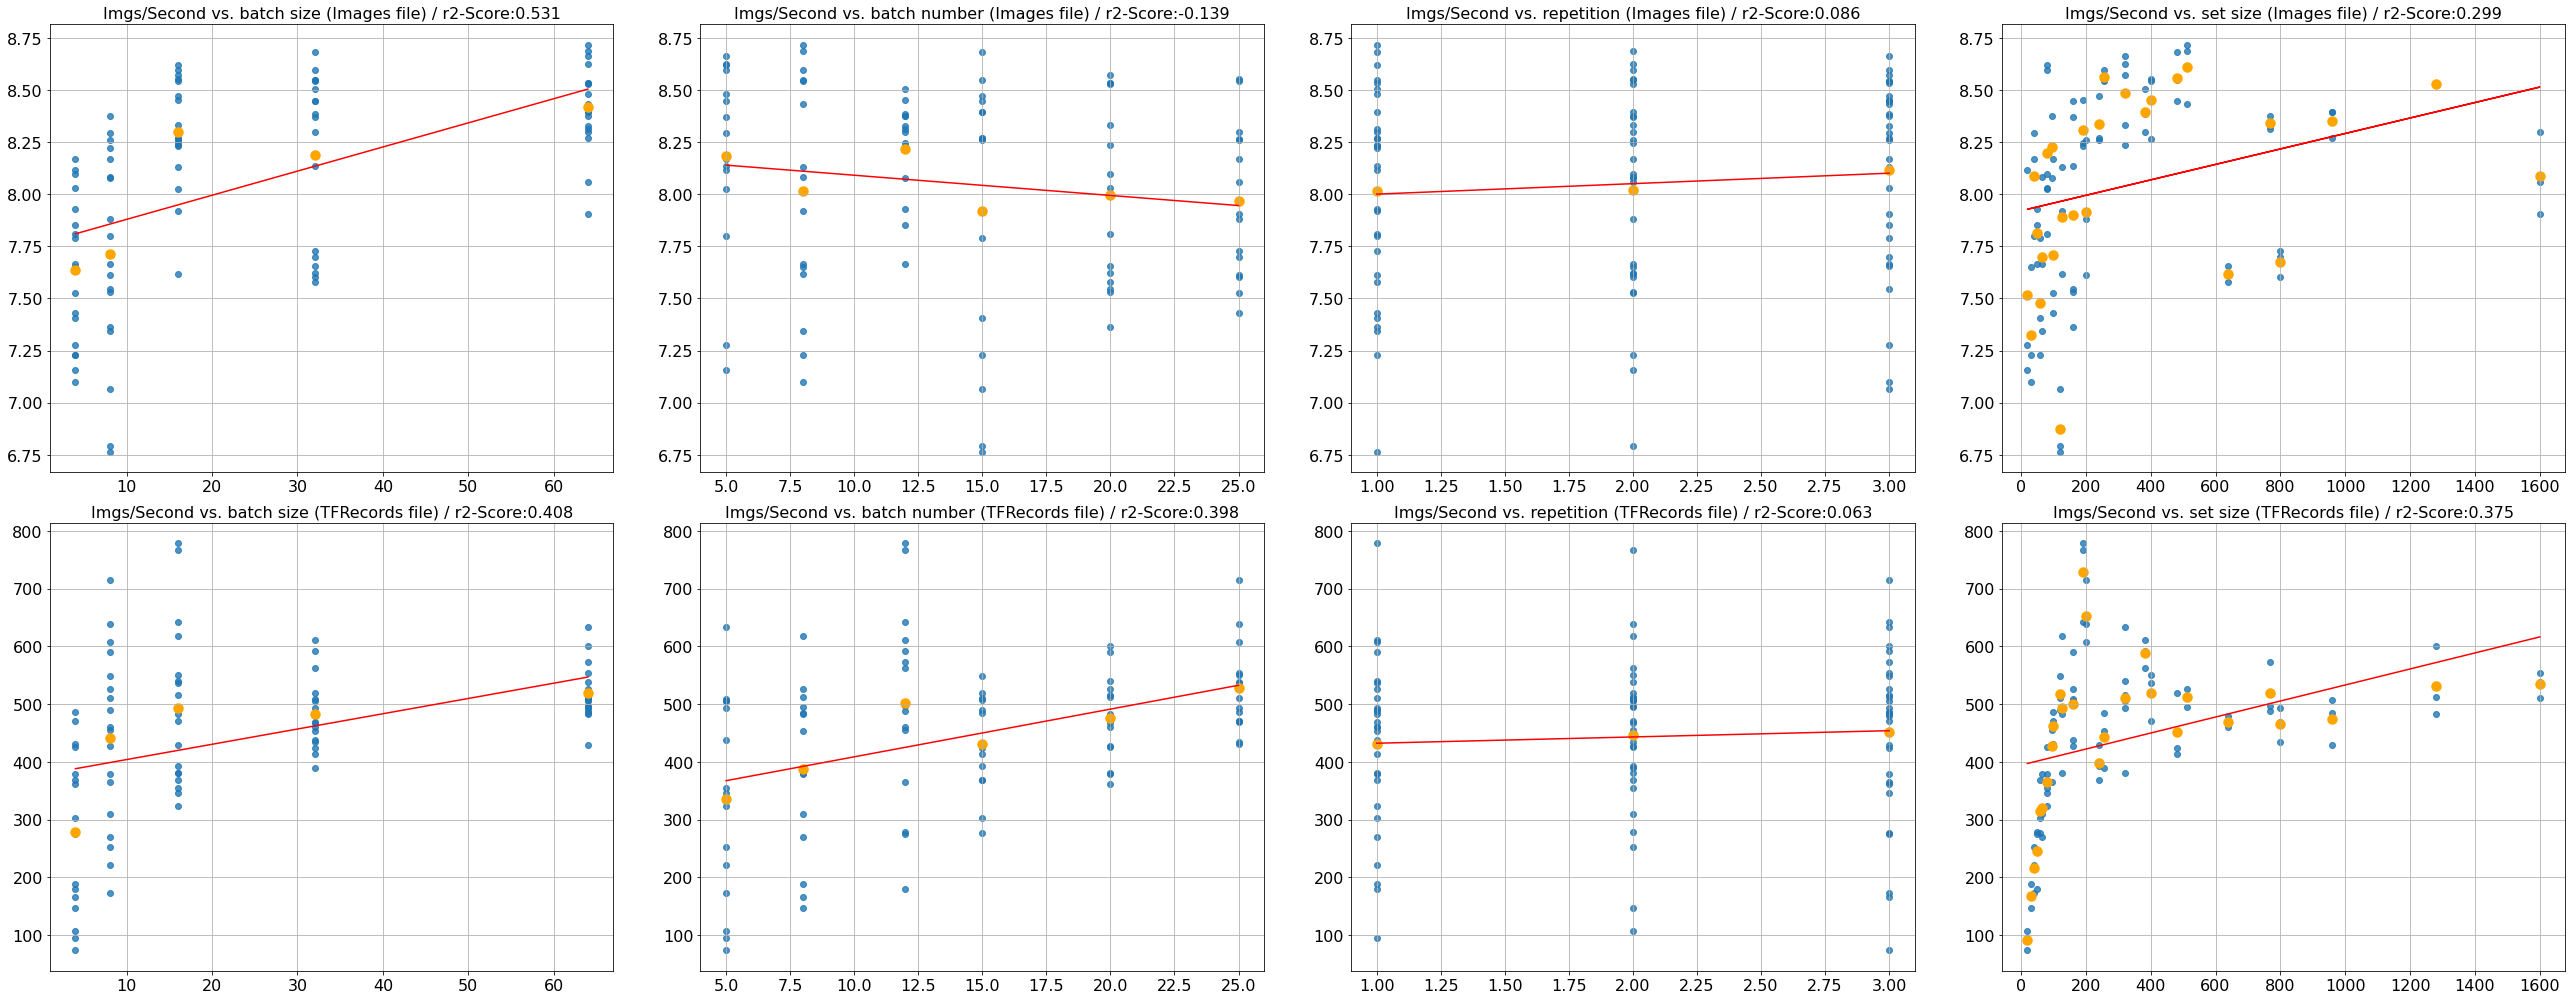

In [16]:
import pyspark
import matplotlib.pyplot as plt
from scipy import stats 
from sklearn.linear_model import LinearRegression
import numpy as np
import pickle 
from functools import reduce

# Define constant related to Pickle file source
google_local = 0

FILENAME_2d = 'spark_job_210418-025958.pkl'
#spark_job_210424-125451.pkl
if google_local == 1:
    # If Pickle file is already in google drive folder define Filename as the output file in the root folder.
    FILENAME = '/content/spark_job.pkl'
else:
    # If file is not in google drive copy the Pickle stored in the bucket to google drive folder.
    %cd /content/drive/MyDrive/BD-CW
    !gsutil cp $BUCKET/$FILENAME_2d . 
    FILENAME = FILENAME_2d
    #!ls -l

# Define a spark context
#sc = pyspark.SparkContext.getOrCreate()

# Read from pickled file after copying from the bucket to google drive folder
with open(FILENAME, mode='rb') as f:
  [par_original,par_avg] = pickle.load(f)


#print(par_original[0][1]['batch size'])
#print(list(par_avg[0][1].keys()))

params = ['batch size','batch number','repetition','set size']

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(36,14))
num_param = 0

for param in params: #zip(par_original[0][1], par_original[1][1]): 
    #print('-',j)
    #print(par_avg[0][1][num_param])
    #print(par_avg[0][1][num_param][1])

    # Perform linear regression for the original parameter combination
    res_im = stats.linregress(np.array(par_original[0][1][param]))
    res_tf = stats.linregress(np.array(par_original[1][1][param]))

    # Plot title for the graph
    axes[0,num_param].set_title('Imgs/Second vs. ' + str(param) + ' (Images file) / ' + 'r2-Score:' + str(np.round(res_im.rvalue,3)),fontdict={'fontsize': 16})
    axes[1,num_param].set_title('Imgs/Second vs. ' + str(param) + ' (TFRecords file) / ' + 'r2-Score:' + str(np.round(res_tf.rvalue,3)),fontdict={'fontsize': 16})
     
    # Plot actual data points for Image and TFRecord files
    axes[0,num_param].scatter([x[0] for x in par_original[0][1][param]], [x[1] for x in par_original[0][1][param]],alpha=0.8)
    axes[1,num_param].scatter([x[0] for x in par_original[1][1][param]], [x[1] for x in par_original[1][1][param]],alpha=0.8)
    
    # Plot linear regression line for Image and TFRecord files
    axes[0,num_param].plot([x[0] for x in par_original[0][1][param]], 
                           [(res_im.intercept + res_im.slope*x[0]) for x in par_original[0][1][param]], 'r', label='fitted line')
    axes[1,num_param].plot([x[0] for x in par_original[1][1][param]], 
                           [(res_tf.intercept + res_tf.slope*x[0]) for x in par_original[1][1][param]], 'r', label='fitted line')
    
    # Plot average markers for Image and TFRecord files
    axes[0,num_param].scatter([x[0] for x in par_avg[0][1][param]], 
                [x[1] for x in par_avg[0][1][param]],color='orange',marker='o',s=30,linewidths=5)
    axes[1,num_param].scatter([x[0] for x in par_avg[1][1][param]], 
                [x[1] for x in par_avg[1][1][param]],color='orange',marker='o',s=30,linewidths=5)
    
    axes[0,num_param].xaxis.get_label().set_fontsize(16)
    axes[1,num_param].xaxis.get_label().set_fontsize(16)
    axes[0,num_param].yaxis.get_label().set_fontsize(16)
    axes[1,num_param].yaxis.get_label().set_fontsize(16)

    axes[0,num_param].tick_params(axis='x', labelsize=16)
    axes[1,num_param].tick_params(axis='x', labelsize=16)
    axes[0,num_param].tick_params(axis='y', labelsize=16)
    axes[1,num_param].tick_params(axis='y', labelsize=16)
    
    axes[0,num_param].grid(True)
    axes[1,num_param].grid(True)


    num_param+=1

plt.tight_layout()    
plt.show()

In [ ]:
b

## Task 3: Write TFRecord files to the cloud with Spark (20%)

This task of pre-processing images and creating TFRecord files is a more straightforward case of parallelisation. We will again use Spark.

### 3a)	Create the script (10%)

Re-Implement the code for creating the TFRecord files in Spark, using Spark mechanisms for distributing the workload over the shards. 

You need to copy over the mapping functions and adapt the resizing and recompression function to Spark (only one argument). (2%)
Replace the TensorFlow Dataset objects with RDDs, starting with an RDD that contains the list of image filenames. (2%)
Then use the mapping functions like with the TensorFlow Dataset object. (2%)

The code for writing to the TFRecord files needs to be put into a function, that can be applied to every partition with the ['RDD.mapPartitionsWithIndex'](https://spark.apache.org/docs/latest/api/python/pyspark.html#pyspark.RDD.mapPartitionsWithIndex) function. The return value of that function is not essential. You can return the filename, so that you have a list of the created TFRecord files. (4%) 



In order to write the TFRecord files to the cloud we need to copy the resize and recompress functions and pass them into RDDs.

In [ ]:
### CODING TASK ###

%%writefile spark_job_tfrecord.py

import sys
import pyspark
import time
import math
import tensorflow as tf
import numpy as np
import glob
import argparse
import pickle 



# Define constants
GCS_PATTERN = 'gs://flowers-public/*/*.jpg'
GCS_OUTPUT = 'gs://big-data-cw-adbr327-storage/tfrecords-jpeg-192x192-2/flowers' # remove/change to use your own files
# Define number of partitions to be used (SHARDS)
SHARDS = 16 
NUM_PARTITIONS = math.ceil(1.0 * SHARDS)
TARGET_SIZE = [192, 192] # the resolution for the images
CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']


def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

## Write the images to TFRecord files with Spark
# functions for writing TFRecord entries
# Feature values are always stored as lists, a single data element will be a list of size 1
def _bytestring_feature(list_of_bytestrings):
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=list_of_bytestrings))

def _int_feature(list_of_ints): # int64
    return tf.train.Feature(int64_list=tf.train.Int64List(value=list_of_ints))  

def to_tfrecord(tfrec_filewriter, img_bytes, label): #, height, width):  
    class_num = np.argmax(np.array(CLASSES)==label) # 'roses' => 2 (order defined in CLASSES)
    one_hot_class = np.eye(len(CLASSES))[class_num]     # [0, 0, 1, 0, 0] for class #2, roses
    feature = {
        "image": _bytestring_feature([img_bytes]), # one image in the list
        "class": _int_feature([class_num]) #,        # one class in the list
    }
    return tf.train.Example(features=tf.train.Features(feature=feature))
 

def decode_jpeg_and_label_spark(filepath):    
    bits = tf.io.read_file(filepath)
    image = tf.image.decode_jpeg(bits)
    # parse flower name from containing directory
    label = tf.strings.split(tf.expand_dims(filepath, axis=-1), sep='/')
    label2 = label.values[-2]
    return image, label2

def resize_and_crop_image_spark(image_label):
    # Resize and crop using "fill" algorithm:
    # always make sure the resulting image
    # is cut out from the source image so that
    # it fills the TARGET_SIZE entirely with no
    # black bars and a preserved aspect ratio.
    image,label = image_label

    w = tf.shape(image)[0]
    h = tf.shape(image)[1]
    tw = TARGET_SIZE[1]
    th = TARGET_SIZE[0]
    resize_crit = (w * th) / (h * tw)
    image = tf.cond(resize_crit < 1,
                    lambda: tf.image.resize(image, [w*tw/w, h*tw/w]), # if true
                    lambda: tf.image.resize(image, [w*th/h, h*th/h])  # if false
                    )
    nw = tf.shape(image)[0]
    nh = tf.shape(image)[1]
    image = tf.image.crop_to_bounding_box(image, (nw - tw) // 2, (nh - th) // 2, tw, th)
    return image, label
       

def recompress_image_spark(image_label):
    image,label = image_label
    height = tf.shape(image)[0]
    width = tf.shape(image)[1]
    image = tf.cast(image, tf.uint8)
    image = tf.image.encode_jpeg(image, optimize_size=True, chroma_downsampling=False)
    return [image, label, height, width]

 
# def toTFExample(image, label):
#     """Serializes an image/label as a TFExample byte string"""
#     example = tf.train.Example(
#     features = tf.train.Features(
#         feature = {
#         'label': tf.train.Feature(int64_list=tf.train.Int64List(value=label.astype("int64"))),
#         'image': tf.train.Feature(int64_list=tf.train.Int64List(value=image.astype("int64")))
#         }
#     )
#     )
#     return example.SerializeToString()

def write_tfrecords_files_spark(index, iterator):

    # We define a filename for each shard (NUM_PARTITIONS) which is defined by the mapPartitionsWithIndex method.
    filename = GCS_OUTPUT + "-{:02d}.tfrec".format(index)
    #test_partition_index = str(index)
    #print(filename, str(index))

    # For each file 
    with tf.io.TFRecordWriter(filename) as out_file:
        for (image, label, height, width) in iterator:
            example = to_tfrecord(out_file,
                                    image.numpy(), # re-compressed image: already a byte string
                                    label.numpy() 
                                    #, height.numpy()[i], 
                                    #, width.numpy()[i]
                                    )
            # Write files to cluster storage
            out_file.write(example.SerializeToString())
    #print("Wrote file {} containing {} records".format(filename, shard_size))
    #print("Total time: "+str(time.time()-tt0))
    return [filename]
 
  
def task3a(argv):  
    
    #Parse the provided arguments
    #print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument

    args = parser.parse_args(argv) # read the value
    # the value provided with --out_bucket is now in args.out_bucket
    print("Starting Task 3")
    tt0 = time.time()


    # images = []
    # #labels = []
    # jpg_files = tf.io.gfile.glob(GCS_PATTERN)
    # for filename in jpg_files:
    #     images.append(filename)
        #labels.append(filename.split('/')[-2])


    sc = pyspark.SparkContext.getOrCreate()
    # Parallelise according to the number of total cores with minimum of 2 partitions up to 4 per vCPU core as Spark documentation.
    filenames_RDD = sc.parallelize(tf.io.gfile.glob(GCS_PATTERN), NUM_PARTITIONS)
    #print(filenames_RDD.count(),filenames_RDD.take(1))
    #filenames_RDD = filenames_RDD.sample(False,0.05)

    # Apply decode operation to the RDD (image and label)
    dataset1_RDD = filenames_RDD.map(decode_jpeg_and_label_spark)
     # Apply resize and crop operations to the RDD (image and label)
    dataset2_RDD = dataset1_RDD.map(resize_and_crop_image_spark)  
     # Apply recompression to the RDD (image and label)
    dataset3_RDD = dataset2_RDD.map(recompress_image_spark)

    # Check number of partitions
    print(dataset3_RDD.getStorageLevel())
    # Check number of partitions
    print(dataset3_RDD.getNumPartitions())
    dataset4_RDD = dataset3_RDD.repartition(NUM_PARTITIONS)
    dataset5_RDD = dataset4_RDD.mapPartitionsWithIndex(write_tfrecords_files_spark)
    
    #combOutput = sorted(dataset4_RDD.collect())
    # print(combOutput)
    #save(combOutput,args.out_bucket,args.out_file)
    # Print results (testing)
    print("Resultant RDD:",dataset5_RDD.collect())
    tt1 = time.time()
    print("Ending Task 3")
    print("Time elapsed (seconds):",tt1-tt0)

if  'google.colab' not in sys.modules: # Don't use system arguments run in Colab 
    task3a(sys.argv[1:])  
elif __name__ == "__main__" : # but define them manually
    task3a(["--out_bucket", BUCKET, "--out_file", "spark_job_task3a.pkl"])

Overwriting spark_job_tfrecord.py


We can test the script in Spark local execution.

In [ ]:
#%run -i ./spark_job_tfrecord.py -- --out_bucket BUCKET --out_file FILENAME 

### 3b)	Run and test (2%)

Run the script and test the output. Demonstrate that the files you wrote with your spark job work can be read and used by the model training. 

In [ ]:
### CODING TASK ###

import datetime
FILENAME = 'spark_job_task3a_' + str(datetime.datetime.now().strftime("%y%m%d-%H%M%S")) + '.pkl'

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER \
    ./spark_job_tfrecord.py \
    -- --out_bucket $BUCKET --out_file $FILENAME 

ERROR: (gcloud.dataproc.jobs.submit.pyspark) argument PY_FILE: Must be specified.
Usage: gcloud dataproc jobs submit pyspark PY_FILE (--cluster=CLUSTER | --cluster-labels=[KEY=VALUE,...]) [optional flags] [-- JOB_ARGS ...]
  optional flags may be  --archives | --async | --bucket | --cluster |
                         --cluster-labels | --driver-log-levels | --files |
                         --help | --jars | --labels | --max-failures-per-hour |
                         --max-failures-total | --properties | --py-files |
                         --region

For detailed information on this command and its flags, run:
  gcloud dataproc jobs submit pyspark --help


We can now read from the TFRecord Dataset to test and demonstrate by using the images reading function provided previously. 


In [ ]:
BUCKET + '/tfrecords-jpeg-192x192-2/'

'gs://big-data-cw-adbr327-storage/tfrecords-jpeg-192x192-2/'

In [ ]:
### CODING TASK ###

def read_dataset_task_3(BUCKET):

    TARGET_SIZE = [192, 192] # the resolution for the images
    #CLASSES = [b'daisy', b'dandelion', b'roses', b'sunflowers', b'tulips']

    # Define source folder to get the TFRecord files as inputs
    GCS_TFRFOLDER = BUCKET + '/tfrecords-jpeg-192x192-2/'

    # We replicate the load_dataset and read_tfrecord functions (only changing the names for applicability to the exercise)
    def read_tfrecord_spark(example):
        features = {
            "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
            "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
        }
        # decode the TFRecord
        example = tf.io.parse_single_example(example, features)
        image = tf.image.decode_jpeg(example['image'], channels=3)
        image = tf.reshape(image, [*TARGET_SIZE, 3])    
        class_num = example['class']
        return image, class_num 

    def load_dataset_spark(filenames):
        # read from TFRecords. For optimal performance, read from multiple    
        # TFRecord files at once and set the option experimental_deterministic = False
        # to allow order-altering optimizations.
        option_no_order = tf.data.Options()
        option_no_order.experimental_deterministic = False
        dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
        dataset = dataset.with_options(option_no_order)
        dataset = dataset.map(read_tfrecord_spark, num_parallel_calls=AUTO)
        return dataset

    filenames = tf.io.gfile.glob(GCS_TFRFOLDER + "*.tfrec")
    datasetDecoded_task3b = load_dataset_spark(filenames)

read_dataset_task_3(BUCKET)

**And now we display the images which demonstrate they can be used as input for the model training.**

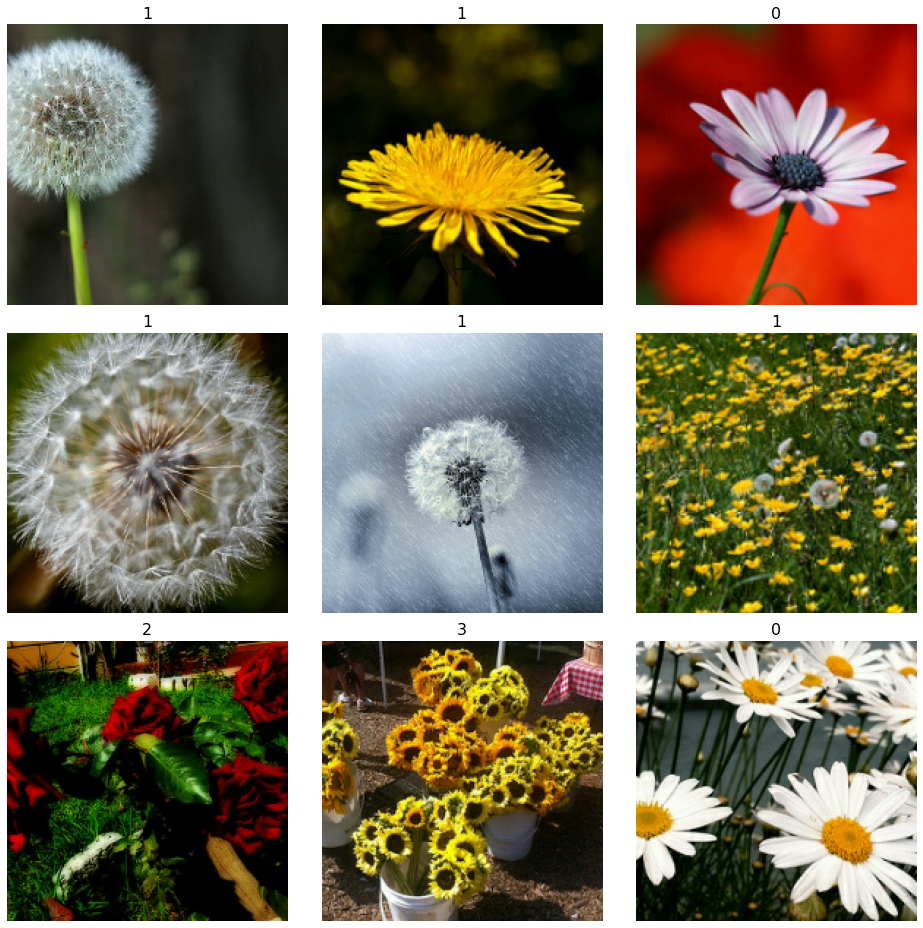

In [ ]:
display_9_images_from_dataset(datasetDecoded_task3b)

At the end of a session we should delete the cluster, as it incurs a cost for the time it runs.

In [ ]:
!gcloud dataproc clusters delete $CLUSTER -q 
# the -q flag disables the confirmation prompt 
# , we want to make sure it really gets deleted

Waiting on operation [projects/big-data-cw-adbr327/regions/us-central1/operations/4a1478f7-1b81-314b-9b33-a1ef76828bec].
Deleted [https://dataproc.googleapis.com/v1/projects/big-data-cw-adbr327/regions/us-central1/clusters/big-data-cw-adbr327-cluster].


### 3c)	Experiment and discussion (8%)

i) Explain the difference between this use of Spark and most standard applications like e.g. in our labs. (2%)

ii)	Test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with quadruple resources. Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (6%)

Write your answers in your report.

i) Explain the difference between this use of Spark and most standard applications like e.g. in our labs. (2%)

ii) Test your program with 4 machines with double the resources each (2 vCPUs, memory, disk) and 1 machine with quadruple resources. Discuss the results in terms of disk I/O and network bandwidth allocation in the cloud. (6%)

**1)**

Let's test first  the program with 4 machines with double the resources each (2 vCPU,memory,disk). 

 **Original configuration:**

**- max 100GB of SSD persistent disk**

**- max 2000GB of standard persistent disk**

**- max 8 vCPUs**


To achieve this we need to create the following cluster configuration:

- 1 Master Node with double the original resources.

- 3 Worker Nodes with double the original resources.

Total allocated: 4 machines with double the original resources.

In [ ]:
### CODING TASK ###
import math

max_workers_disk = 2000
worker_nodes = 3
worker_disk_size = str(int(math.floor(max_workers_disk/worker_nodes))) + 'GB'


CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 \
    --master-machine-type n1-standard-2 --master-boot-disk-type pd-ssd --master-boot-disk-size 100GB \
    --worker-machine-type n1-standard-2 --worker-boot-disk-type pd-standard --worker-boot-disk-size $worker_disk_size \
    --num-workers $worker_nodes \
    --max-idle 3600s \
    --metadata='PIP_PACKAGES=tensorflow==2.1.0' \
    --initialization-actions=gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh

Waiting on operation [projects/big-data-cw-adbr327/regions/us-central1/operations/eec0269f-eb79-3524-8ecf-ca439e8d093b].

Created [https://dataproc.googleapis.com/v1/projects/big-data-cw-adbr327/regions/us-central1/clusters/big-data-cw-adbr327-cluster] Cluster placed in zone [us-central1-f].


Now we wait for 4 minutes to allow for the cluster stabilization.

In [ ]:
time.sleep(240)

And now we execute against the cluster created.

In [ ]:
### CODING TASK ###

import datetime
FILENAME = 'spark_job_task3c2_' + str(datetime.datetime.now().strftime("%y%m%d-%H%M%S")) + '.pkl'

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER \
    ./spark_job_tfrecord.py \
    -- --out_bucket $BUCKET --out_file $FILENAME 

Job [893b9cf1c6794829ae59c40fdc7539ab] submitted.
Waiting for job output...
2021-04-18 14:44:16.015118: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-18 14:44:16.015329: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-18 14:44:16.015348: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Starting Task 3
21/04/18 14:44:19 INFO org.spark_project.jetty.util.log: Logging initialized @7626ms
21/04/18 14:

At the end of a session we should delete the cluster, as it incurs a cost for the time it runs.

In [ ]:
!gcloud dataproc clusters delete $CLUSTER -q 
# the -q flag disables the confirmation prompt 
# , we want to make sure it really gets deleted

Waiting on operation [projects/big-data-cw-adbr327/regions/us-central1/operations/d4ff916e-30f7-34ad-a6d4-dff441141af1].
Deleted [https://dataproc.googleapis.com/v1/projects/big-data-cw-adbr327/regions/us-central1/clusters/big-data-cw-adbr327-cluster].


**2)**

Secondly we will execute the same code against the cluster with a single machine for master node and worker node respectively with all the resources quadrupled for each machine and totalling for the master node the same amount of vCPU,memory,disk as the original cluster definition.

Let's test now with 1 machines with the vCPU resources quadrupled for the master node (4 vCPU).

Original configuration:

- max 100GB of SSD persistent disk

- max 2000GB of standard persistent disk

- max 8 vCPUs

To achieve this we need to create the following cluster configuration:

1 Master Node with the original resources quadrupled in terms of vCPU.

Total allocated: 1 single node machine with the original resources quadrupled.

In [ ]:
### CODING TASK ###
import math


CLUSTER = '{}-cluster'.format(PROJECT)
!gcloud dataproc clusters create $CLUSTER \
    --image-version 1.4-ubuntu18 --single-node \
    --master-machine-type n1-standard-4 --master-boot-disk-type pd-ssd --master-boot-disk-size 100GB \
    --max-idle 3600s \
    --metadata='PIP_PACKAGES=tensorflow==2.1.0' \
    --initialization-actions=gs://goog-dataproc-initialization-actions-$REGION/python/pip-install.sh

Waiting on operation [projects/big-data-cw-adbr327/regions/us-central1/operations/8a01e787-f3ed-3669-9063-2229fb756df7].
Created [https://dataproc.googleapis.com/v1/projects/big-data-cw-adbr327/regions/us-central1/clusters/big-data-cw-adbr327-cluster] Cluster placed in zone [us-central1-f].


Now we wait for 4 minutes to allow for the cluster stabilization.

In [ ]:
time.sleep(240)

And now we execute against the cluster created.

In [ ]:
### CODING TASK ###

import datetime
FILENAME = 'spark_job_task3c2_' + str(datetime.datetime.now().strftime("%y%m%d-%H%M%S")) + '.pkl'

!gcloud dataproc jobs submit pyspark --cluster $CLUSTER \
    ./spark_job_tfrecord.py \
    -- --out_bucket $BUCKET --out_file $FILENAME 

Job [9bc2c4a1239d43e8990cf3c9952a4eed] submitted.
Waiting for job output...
2021-04-23 18:33:39.747097: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer.so.6'; dlerror: libnvinfer.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-23 18:33:39.747289: W tensorflow/stream_executor/platform/default/dso_loader.cc:55] Could not load dynamic library 'libnvinfer_plugin.so.6'; dlerror: libnvinfer_plugin.so.6: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/usr/lib/hadoop/lib/native
2021-04-23 18:33:39.747306: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:30] Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.
Starting Task 3
21/04/23 18:33:41 INFO org.spark_project.jetty.util.log: Logging initialized @5312ms
21/04/23 18:

At the end of a session we should delete the cluster, as it incurs a cost for the time it runs.

In [ ]:
!gcloud dataproc clusters delete $CLUSTER -q 
# the -q flag disables the confirmation prompt 
# , we want to make sure it really gets deleted

Waiting on operation [projects/big-data-cw-adbr327/regions/us-central1/operations/0d74708e-f8da-35af-8d09-e8140881ce77].
Deleted [https://dataproc.googleapis.com/v1/projects/big-data-cw-adbr327/regions/us-central1/clusters/big-data-cw-adbr327-cluster].


# Section 2: Machine Learning in the Cloud

In this section we will use the pre-processed data with the GC AI-Platform for Machine Learning. 

## Preparation: Machine Learning Setup

As in Section 1, In this section, we get started based on  code from the 'Fast and Lean Data Science' course, this time lecture 4, to establish the task.


### Create Train and Test Sets 

We will first set up a few variables for the machine learning and then run split the test and training sets. 

In [ ]:
BUCKET

'gs://big-data-cw-adbr327-storage'

In [ ]:
BATCH_SIZE = 64 # this is a good setting for the Colab GPU (K80)
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
#GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, use your own later
GCS_TFR_PATTERN = 'gs://big-data-cw-adbr327-storage/tfrecords-jpeg-192x192-2/flowers*.tfrec' 

TARGET_SIZE = [192,192]

VALIDATION_SPLIT = 0.25

CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # maps class numbers to labels strings

SAMPLE_NUM=3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets


In [ ]:
# splitting data files between training and validation
filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
print("len(filenames): "+str(len(filenames)))
split = int(len(filenames) * VALIDATION_SPLIT)
training_filenames = filenames[split:]
validation_filenames = filenames[:split]
print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE
print("With a batch size of {}, there will be {} batches per training epoch and {} batch(es) per validation run.".format(BATCH_SIZE, steps_per_epoch, validation_steps))


len(filenames): 16
Pattern matches 16 data files. Splitting dataset into 12 training files and 4 validation files
With a batch size of 64, there will be 42 batches per training epoch and 14 batch(es) per validation run.


In [ ]:
training_filenames

['gs://flowers-public/tfrecords-jpeg-192x192-2/flowers04-230.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers05-230.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers06-230.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers07-230.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers08-230.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers09-230.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers10-230.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers11-230.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers12-230.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers13-230.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers14-230.tfrec',
 'gs://flowers-public/tfrecords-jpeg-192x192-2/flowers15-220.tfrec']

In [ ]:
def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

# instantiate the datasets
training_dataset = get_batched_dataset(training_filenames, train=True)
validation_dataset = get_batched_dataset(validation_filenames, train=False)

In [ ]:
sample_set = training_dataset.take(4)
for image, label in sample_set: 
    print("Image batch shape {}, {})".format(image.numpy().shape, \
                        [str(lbl) for lbl in label.numpy()]))

Image batch shape (64, 192, 192, 3), ['1', '0', '0', '3', '0', '0', '3', '2', '4', '2', '4', '1', '4', '3', '3', '0', '1', '2', '4', '1', '2', '2', '2', '1', '0', '4', '2', '3', '0', '1', '0', '4', '4', '1', '0', '1', '4', '3', '1', '1', '0', '0', '0', '1', '4', '0', '3', '2', '0', '3', '4', '1', '2', '1', '2', '2', '2', '4', '4', '0', '0', '4', '3', '2'])
Image batch shape (64, 192, 192, 3), ['3', '1', '0', '3', '3', '1', '1', '2', '2', '1', '3', '4', '0', '0', '1', '2', '1', '0', '4', '3', '1', '4', '4', '2', '1', '4', '0', '3', '4', '0', '2', '1', '4', '0', '2', '4', '0', '0', '1', '2', '0', '1', '2', '4', '0', '4', '1', '1', '3', '1', '1', '0', '1', '3', '4', '2', '2', '2', '1', '4', '0', '2', '2', '3'])
Image batch shape (64, 192, 192, 3), ['1', '4', '4', '3', '2', '2', '0', '2', '0', '2', '0', '1', '1', '1', '0', '1', '1', '4', '1', '2', '4', '0', '0', '1', '4', '0', '1', '1', '4', '1', '1', '2', '1', '3', '3', '4', '2', '0', '3', '4', '0', '0', '3', '2', '2', '0', '4', '1', '2',

### Set up a pretrained model

In [ ]:
pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
pretrained_model.trainable = False

model = tf.keras.Sequential([
    pretrained_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(100,activation='relu'),
    tf.keras.layers.Dropout(.5),
    tf.keras.layers.Dense(5, activation='softmax')
])

model.compile(
    optimizer='adam',
    loss = 'sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_192 (Functi (None, 6, 6, 1280)        2257984   
_________________________________________________________________
flatten_2 (Flatten)          (None, 46080)             0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               4608100   
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 5)                 505       
Total params: 6,866,589
Trainable params: 4,608,605
Non-trainable params: 2,257,984
_________________________________________________________________


### Local Training

In [ ]:
tt0 = time.time()
history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                    validation_data=validation_dataset, validation_steps=validation_steps)
tt = time.time() - tt0
print("Wall clock time = {}".format(tt))

Epoch 1/5
42/42 [==============================] - 97s 2s/step - loss: 19.3041 - accuracy: 0.1739 - val_loss: 1.6100 - val_accuracy: 0.0993
Epoch 2/5
42/42 [==============================] - 91s 2s/step - loss: 1.6103 - accuracy: 0.1752 - val_loss: 1.6099 - val_accuracy: 0.0993
Epoch 3/5
41/42 [============================>.] - ETA: 1s - loss: 1.6110 - accuracy: 0.1806

KeyboardInterrupt: ignored

Result: Training time

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


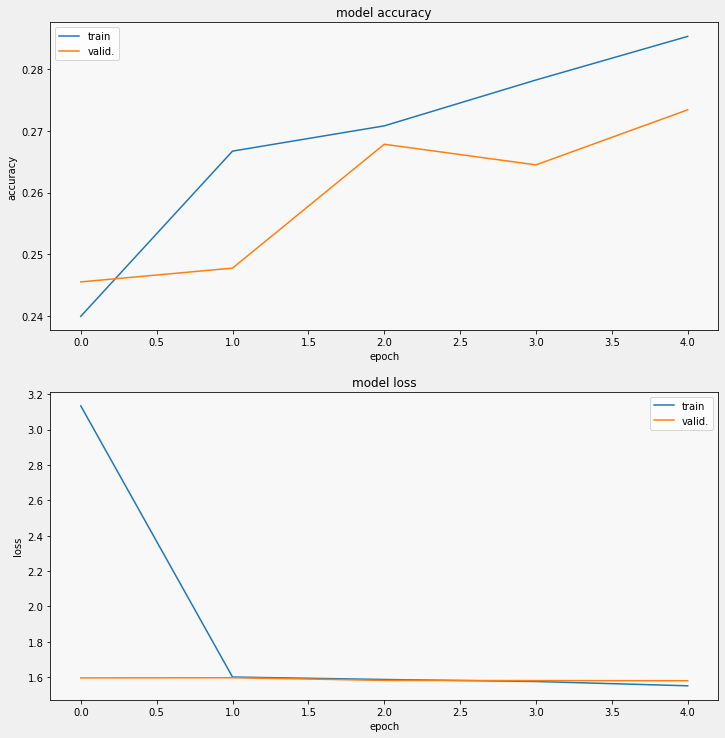

In [ ]:
print(history.history.keys())
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [ ]:
# random input: execute multiple times to change results
flowers, labels = dataset_to_numpy_util(load_dataset(validation_filenames).skip(np.random.randint(300)), 9)

predictions = model.predict(flowers, steps=1)
print(np.array(CLASSES)[np.argmax(predictions, axis=-1)].tolist())

[b'dandelion', b'dandelion', b'dandelion', b'dandelion', b'dandelion', b'dandelion', b'dandelion', b'dandelion', b'dandelion']


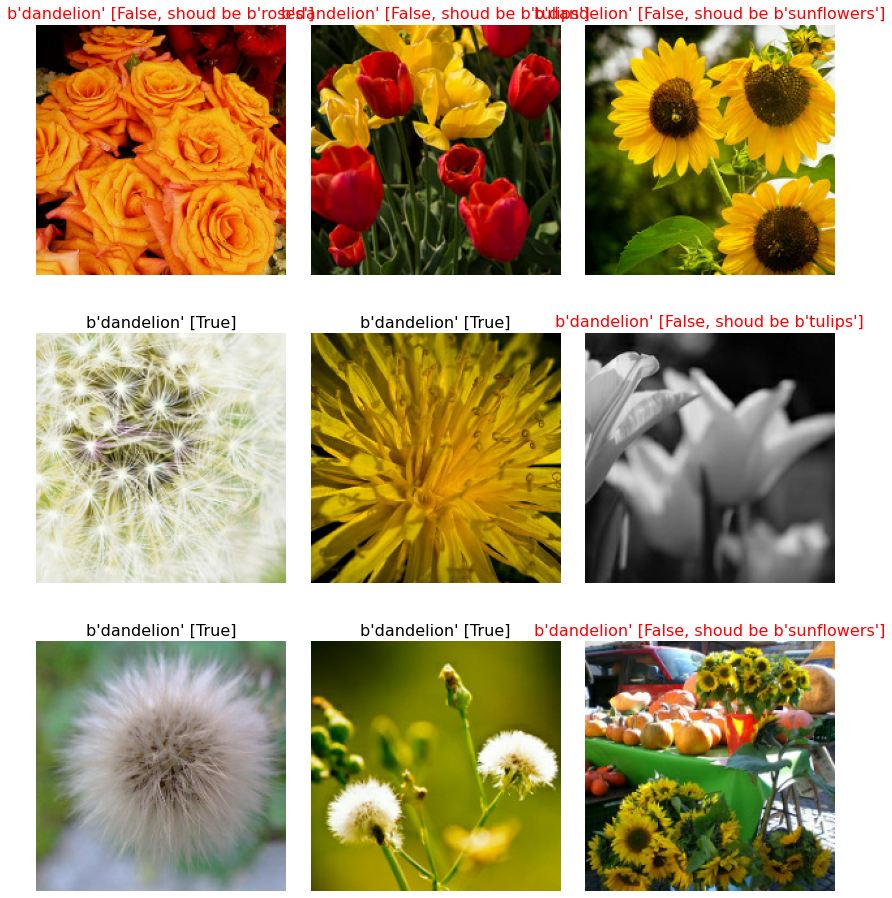

In [ ]:
display_9_images_with_predictions(flowers, predictions, labels)

## Task 4: Machine learning in the cloud (20%)

### 4a) Create the package and code for the AI-Platform (7%)

The AI Platform needs code in a 'package'. 
The package can contain complex software systems and extensive  information on the setup. 
We will keep the package as simple as possible here.



i) The minimal 'package' in Python needs a directory with two modules (i.e. Python files). 
Create a directory 'trainer' and then an empty file `trainer/__init__.py`. 
This can be done by using the command line tool `touch`. 
Check that the file exists. (1%) 

In [ ]:
### CODING TASK ###

dir_name = 'trainer'
emptyfile = '__init__.py'

# Create a directory 'trainer'
from pathlib import Path
if os.path.isdir(dir_name) == False:
  !mkdir $dir_name #to make new dir.
 
# Create an empty file ('__init__.py')
!touch $dir_name/$emptyfile

# Check that the file exists
if os.path.isfile(dir_name+'/'+emptyfile):
  print('The file "'+dir_name+'/'+emptyfile+'" already exists.')
else:
  print('The file "'+dir_name+'/'+emptyfile+'" does not exist.')


The file "trainer/__init__.py" already exists.


ii) The other file we need is the module with the training code, which we will call `task.py`. 

We can build this file by combining the last few cells under 'Machine Learning Setup' into one file, almost literally. 

Then, we need to save the model itself and the training history into a file after training. 
The `history` object returned by `model.fit` can not be pickled, but it's data in `history.history` can. 
For saving the model, use `model.save()`.
Write the necessary code, like in section 2 when preparing jobs for Spark/DataProc.

If you use argparse as in section 2 (recommended), then you need to add an argument `--job-dir` that will be passed through from the AI-Platform to your program.
(6%)

In [ ]:
### CODING TASK ###
%%writefile trainer/task.py

# Pyspark not used
#import pyspark

import sys
import argparse
import pickle 
import tensorflow as tf
import time

BATCH_SIZE = 64 # this is a good setting for the Colab GPU (K80)
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
# We increase number of epochs to 40 in order to observe the effects in accuracy, loss and training time
EPOCHS = 60 # 5 is for testing. Increase later
#GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, use your own later
GCS_TFR_PATTERN = 'gs://big-data-cw-adbr327-storage/tfrecords-jpeg-192x192-2/flowers*.tfrec' 
AUTO = tf.data.experimental.AUTOTUNE

TARGET_SIZE = [192,192]
VALIDATION_SPLIT = 0.20
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # maps class numbers to labels strings
SAMPLE_NUM=3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple    
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets


def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

def task4a(argv):

    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    parser.add_argument('--job-dir', metavar='job_dir', required=True,
                        help='The bucket URL for the result.') # add a required argument

    args = parser.parse_args(argv)
    
    # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // BATCH_SIZE
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // BATCH_SIZE

    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)

    pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
    pretrained_model.trainable = False

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100,activation='relu'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    tt0 = time.time()
    history = model.fit(training_dataset, steps_per_epoch=steps_per_epoch, epochs=EPOCHS,
                        validation_data=validation_dataset, validation_steps=validation_steps)
    tt = time.time() - tt0
    print("Wall clock time = {}".format(tt))

    model.save(args.job_dir + '/trainer', save_format='tf')
    save(history.history,args.job_dir,args.out_file)


if  'google.colab' not in sys.modules: # Don't use system arguments run in Colab 
    task4a(sys.argv[1:])  
elif __name__ == "__main__" : # but define them manually
     task4a(["--out_file", 'out_file', "--job-dir", 'job_dir']) 
          #,"--batch_sizes",batch_sizes,#"--batch_number",batch_number,"--repetitions",repetitions])


Writing trainer/task.py


### 4b) Run the Training on the AI-Platform and view the Output (3%)

Now, with all code in place, we can submit the package. AI-Platform is serverless, therefore we don't need to create a cluster ourselves, but we just submit a job and the master and workers will be set up automatically. 
Find [here](https://cloud.google.com/sdk/gcloud/reference/ai-platform/jobs/submit/training) the information how to submit a training job in GCS AI-Platform.  

The job will wait in a queue before it gets executed, this can take several minutes (at least on free credits). 
It's therefore a good idea to test the script locally before you submit to the cloud. 

You can, however, get powerful hardware. Up to 30 K80 or even P100 GPUs are available, but not all configurations are possible. 
Check [here](https://cloud.google.com/ai-platform/training/docs/quotas#gpu-quota) and [here](https://cloud.google.com/ai-platform/training/docs/using-gpus), and test [here on the console](https://console.cloud.google.com/ai-platform/create-job/custom-code?folder=true&organizationId=true) with the Create option whether your configuration works in the Google Cloud.


In [ ]:
import datetime
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task"
PACKAGE_STAGING_PATH=BUCKET
JOB_NAME="flowers_training_"+ str(datetime.datetime.now().strftime("%y%m%d_%H%M%S")) # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME

### CODING TASK ### 
print(JOB_DIR)

gs://big-data-cw-adbr327-storage/jobs/flowers_training_210419_180302


**First we can test the script locally before submitting to the cloud.**

In [ ]:
#%run -i ./trainer/task.py --job_dir JOB_DIR

import datetime
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task"
PACKAGE_STAGING_PATH=BUCKET
JOB_NAME="flowers_training_"+ str(datetime.datetime.now().strftime("%y%m%d_%H%M%S")) # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME
OUT_FILE = 'spark_job_output_history_task4a.pkl'

!gcloud ai-platform local train \
        --package-path $TRAINER_PACKAGE_PATH \
        --module-name $MAIN_TRAINER_MODULE \
        --configuration standard_gpu \
        -- --out_file $OUT_FILE --job-dir $JOB_DIR

2021-04-22 15:30:42.734705: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
['--out_file', 'spark_job_output_history_task4a.pkl', '--job-dir', 'gs://big-data-cw-adbr327-storage/jobs/flowers_training_210422_153037']
len(filenames): 32
Pattern matches 32 data files. Splitting dataset into 24 training files and 8 validation files
2021-04-22 15:30:45.537245: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-22 15:30:45.538132: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-22 15:30:45.568771: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-04-22 15:30:45.569333: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with

It took approximately 2 minutes to train the model in a single machine and single GPU. Now we define a config.yaml file that will be used for the job configuration in the google cloud.

In [ ]:
%%writefile trainer/config.yaml

trainingInput:
    scaleTier: CUSTOM
    # Configure a master with 1 K80 GPUs
    masterType: n1-standard-8
    masterConfig:
        acceleratorConfig:
            count: 1
            type: NVIDIA_TESLA_K80
    # Configure 7 workers, each with 1 K80 GPUs
    workerType: n1-standard-8
    workerConfig:
        acceleratorConfig:
            count: 7
            type: NVIDIA_TESLA_K80
     # Configure 3 parameter servers with no GPUs
    parameterServerCount: 3
    parameterServerType: n1-standard-8
    # masterType: complex_model_m_gpu
    # workerCount: 4
    # workerType: complex_model_m_gpu
    # # Configure 3 parameter servers with no GPUs
    # parameterServerCount: 3
    # parameterServerType: large_model

Overwriting trainer/config.yaml


Then we submit the script to AI Platform.

In [ ]:
#!gcloud ai-platform jobs submit training $JOB_NAME #stream-logs 
import datetime
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task"
PACKAGE_STAGING_PATH=BUCKET
JOB_NAME="flowers_training_"+ str(datetime.datetime.now().strftime("%y%m%d_%H%M%S")) # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME
OUT_FILE = 'spark_job_output_history_task4a.pkl'

!gcloud ai-platform jobs submit training $JOB_NAME  \
                    --module-name $MAIN_TRAINER_MODULE \
                    --staging-bucket $PACKAGE_STAGING_PATH  \
                    --package-path $TRAINER_PACKAGE_PATH \
                    --runtime-version 2.2 \
                    --python-version 3.7 \
                    --config trainer/config.yaml \
                     -- --out_file $OUT_FILE --job-dir $JOB_DIR
                     #--packages additional-dep1.tar.gz,dep2.whl

Job [flowers_training_210422_154115] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe flowers_training_210422_154115

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs flowers_training_210422_154115
jobId: flowers_training_210422_154115
state: QUEUED


In [ ]:
 !gcloud ai-platform jobs describe $JOB_NAME

createTime: '2021-03-23T04:08:39Z'
etag: Ij4sDGZl4Lw=
jobId: flowers_training_210323_040833
state: PREPARING
trainingInput:
  jobDir: gs://big-data-cw-adbr327-304523-storage/jobs/flowers_training_210323_040833
  packageUris:
  - gs://big-data-cw-adbr327-304523-storage/flowers_training_210323_040833/7c3b9fcbee32d4717f1b12d046d72d85df66549aaa8173a214adfe9617c8a674/trainer-0.0.0.tar.gz
  pythonModule: trainer.task
  pythonVersion: '3.7'
  region: us-central1
  runtimeVersion: '2.1'
trainingOutput: {}

View job in the Cloud Console at:
https://console.cloud.google.com/mlengine/jobs/flowers_training_210323_040833?project=big-data-cw-adbr327-304523

View logs at:
https://console.cloud.google.com/logs?resource=ml_job%2Fjob_id%2Fflowers_training_210323_040833&project=big-data-cw-adbr327-304523


After training, plot the accuracy and loss curves based on the saved history.

We can find the history of the model that was generated and plot the measures.

In [ ]:
### CODING TASK ### 

import pyspark
import matplotlib.pyplot as plt
from scipy import stats 
from sklearn.linear_model import LinearRegression
import numpy as np

FILENAME = 'spark_job_output_history_task4a.pkl'

JOB_DIR = 'gs://big-data-cw-adbr327-storage/jobs/flowers_training_210418_211327'
#spark_job_output_history_task4a.pkl 

# Copy History file output to the local drive 
%cd /content/drive/MyDrive/BD-CW
!gsutil cp $JOB_DIR/$FILENAME . 
#!ls -l

# sc = pyspark.SparkContext.getOrCreate()

with open(FILENAME, mode='rb') as f:
  task4b_output = pickle.load(f) #[accuracy,val_accuracy] 

print(task4b_output)
#print(history.history.keys())
#display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
#display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)


/content/drive/MyDrive/BD-CW
Copying gs://big-data-cw-adbr327-storage/jobs/flowers_training_210418_211327/spark_job_output_history_task4a.pkl...
/ [1 files][  268.0 B/  268.0 B]                                                
Operation completed over 1 objects/268.0 B.                                      
total 8642
-rw------- 1 root root 8564589 Apr 19 00:25 'BD-CW Data preprocessing and ML training v13 - Questions.ipynb'
drwx------ 2 root root    4096 Mar 25 14:20  data
-rw------- 1 root root   36313 Mar 26 17:05  job_0.log
drwx------ 3 root root    4096 Mar 26 16:31  JOB_DIR
-rw------- 1 root root    1562 Mar 25 15:20  spark_job_210325-150745.pkl
-rw------- 1 root root    1562 Apr 15 01:43  spark_job_210415-013914.pkl
-rw------- 1 root root   12441 Apr 17 02:29  spark_job_210416-220451.pkl
-rw------- 1 root root   15303 Apr 17 16:25  spark_job_210417-155853.pkl
-rw------- 1 root root   13603 Apr 17 17:28  spark_job_210417-163056.pkl
-rw------- 1 root root   13603 Apr 17 17:57  spar

**Below we will plot the loss and accuracy curves for the predicted model.**

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


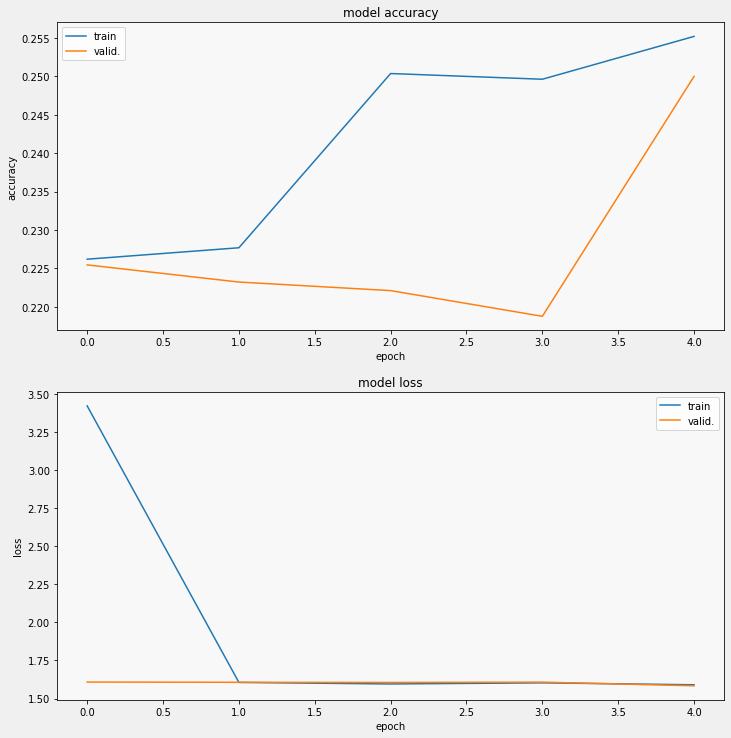

In [ ]:
print(task4b_output.keys())
display_training_curves(task4b_output['accuracy'], task4b_output['val_accuracy'], 'accuracy', 211)
display_training_curves(task4b_output['loss'], task4b_output['val_loss'], 'loss', 212)


### 4c) Distributed learning	(10%)

Apply a distributed learning strategy to the code (see https://www.tensorflow.org/tutorials/distribute/multi_worker_with_keras?hl=nb#choose_the_right_strategy for an example ).  
Add the necessary changes to the code.

Experiment with different strategies and batch sizes. Report and interpret your results. 
For the defining cluster sizes, you can use command line options as described here: https://cloud.google.com/ai-platform/training/docs/machine-types#legacy-machine-types . 
Check the pricing here ( https://cloud.google.com/ai-platform/training/pricing ) and make sure everything works before you run jobs on the expensive configurations. 

The machines with P100 and V100 GPUs are quite expensive. 
For the experiments here, the `standard_gpu` (1xK80) and the `complex_model_l_gpu` (8xK80) are sufficient.

**First we will adapt the code in 4a and execute again to generate a table containing a variety of epochs and batch sizes combinations.**

# **4c 0) Baseline model**

In [ ]:
### CODING TASK ###
%%writefile trainer/task.py

# Pyspark not used
#import pyspark

import sys
import argparse
import pickle 
import tensorflow as tf
import time

BATCH_SIZE = 64 # this is a good setting for the Colab GPU (K80)
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
EPOCHS = 5 # 5 is for testing. Increase later
#GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, use your own later
GCS_TFR_PATTERN = 'gs://big-data-cw-adbr327-storage/tfrecords-jpeg-192x192-2/flowers*.tfrec' 
AUTO = tf.data.experimental.AUTOTUNE

TARGET_SIZE = [192,192]
VALIDATION_SPLIT = 0.20
CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # maps class numbers to labels strings
SAMPLE_NUM=3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
  # read from TFRecords. For optimal performance, read from multiple    
  # TFRecord files at once and set the option experimental_deterministic = False
  # to allow order-altering optimizations.
  option_no_order = tf.data.Options()
  option_no_order.experimental_deterministic = False

  dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
  dataset = dataset.with_options(option_no_order)
  dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
  return dataset

def get_batched_dataset(filenames, train=False):
  dataset = load_dataset(filenames)
  dataset = dataset.cache() # This dataset fits in RAM
  if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
    dataset = dataset.repeat()
  dataset = dataset.batch(BATCH_SIZE)
  dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
  # should shuffle too but this dataset was well shuffled on disk already
  return dataset
  # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def tfr_dataset(batch_size):
    # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // batch_size
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // batch_size

    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, train=False)
    return training_dataset,validation_dataset,validation_steps,steps_per_epoch

def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))


def build_and_compile():
    
    pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
    pretrained_model.trainable = False

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100,activation='relu'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Compile model and optimize
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy'])
        #,lr=learning_rate)
    
    return model

def task4a(argv):


    # Parse the provided arguments
    print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--job-dir', metavar='job_dir', required=True,
                        help='The bucket URL for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument

    args = parser.parse_args(argv)


    epochs = [60] #[5, 10, 15, 20, 25]
    batch_size = [32,64,128,256] #[16, 32, 64]


    scores = []

    tts = time.time()
    
    # This part is an adaptation of the original code to train the model using a combination of epochs an batch sizes previously defined
    for bs in batch_size:
        training_dataset,validation_dataset,validation_steps,steps_per_epoch = tfr_dataset(bs)
        for epoch in epochs:
            tt0 = time.time()
            model = build_and_compile()
            history = model.fit(training_dataset,
                    epochs=epoch,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset, 
                    validation_steps=validation_steps)
                    #,callbacks=[cb])
            #scores.append([time.time()-tt0, history.history])
            scores.append([{'batch size':bs,'epoch':epoch,'training time':time.time()-tt0},history.history])

    tt = time.time() - tts

    print("Wall clock time = {}".format(tt))

    model.save(args.job_dir + '/trainer', save_format='tf')
    save(scores,args.job_dir,args.out_file)

if  'google.colab' not in sys.modules: # Don't use system arguments run in Colab 
    task4a(sys.argv[1:])  
elif __name__ == "__main__" : # but define them manually
    task4a(['--out_file','out_file',"--job-dir", job_dir]) 
          #,"--batch_sizes",batch_sizes,
          #"--batch_number",batch_number,"--repetitions",repetitions])


Overwriting trainer/task.py


1) We define the training run using the baseline model without distributed strategy to find the training times, and validation accuracy and loss.

In [ ]:

import datetime
# AI Platform parameters
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.task"
PACKAGE_STAGING_PATH=BUCKET
JOB_NAME="flowers_training_"+ str(datetime.datetime.now().strftime("%y%m%d_%H%M%S")) # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME
OUT_FILE = 'spark_job_output_history_task4a_baseline.pkl'

!gcloud ai-platform jobs submit training $JOB_NAME  \
                    --module-name $MAIN_TRAINER_MODULE \
                    --staging-bucket $PACKAGE_STAGING_PATH  \
                    --package-path $TRAINER_PACKAGE_PATH \
                    --runtime-version 2.4 \
                    --python-version 3.7 \
                    --region $REGION \
                    --scale-tier custom \
                    --master-machine-type n1-standard-8 \
                    --master-accelerator count=1,type=nvidia-tesla-k80 \
                    --worker-machine-type n1-standard-8 \
                    --worker-accelerator count=2,type=nvidia-tesla-k80 \
                    --worker-count 4 \
                    --parameter-server-machine-type n1-standard-8 \
                    --parameter-server-count 3 \
                     -- --out_file $OUT_FILE --job-dir $JOB_DIR

Job [flowers_training_210423_162023] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe flowers_training_210423_162023

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs flowers_training_210423_162023
jobId: flowers_training_210423_162023
state: QUEUED


In [22]:
### CODING TASK ### 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats 
from sklearn.linear_model import LinearRegression
import numpy as np

FILENAME_BASELINE = 'spark_job_output_history_task4a_baseline.pkl'

JOB_DIR_BASELINE = 'gs://big-data-cw-adbr327-storage/jobs/flowers_training_210423_162023'
#spark_job_output_history_task4a.pkl 

# Copy History file output to the local drive 
%cd /content/drive/MyDrive/BD-CW
!gsutil cp $JOB_DIR_BASELINE/$FILENAME_BASELINE . 
#!ls -l

# sc = pyspark.SparkContext.getOrCreate()

with open(FILENAME_BASELINE, mode='rb') as f:
  model_hist = pickle.load(f) #[accuracy,val_accuracy] 


/content/drive/MyDrive/BD-CW
Copying gs://big-data-cw-adbr327-storage/jobs/flowers_training_210423_162023/spark_job_output_history_task4a_baseline.pkl...
/ [1 files][  8.9 KiB/  8.9 KiB]                                                
Operation completed over 1 objects/8.9 KiB.                                      


In [25]:

a = model_hist

#print(model_hist)
model_hist1 = [s[0] for s in a]
model_hist2 = [{'val_accuracy':s[1]['val_accuracy'][len(s[1]['val_accuracy'])-1],'val_loss':s[1]['val_loss'][len(s[1]['val_loss'])-1]} for s in a]

for item1,item2 in zip(model_hist1,model_hist2):
    item1.update( {'val_accuracy':item2['val_accuracy'],'val_loss':item2['val_loss']})

df_4a = pd.DataFrame(model_hist1)
df_4a

batch size  epoch  training time  val_accuracy  val_loss
0          32     60     734.296124      0.194940  1.669247
1          64     60     376.309376      0.162500  1.724697
2         128     60     196.501019      0.184375  1.674609
3         256     60     100.288697      0.195312  1.648392

## Distributed Strategies

In [ ]:
# Necessary imports
import json
import os
import sys
#import task
import tensorflow as tf


#py_file_location = "/content/trainer/"
#sys.path.append(os.path.abspath(py_file_location))


# Disable all GPUs
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

# Reset TF_CONFIG env. variable
os.environ.pop('TF_CONFIG', None)

# Check if current directory is on python path
if '.' not in sys.path:
  sys.path.insert(0, '.')

import tensorflow as tf


tf_config = {
    'cluster': {
        'worker': ['localhost:1234', 'localhost:2345', 'localhost:3456', 'localhost:4567']
    },
    'task': {'type': 'worker', 'index': 0}
}


#tf_config = json.loads(os.environ['TF_CONFIG'])
#num_workers = len(tf_config['cluster']['worker'])


#print(num_workers)
os.environ['TF_CONFIG']= json.dumps(tf_config)

In [ ]:
tf_config

{'cluster': {'worker': ['localhost:1234',
   'localhost:2345',
   'localhost:3456',
   'localhost:4567']},
 'task': {'index': 0, 'type': 'worker'}}

## Model Framework

**Now we will create a python file (task4_model.py) that will be used as a framework by the worker-processes for each of the distributed strategies selected.**

In [ ]:
%%writefile trainer/task4_model.py

# Pyspark not used
#import pyspark

import sys
import argparse
import pickle 
import tensorflow as tf
import time
from sklearn.model_selection import GridSearchCV

#GCS_TFR_PATTERN = 'gs://flowers-public/tfrecords-jpeg-192x192-2/*.tfrec' 
# this is a link to public data, use your own later
GCS_TFR_PATTERN = 'gs://big-data-cw-adbr327-storage/tfrecords-jpeg-192x192-2/flowers*.tfrec' 
AUTO = tf.data.experimental.AUTOTUNE

#BATCH_SIZE = 64 
#BATCH_SIZE = 64 # this is a good setting for the Colab GPU (K80) 
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
#EPOCHS = 5 # 5 is for testing. Increase later
#LEARNING_RATE = learning_rate
TARGET_SIZE = [192,192]

# Here we decided to change to allow more data to the training set
VALIDATION_SPLIT = 0.20
#VALIDATION_SPLIT = 0.25

CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # maps class numbers to labels strings
SAMPLE_NUM=3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_batched_dataset(filenames, batch_size, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def tfr_dataset(batch_size):
    # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // batch_size
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // batch_size

    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, batch_size, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, batch_size, train=False)
    return training_dataset,validation_dataset,validation_steps,steps_per_epoch


def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))


def build_and_compile():
    
    pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
    pretrained_model.trainable = False

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100,activation='relu'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Compile model and optimize
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy'])
        #,lr=learning_rate)
    
    return model


Overwriting trainer/task4_model.py


### **Let's first validate the functions created in task4_model.py with a local execution**

In [ ]:
from trainer import task4_model

batch_size = 64
training_dataset,validation_dataset,validation_steps,steps_per_epoch = task4_model.tfr_dataset(batch_size)
single_worker_model = task4_model.build_and_compile()
single_worker_model.fit(training_dataset,
                    epochs=3,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_dataset, 
                    validation_steps=validation_steps)

len(filenames): 32
Pattern matches 32 data files. Splitting dataset into 24 training files and 8 validation files
Epoch 1/3
42/42 [==============================] - 96s 2s/step - loss: 6.1825 - accuracy: 0.2573 - val_loss: 1.5571 - val_accuracy: 0.2165
Epoch 2/3
42/42 [==============================] - 91s 2s/step - loss: 2.4864 - accuracy: 0.2691 - val_loss: 1.4613 - val_accuracy: 0.3996
Epoch 3/3
42/42 [==============================] - 88s 2s/step - loss: 1.6601 - accuracy: 0.1558 - val_loss: 1.5935 - val_accuracy: 0.1786


Now we will implement one script for each of the following Strategies (OneDevice, MirroredStrategy and MultiworkerMirroredStrategy). For each script we will run against 2 model parameters Epochs (5,10,15,20,25) Batch Sizes (16, 32 and 64) to observe differences in the model training.

# **4ci) One Device Strategy**

**First we will create one script for the OneDevice strategy based on the documentation (https://www.tensorflow.org/versions/r1.15/api_docs/python/tf/distribute/OneDeviceStrategy) **

In [ ]:
### CODING TASK ### 

%%writefile trainer/onedevice_strategy.py


import os
import json
# Pyspark not used
#import pyspark
from trainer import task4_model
import sys
import argparse
import pickle 
import time
import tensorflow as tf


def _is_chief(task_type, task_id):
    # Note: there are two possible `TF_CONFIG` configuration.
    #   1) In addition to `worker` tasks, a `chief` task type is use;
    #      in this case, this function should be modified to 
    #      `return task_type == 'chief'`.
    #   2) Only `worker` task type is used; in this case, worker 0 is
    #      regarded as the chief. The implementation demonstrated here
    #      is for this case.
    # For the purpose of this colab section, we also add `task_type is None` 
    # case because it is effectively run with only single worker.
    return (task_type == 'worker' and task_id == 0) or task_type is None

def _get_temp_dir(dirpath, task_id):
    base_dirpath = 'workertemp_' + str(task_id)
    temp_dir = os.path.join(dirpath, base_dirpath)
    tf.io.gfile.makedirs(temp_dir)
    return temp_dir

def write_filepath(filepath, task_type, task_id):
    dirpath = os.path.dirname(filepath)
    base = os.path.basename(filepath)
    if not _is_chief(task_type, task_id):
        dirpath = _get_temp_dir(dirpath, task_id)
    return os.path.join(dirpath, base)


def task4c_main(argv):
  
    #out_file = 'spark_job_output_history_task4c.pkl'
    #print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The filename for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    parser.add_argument('--batch_size', metavar='batch_size', required=True,
                        help='The batch_size for the result.') # add a required argument
    parser.add_argument('--epochs', metavar='epochs', required=True,
                        help='The epochs for the result.') # add a required argument
    parser.add_argument('--job-dir', metavar='job_dir', required=True,
                    help='The bucket URL for the result.') # add a required argument

    args = parser.parse_args(argv)
    print(args.job_dir)
    
    max_epochs = int(float(args.epochs))
    batch_size = int(float(args.batch_size))

    onedevice_strategy = tf.distribute.OneDeviceStrategy(device="/gpu:0")
    #mirrored_strategy = tf.distribute.MirroredStrategy()
    #mw_mirrored_strategy = tf.distribute.MultiWorkerMirroredStrategy()

    with onedevice_strategy.scope():
            # Model building/compiling need to be within `strategy.scope()`.
            model = task4_model.build_and_compile()

    # Define epochs and batch sizes for the algorithm    
    #epochs = [5, 10, 15, 20, 25]
    #batch_size = [16, 32, 64]

    # Initialize list of scores 
    scores = []

    training_dataset,validation_dataset,validation_steps,steps_per_epoch = task4_model.tfr_dataset(batch_size)

    # This part is an adaptation of the original code to train the model using a combination of epochs and batch sizes previously defined
    # Initialize time function
    tts = time.time()
    history = model.fit(training_dataset,
            epochs=max_epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_dataset, 
            validation_steps=validation_steps)
    scores.append([{'strategy':'One device','batch size':batch_size,'epoch':max_epochs,'training time':time.time()-tts},history.history])


    tt1 = time.time()
    print('Time elapsed:',tt1-tts)
    
    # Save model
    tf.saved_model.save(model, args.job_dir + '/trainer')
    #model.save(write_model_path, save_format='tf')
    task4_model.save(scores,args.job_dir,args.out_file)

if  'google.colab' not in sys.modules: # Don't use system arguments run in Colab 
    task4c_main(sys.argv[1:])  
elif __name__ == "__main__" : # but define them manually
    task4c(['--out_bucket','out_bucket','--out_file','out_file','--batch_size','batch_size','--epochs','epochs','--job-dir', 'job_dir'])

Overwriting trainer/onedevice_strategy.py


>>> ### **0) Let's try running locally before submit the job to AI-Platform**

In [ ]:
import datetime 

TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.onedevice_strategy"
PACKAGE_STAGING_PATH=BUCKET
JOB_NAME="onedevice_strategy_strategy_training_"+ str(datetime.datetime.now().strftime("%y%m%d_%H%M%S")) # you need a new job name for every run
JOB_DIR=BUCKET+'/jobs/'+JOB_NAME
PYTHON_VERSION="3.7"
RUNTIME_VERSION="2.4"

!gcloud ai-platform local train \
        --package-path $TRAINER_PACKAGE_PATH \
        --module-name $MAIN_TRAINER_MODULE \
        --job-dir $JOB_DIR \
        --configuration standard_gpu
        # --master-machine-type n1-highcpu-16 \
        # --worker-machine-type n1-highcpu-16 \
        # --parameter-server-machine-type n1-highmem-8 \
        # --python-version $PYTHON_VERSION \
        # --runtime-version $RUNTIME_VERSION \
        # --worker-count 9 \
        # --parameter-server-count 3 #\
        #--user_first_arg=first_arg_value \
        #--user_second_arg=second_arg_value

2021-04-19 20:25:36.812598: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
gs://big-data-cw-adbr327-storage/jobs/onedevice_strategy_strategy_training_210419_202521
2021-04-19 20:25:41.156300: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-19 20:25:41.165812: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-19 20:25:41.196794: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-04-19 20:25:41.196860: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (00e64931ccf2): /proc/driver/nvidia/version does not exist
2021-04-19 20:25:41.197357: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with o

**Run the experiments on the standard_gpu (1xK80) and the complex_model_l_gpu (8xK80) (sufficient for the experiment).**

## **1) We define the training run using the a similar configuration to the previously defined one (config.yaml)**

Now we submit the training job to the AI-Platform

In [ ]:
import datetime 

# Define batch size and epochs parameters values for training iteration
batch_sizes = [32,64,128,256]
epochs = 60

job_dir_onedevice = []
filename_onedevice = []

for batch_size in batch_sizes:
    
    FILENAME= 'spark_job_history_onedevice_bs' + str(batch_size) + '_epochs' + str(epochs) + '.pkl'

    TRAINER_PACKAGE_PATH="trainer"
    MAIN_TRAINER_MODULE="trainer.onedevice_strategy"
    PACKAGE_STAGING_PATH=BUCKET
    JOB_NAME="onedevice_strategy_training_bs" + str(batch_size) + "_" + str(datetime.datetime.now().strftime("%y%m%d_%H%M%S")) # you need a new job name for every run
    JOB_DIR=BUCKET+'/jobs/'+JOB_NAME
    PYTHON_VERSION="3.7"
    RUNTIME_VERSION="2.4"

    filename_onedevice.append(FILENAME)
    job_dir_onedevice.append(JOB_DIR)

    !gcloud ai-platform jobs submit training $JOB_NAME \
            --package-path $TRAINER_PACKAGE_PATH \
            --module-name $MAIN_TRAINER_MODULE \
            --job-dir $JOB_DIR \
            --region $REGION \
            --python-version $PYTHON_VERSION \
            --runtime-version $RUNTIME_VERSION \
            --region $REGION \
            --scale-tier custom \
            --master-machine-type n1-standard-8 \
            --master-accelerator count=1,type=nvidia-tesla-k80 \
            --parameter-server-machine-type n1-standard-8 \
            --parameter-server-count 3 \
            -- --out_bucket $BUCKET \
            --out_file $FILENAME \
            --batch_size $batch_size \
            --epochs $epochs

            # --config trainer/config.yaml \
            # --scale-tier custom \
            # --worker-machine-type n1-highcpu-16 \
            # --worker-count 4 \

    # Here we allow for 5 minutes between launching each new job        
    time.sleep(300)

Job [onedevice_strategy_training_bs32_210423_184557] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe onedevice_strategy_training_bs32_210423_184557

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs onedevice_strategy_training_bs32_210423_184557
jobId: onedevice_strategy_training_bs32_210423_184557
state: QUEUED
Job [onedevice_strategy_training_bs64_210423_185100] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe onedevice_strategy_training_bs64_210423_185100

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs onedevice_strategy_training_bs64_210423_185100
jobId: onedevice_strategy_training_bs64_210423_185100
state: QUEUED
Job [onedevice_strategy_training_bs128_210423_185603] submitted successfully.
Your job is still active. You 

## 2) Now we test the output files generated by the One Device strategy

gs://big-data-cw-adbr327-storage/jobs/onedevice_strategy_training_bs32_210423_184557/spark_job_history_onedevice_bs32_epochs60.pkl
/content/drive/MyDrive/BD-CW
Copying gs://big-data-cw-adbr327-storage/jobs/onedevice_strategy_training_bs32_210423_184557/spark_job_history_onedevice_bs32_epochs60.pkl...
/ [1 files][  2.3 KiB/  2.3 KiB]                                                
Operation completed over 1 objects/2.3 KiB.                                      
gs://big-data-cw-adbr327-storage/jobs/onedevice_strategy_training_bs64_210423_185100/spark_job_history_onedevice_bs64_epochs60.pkl
/content/drive/MyDrive/BD-CW
Copying gs://big-data-cw-adbr327-storage/jobs/onedevice_strategy_training_bs64_210423_185100/spark_job_history_onedevice_bs64_epochs60.pkl...
/ [1 files][  2.3 KiB/  2.3 KiB]                                                
Operation completed over 1 objects/2.3 KiB.                                      
gs://big-data-cw-adbr327-storage/jobs/onedevice_strategy_training_bs12

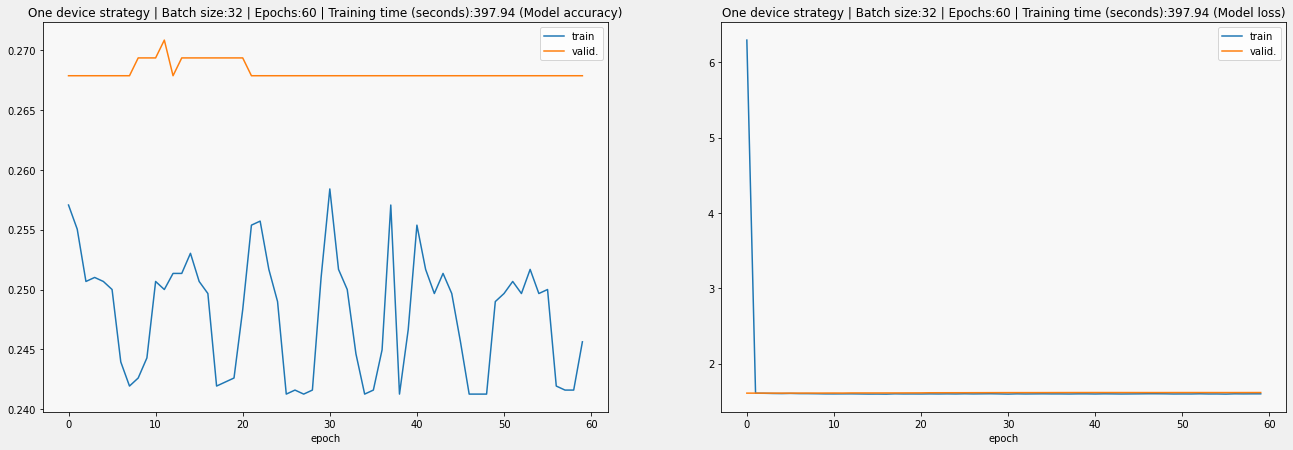

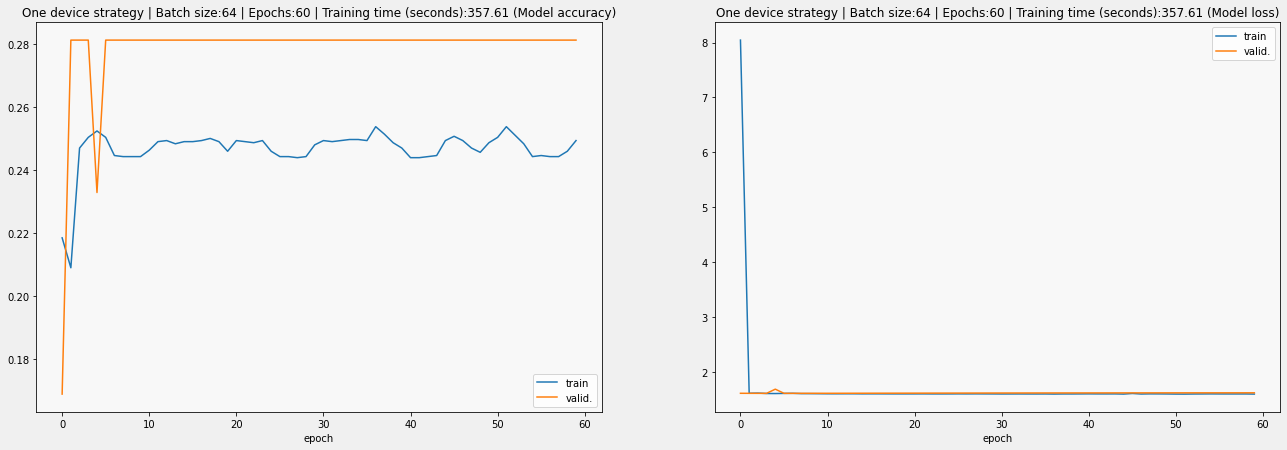

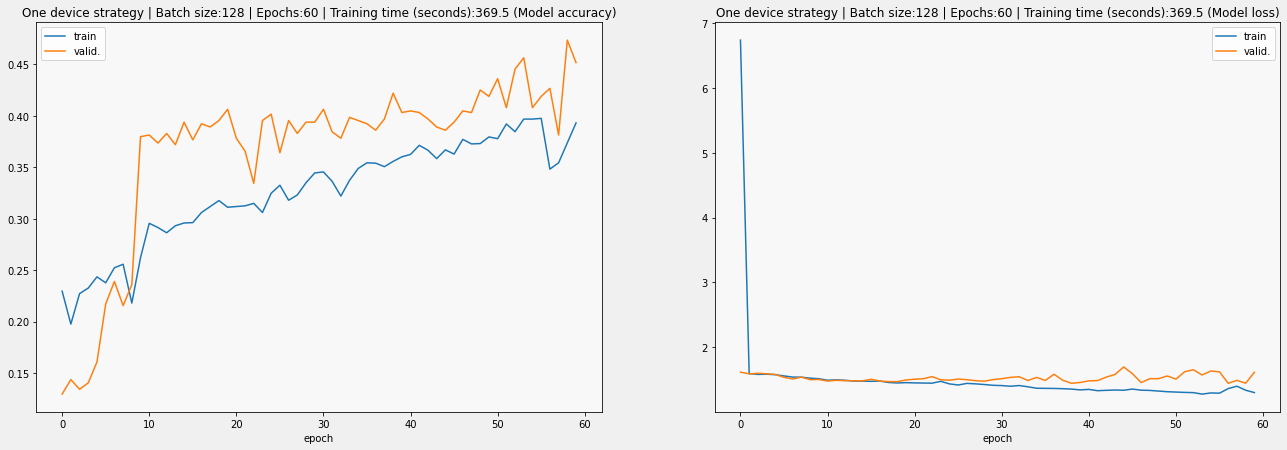

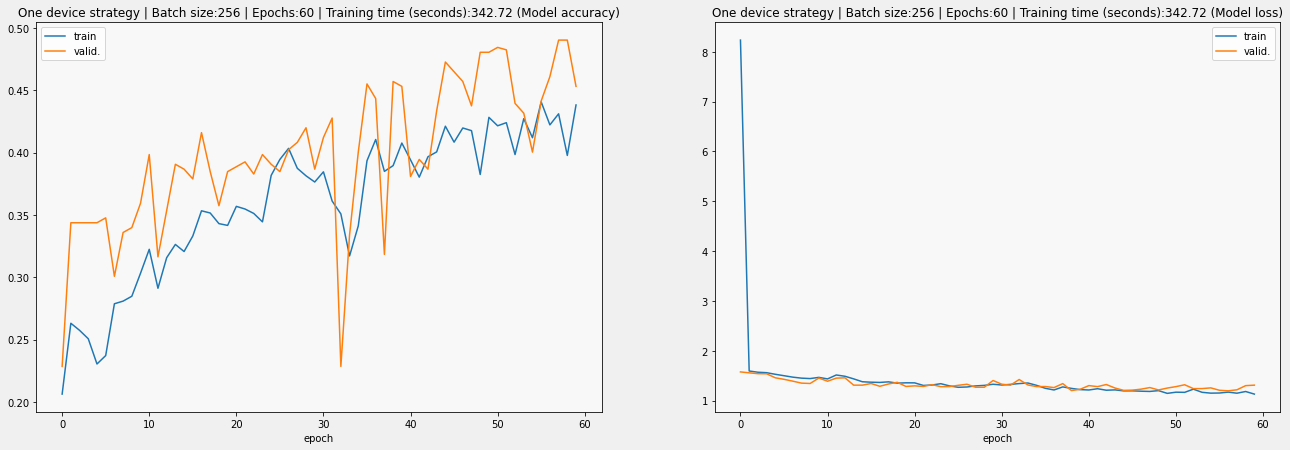

In [ ]:
### CODING TASK ### 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats 
import numpy as np

# Manually assignment of jobdir and filename for testing after the job was executed
# job_dir_onedevice = ['gs://big-data-cw-adbr327-storage/jobs/onedevice_strategy_training_bs32_210423_184557',
#  'gs://big-data-cw-adbr327-storage/jobs/onedevice_strategy_training_bs64_210423_185100',
#  'gs://big-data-cw-adbr327-storage/jobs/onedevice_strategy_training_bs128_210423_185603',
#  'gs://big-data-cw-adbr327-storage/jobs/onedevice_strategy_training_bs256_210423_190106']


# filename_onedevice = ['spark_job_history_onedevice_bs32_epochs60.pkl',
#  'spark_job_history_onedevice_bs64_epochs60.pkl',
#  'spark_job_history_onedevice_bs128_epochs60.pkl',
#  'spark_job_history_onedevice_bs256_epochs60.pkl']

i = 0
for jobdir in job_dir_onedevice:
    # Copy History file output to the local drive 
    FILENAME = filename_onedevice[i]
    full_path = jobdir + "/" + FILENAME
    print(full_path)
    %cd /content/drive/MyDrive/BD-CW
    !gsutil cp $full_path . 
    i+=1
#!ls -l


model_hist = [None] * len(filename_onedevice)

i = 0
for filename in filename_onedevice:
    with open('/content/drive/MyDrive/BD-CW/' + filename, mode='rb') as f:
        model_hist[i] = pickle.load(f) #[accuracy,val_accuracy] 
    display_training_curves(model_hist[i][0][1]['accuracy'], model_hist[i][0][1]['val_accuracy'], 
                         str(model_hist[i][0][0]['strategy']) + ' strategy' + ' | ' +
                         'Batch size:' + str(model_hist[i][0][0]['batch size']) + ' | ' +
                         'Epochs:' + str(model_hist[i][0][0]['epoch']) + ' | ' +
                         'Training time (seconds):' + str(round(model_hist[i][0][0]['training time'],2)) + ' (Model accuracy)', 121)
    display_training_curves(model_hist[i][0][1]['loss'], model_hist[i][0][1]['val_loss'], 
                         str(model_hist[i][0][0]['strategy']) + ' strategy' + ' | ' +
                         'Batch size:' + str(model_hist[i][0][0]['batch size']) + ' | ' +
                         'Epochs:' + str(model_hist[i][0][0]['epoch']) + ' | ' +
                         'Training time (seconds):' + str(round(model_hist[i][0][0]['training time'],2)) + ' (Model loss)', 122)

    i+=1

# #print(model_hist)
# model_hist1 = [s[0] for s in model_hist]
# model_hist2 = [{'val_accuracy':s[1]['val_accuracy'][0],'val_loss':s[1]['val_loss'][0]} for s in model_hist]

# for item1,item2 in zip(model_hist1,model_hist2):
#     item1.update( {'val_accuracy':item2['val_accuracy'],'val_loss':item2['val_loss']})

# df_4c = pd.DataFrame(model_hist1)
# df_4c

In [ ]:
a 

[[{'batch size': 128,
   'epoch': 60,
   'strategy': 'One device',
   'training time': 369.49576234817505,
   'val_accuracy': 0.12968750298023224,
   'val_loss': 1.613516092300415},
  {'accuracy': [0.229619562625885,
    0.1976902186870575,
    0.22724184393882751,
    0.23267662525177002,
    0.24354620277881622,
    0.23777173459529877,
    0.2523777186870575,
    0.25577446818351746,
    0.21807065606117249,
    0.26222825050354004,
    0.29551631212234497,
    0.2914402186870575,
    0.28634509444236755,
    0.2931385934352875,
    0.29585596919059753,
    0.2961956560611725,
    0.30604618787765503,
    0.3118206560611725,
    0.31759509444236755,
    0.31114131212234497,
    0.3118206560611725,
    0.3125,
    0.3148777186870575,
    0.30604618787765503,
    0.32472825050354004,
    0.33254075050354004,
    0.3179347813129425,
    0.32302990555763245,
    0.33491846919059753,
    0.3444293439388275,
    0.34544837474823,
    0.33627718687057495,
    0.32201087474823,
    0.337296

In [ ]:

a = model_hist[3]

#print(model_hist)
model_hist1 = [s[0] for s in a]
model_hist2 = [{'val_accuracy':s[1]['val_accuracy'][len(s[1]['val_accuracy'])-1],'val_loss':s[1]['val_loss'][len(s[1]['val_loss'])-1]} for s in a]

for item1,item2 in zip(model_hist1,model_hist2):
    item1.update( {'val_accuracy':item2['val_accuracy'],'val_loss':item2['val_loss']})

df_4a = pd.DataFrame(model_hist1)
df_4a

strategy  batch size  epoch  training time  val_accuracy  val_loss
0  One device         256     60     342.716976      0.453125   1.31029

# **4cii) Mirrored Strategy**

In [ ]:
strategy = tf.distribute.MirroredStrategy()



INFO:tensorflow:Initializing local devices since in-graph multi-worker training with `MirroredStrategy` is not supported in eager mode. TF_CONFIG will be ignored when when initializing `MirroredStrategy`.


INFO:tensorflow:Initializing local devices since in-graph multi-worker training with `MirroredStrategy` is not supported in eager mode. TF_CONFIG will be ignored when when initializing `MirroredStrategy`.


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


INFO:tensorflow:Using MirroredStrategy with devices ('/job:localhost/replica:0/task:0/device:CPU:0',)


Number of devices: 1


In [ ]:
### CODING TASK ### 

%%writefile trainer/mirrored_strategy.py


import os
import json
# Pyspark not used
#import pyspark
from trainer import task4_model
import sys
import argparse
import pickle 
import time
import tensorflow as tf
import keras


def task4c_main(argv):
  
    #out_file = 'spark_job_output_history_task4c.pkl'
    #print(argv)
    parser = argparse.ArgumentParser() # get a parser object
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The filename for the result.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    parser.add_argument('--batch_size', metavar='batch_size', required=True,
                        help='The batch_size for the result.') # add a required argument
    parser.add_argument('--epochs', metavar='epochs', required=True,
                        help='The epochs for the result.') # add a required argument
    parser.add_argument('--job-dir', metavar='job_dir', required=True,
                    help='The bucket URL for the result.') # add a required argument


    args = parser.parse_args(argv)
    print(args.job_dir)
    
    max_epochs = int(float(args.epochs))
    batch_size = int(float(args.batch_size))

    # No devices are specified in the constructor argument of the strategy then it will use all the available GPUs
    mirrored_strategy = tf.distribute.MirroredStrategy()
    #mw_mirrored_strategy = tf.distribute.MultiWorkerMirroredStrategy()
    #strategies_iterator = [mirrored_strategy,mw_mirrored_strategy,onedevice_strategy]
    
    print('Number of devices: {}'.format(mirrored_strategy.num_replicas_in_sync))

    # This part is an adaptation of the original code in 
    # https://colab.research.google.com/github/tensorflow/docs/blob/master/site/en/tutorials/distribute/keras.ipynb#scrollTo=xHxb-dlhMIzW

    # When training a model with multiple GPUs, you can use the extra computing power effectively by increasing the batch size. 
    # In general, use the largest batch size that fits the GPU memory, and tune the learning rate accordingly.


    BATCH_SIZE_PER_REPLICA = batch_size
    # We define a constant global batch size to be divided for each replica
    GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA
    #GLOBAL_BATCH_SIZE = BATCH_SIZE_PER_REPLICA * mirrored_strategy.num_replicas_in_sync

    training_dataset,validation_dataset,validation_steps,steps_per_epoch = task4_model.tfr_dataset(GLOBAL_BATCH_SIZE)
   

    with mirrored_strategy.scope():
            # Model building/compiling need to be within `strategy.scope()`.
            model = task4_model.build_and_compile()

    # Initialize list of scores 
    scores = []    

    tt0 = time.time() 
    history = model.fit(training_dataset,
            epochs=max_epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_dataset, 
            validation_steps=validation_steps)
    scores.append([{'strategy':'Mirrored','batch size':batch_size,'epoch':max_epochs,'training time':time.time()-tt0},history.history])


    tt1 = time.time()
    print('Directory:',args.job_dir)
    print('Time elapsed:',tt1-tt0)
    
    # Save model
    tf.saved_model.save(model, args.job_dir + '/trainer')
    task4_model.save(scores,args.job_dir,args.out_file)


if  'google.colab' not in sys.modules: # Don't use system arguments run in Colab 
    task4c_main(sys.argv[1:])  
elif __name__ == "__main__" : # but define them manually
    task4c(['--out_bucket','out_bucket','--out_file','out_file','--batch_size','batch_size','--epochs','epochs','--job-dir', 'job_dir'])

Overwriting trainer/mirrored_strategy.py


Now we submit the training job to the AI-Platform

## **1) We define the training run using the training configuration to use multiple GPUs to the AI-Platform and run a iterative training for multiple batch size values at once**

In [ ]:
# %%writefile trainer/config.yaml
# trainingInput:
#     runtimeVersion: "2.4"
#     pythonVersion: "3.7"
#     scaleTier: CUSTOM
#     # We configure the master without a GPU
#     masterType: complex_model_m
#     workerType: complex_model_m_gpu
#     workerCount: 1
#     parameterServerType: large_model
#     parameterServerCount: 2

Overwriting trainer/config.yaml


In [ ]:
import datetime 

# Define batch size and epochs parameters values
#batch_sizes = "16 32"
#epochs = "5 10"

# Define batch size and epochs parameters values for training iteration
batch_sizes = [64,128,256,512]
epochs = 60

filename_mirrored = []
job_dir_mirrored = []

for batch_size in batch_sizes:
    
    FILENAME= 'spark_job_history_mirrored_bs' + str(batch_size) + '_epochs' + str(epochs) + '.pkl'
    TRAINER_PACKAGE_PATH="trainer"
    MAIN_TRAINER_MODULE="trainer.mirrored_strategy"
    PACKAGE_STAGING_PATH=BUCKET
    JOB_NAME="mirrored_strategy_training_bs" + str(batch_size) + "_" + str(datetime.datetime.now().strftime("%y%m%d_%H%M%S")) # you need a new job name for every run
    JOB_DIR_MIRRORED=BUCKET+'/jobs/'+JOB_NAME
    PYTHON_VERSION="3.7"
    RUNTIME_VERSION="2.4"

    filename_mirrored.append(FILENAME)
    job_dir_mirrored.append(JOB_DIR_MIRRORED)

    !gcloud ai-platform jobs submit training $JOB_NAME \
            --package-path $TRAINER_PACKAGE_PATH \
            --module-name $MAIN_TRAINER_MODULE \
            --job-dir $JOB_DIR_MIRRORED \
            --python-version $PYTHON_VERSION \
            --runtime-version $RUNTIME_VERSION \
            --region $REGION \
            --scale-tier custom \
            --master-machine-type n1-standard-8 \
            --master-accelerator count=8,type=nvidia-tesla-k80 \
            --parameter-server-machine-type n1-standard-8 \
            --parameter-server-count 3 \
            -- --out_bucket $BUCKET \
            --out_file $FILENAME \
            --batch_size $batch_size \
            --epochs $epochs \

    # Here we allow for 5 minutes between launching each new job        
    time.sleep(300)

            # --config trainer/config.yaml \

Job [mirrored_strategy_training_bs64_210423_194443] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe mirrored_strategy_training_bs64_210423_194443

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs mirrored_strategy_training_bs64_210423_194443
jobId: mirrored_strategy_training_bs64_210423_194443
state: QUEUED
Job [mirrored_strategy_training_bs128_210423_194946] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe mirrored_strategy_training_bs128_210423_194946

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs mirrored_strategy_training_bs128_210423_194946
jobId: mirrored_strategy_training_bs128_210423_194946
state: QUEUED
Job [mirrored_strategy_training_bs256_210423_195448] submitted successfully.
Your job is still active. You may v

## 2) Now we test the output files generated by the Mirrored strategy

gs://big-data-cw-adbr327-storage/jobs/mirrored_strategy_training_bs64_210423_194443/spark_job_history_mirrored_bs64_epochs60.pkl
/content/drive/MyDrive/BD-CW
Copying gs://big-data-cw-adbr327-storage/jobs/mirrored_strategy_training_bs64_210423_194443/spark_job_history_mirrored_bs64_epochs60.pkl...
/ [1 files][  2.3 KiB/  2.3 KiB]                                                
Operation completed over 1 objects/2.3 KiB.                                      
gs://big-data-cw-adbr327-storage/jobs/mirrored_strategy_training_bs128_210423_194946/spark_job_history_mirrored_bs128_epochs60.pkl
/content/drive/MyDrive/BD-CW
Copying gs://big-data-cw-adbr327-storage/jobs/mirrored_strategy_training_bs128_210423_194946/spark_job_history_mirrored_bs128_epochs60.pkl...
/ [1 files][  2.3 KiB/  2.3 KiB]                                                
Operation completed over 1 objects/2.3 KiB.                                      
gs://big-data-cw-adbr327-storage/jobs/mirrored_strategy_training_bs256_210

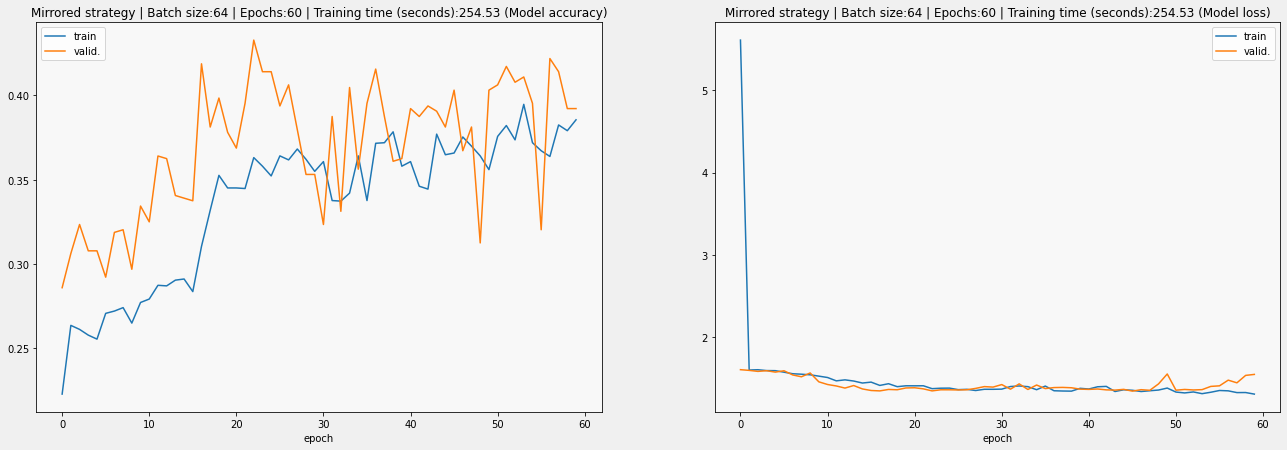

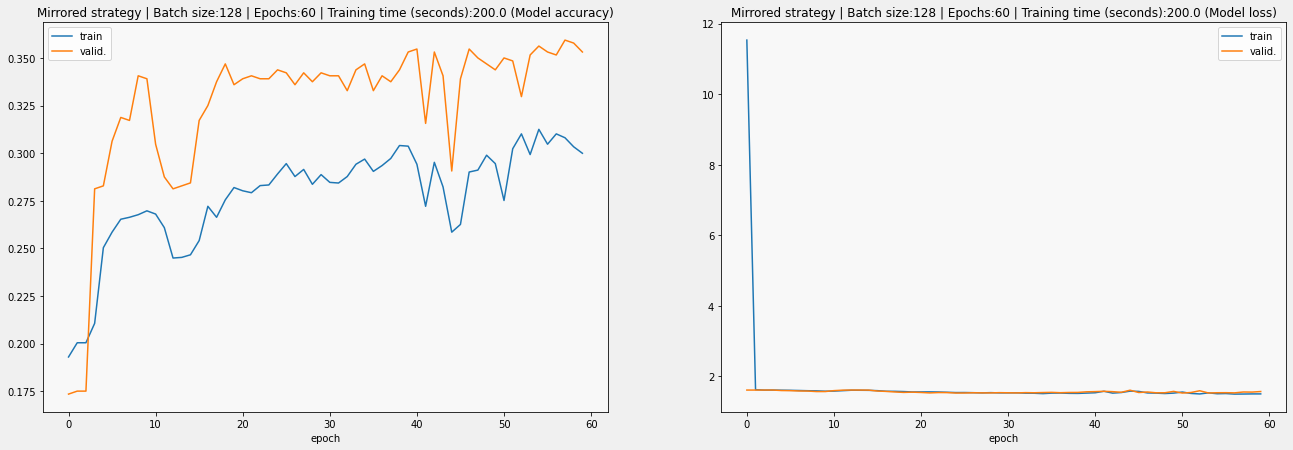

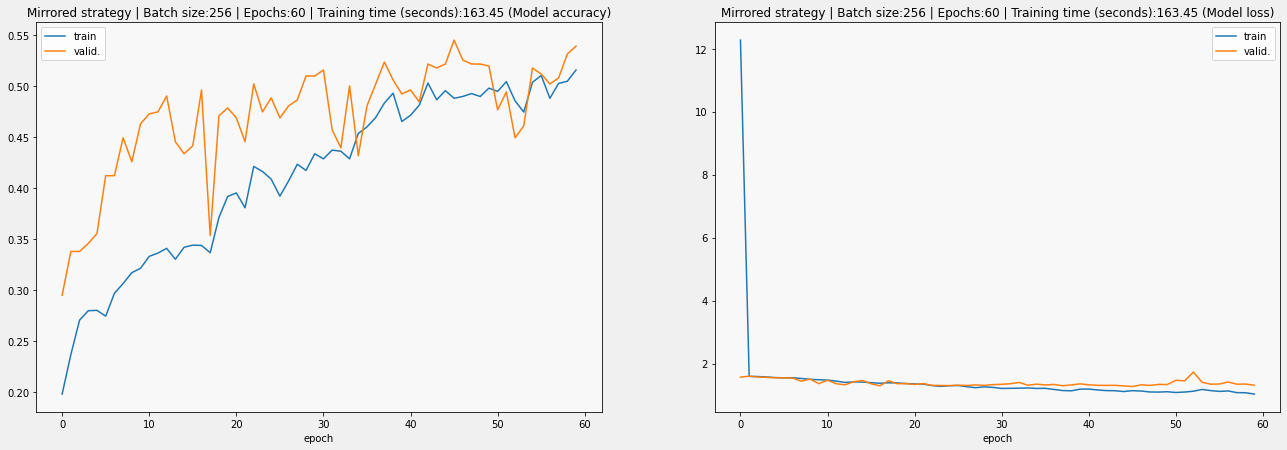

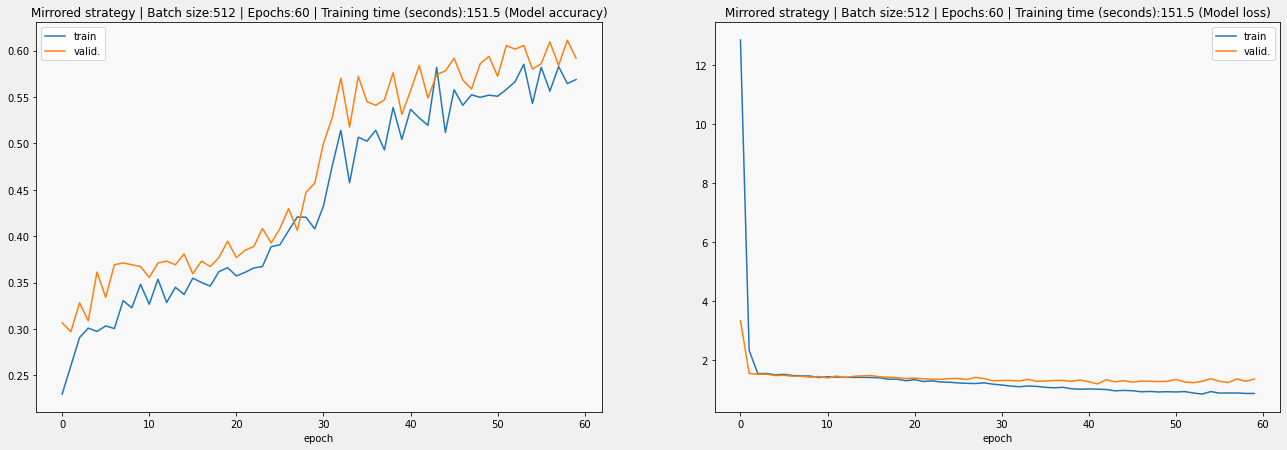

In [16]:
### CODING TASK ### 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats 
from sklearn.linear_model import LinearRegression
import numpy as np


# Manually assignment of jobdir and filename for testing after the job was executed
job_dir_mirrored = ['gs://big-data-cw-adbr327-storage/jobs/mirrored_strategy_training_bs64_210423_194443',
 'gs://big-data-cw-adbr327-storage/jobs/mirrored_strategy_training_bs128_210423_194946',
 'gs://big-data-cw-adbr327-storage/jobs/mirrored_strategy_training_bs256_210423_195448',
 'gs://big-data-cw-adbr327-storage/jobs/mirrored_strategy_training_bs512_210423_195951']


filename_mirrored = ['spark_job_history_mirrored_bs64_epochs60.pkl',
 'spark_job_history_mirrored_bs128_epochs60.pkl',
 'spark_job_history_mirrored_bs256_epochs60.pkl',
 'spark_job_history_mirrored_bs512_epochs60.pkl']

i = 0
for jobdir in job_dir_mirrored:
    # Copy History file output to the local drive 
    FILENAME = filename_mirrored[i]
    full_path = jobdir + "/" + FILENAME
    print(full_path)
    %cd /content/drive/MyDrive/BD-CW
    !gsutil cp $full_path . 
    i+=1
#!ls -l


model_hist = [None] * len(filename_mirrored)

i = 0
for filename in filename_mirrored:
    with open('/content/drive/MyDrive/BD-CW/' + filename, mode='rb') as f:
        model_hist[i] = pickle.load(f) #[accuracy,val_accuracy] 
    # if 'val_accuracy' in model_hist[i][0][1]:
    #     accuracy = 'val_accuracy'
    #     loss = 'val_loss'
    # else:
    #     accuracy = 'accuracy'
    #     loss = 'loss'

    display_training_curves(model_hist[i][0][1]['accuracy'], model_hist[i][0][1]['val_accuracy'],
                         str(model_hist[i][0][0]['strategy']) + ' strategy' + ' | ' +
                         'Batch size:' + str(model_hist[i][0][0]['batch size']) + ' | ' +
                         'Epochs:' + str(model_hist[i][0][0]['epoch']) + ' | ' +
                         'Training time (seconds):' + str(round(model_hist[i][0][0]['training time'],2)) + ' (Model accuracy)', 121)
    display_training_curves(model_hist[i][0][1]['loss'], model_hist[i][0][1]['val_loss'],
                         str(model_hist[i][0][0]['strategy']) + ' strategy' + ' | ' +
                         'Batch size:' + str(model_hist[i][0][0]['batch size']) + ' | ' +
                         'Epochs:' + str(model_hist[i][0][0]['epoch']) + ' | ' +
                         'Training time (seconds):' + str(round(model_hist[i][0][0]['training time'],2)) + ' (Model loss)', 122)

    i+=1



In [20]:

a = model_hist[3]

#print(model_hist)
model_hist1 = [s[0] for s in a]
model_hist2 = [{'val_accuracy':s[1]['val_accuracy'][len(s[1]['val_accuracy'])-1],'val_loss':s[1]['val_loss'][len(s[1]['val_loss'])-1]} for s in a]

for item1,item2 in zip(model_hist1,model_hist2):
    item1.update( {'val_accuracy':item2['val_accuracy'],'val_loss':item2['val_loss']})

df_4c = pd.DataFrame(model_hist1)
df_4c

strategy  batch size  epoch  training time  val_accuracy  val_loss
0  Mirrored         512     60     151.499459      0.591797  1.355762

>> # **4ciii) Multi-WorkerMirrored Strategy**

## **1) We define the training run using the training configuration to use multiple GPUs to the AI-Platform and run a iterative training for multiple batch size values at once**

In [180]:
### CODING TASK ### 
%%writefile trainer/mwmirrored_strategy.py


import os
import json
import subprocess
#from trainer import task4_model
import sys
import argparse
import pickle 
import time
import tensorflow as tf


GCS_TFR_PATTERN = 'gs://big-data-cw-adbr327-storage/tfrecords-jpeg-192x192-2/flowers*.tfrec' 
AUTO = tf.data.experimental.AUTOTUNE

#BATCH_SIZE = 64 
#BATCH_SIZE = 64 # this is a good setting for the Colab GPU (K80) 
#BATCH_SIZE = 128 # works on newer GPUs with more memory (available on GCS AI-Platform) 
#EPOCHS = 5 # 5 is for testing. Increase later
#LEARNING_RATE = learning_rate
TARGET_SIZE = [192,192]

# Here we decided to change to allow more data to the training set
VALIDATION_SPLIT = 0.20
#VALIDATION_SPLIT = 0.25

CLASSES = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'] # maps class numbers to labels strings
SAMPLE_NUM=3670 # size of the Flowers dataset, change as appropriate for smaller samples/different datasets

def save(object,bucket,filename):
    with open(filename,mode='wb') as f:
        pickle.dump(object,f)
    print("Saving {} to {}".format(filename,bucket))
    import subprocess
    proc = subprocess.run(["gsutil","cp", filename, bucket],stderr=subprocess.PIPE)
    print("gstuil returned: " + str(proc.returncode))
    print(str(proc.stderr))

def read_tfrecord(example):
    features = {
        "image": tf.io.FixedLenFeature([], tf.string),  # tf.string = bytestring (not text string)
        "class": tf.io.FixedLenFeature([], tf.int64) #,   # shape [] means scalar
    }
    # decode the TFRecord
    example = tf.io.parse_single_example(example, features)
    image = tf.image.decode_jpeg(example['image'], channels=3)
    image = tf.reshape(image, [*TARGET_SIZE, 3])    
    class_num = example['class']
    return image, class_num 

def load_dataset(filenames):
    # read from TFRecords. For optimal performance, read from multiple    
    # TFRecord files at once and set the option experimental_deterministic = False
    # to allow order-altering optimizations.
    option_no_order = tf.data.Options()
    option_no_order.experimental_deterministic = False

    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTO)
    dataset = dataset.with_options(option_no_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTO)
    return dataset

def get_batched_dataset(filenames, batch_size, train=False):
    dataset = load_dataset(filenames)
    dataset = dataset.cache() # This dataset fits in RAM
    if train:
    # Best practices for Keras:
    # Training dataset: repeat then batch
    # Evaluation dataset: do not repeat
        dataset = dataset.repeat()
    dataset = dataset.batch(batch_size)
    
    # Rebatching the dataset has a space complexity that increases linearly with the number of replicas. 
    # This means that for the multi worker training use case the input pipeline can run into OOM errors.
    # Sharding implementation (autoshards the input dataset in multi worker training with MultiWorkerMirroredStrategy and TPUStrategy)
    # Therefore, each dataset is created on the CPU device of the worker. 
    # Autosharding a dataset over a set of workers means that each worker is assigned a subset of the entire dataset 
    # This is to ensure that at each step, a global batch size of non overlapping dataset elements will be processed by each worker.
    options = tf.data.Options()
    options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.DATA
    dataset = dataset.with_options(options)

    dataset = dataset.prefetch(AUTO) # prefetch next batch while training (autotune prefetch buffer size)
    # should shuffle too but this dataset was well shuffled on disk already
    return dataset
    # source: Dataset performance guide: https://www.tensorflow.org/guide/performance/datasets

def tfr_dataset(batch_size):
    # splitting data files between training and validation
    filenames = tf.io.gfile.glob(GCS_TFR_PATTERN)
    print("len(filenames): "+str(len(filenames)))
    split = int(len(filenames) * VALIDATION_SPLIT)
    training_filenames = filenames[split:]
    validation_filenames = filenames[:split]
    print("Pattern matches {} data files. Splitting dataset into {} training files and {} validation files".format(len(filenames), len(training_filenames), len(validation_filenames)))
    validation_steps = int(SAMPLE_NUM // len(filenames) * len(validation_filenames)) // batch_size
    steps_per_epoch = int(SAMPLE_NUM // len(filenames) * len(training_filenames)) // batch_size

    # instantiate the datasets
    training_dataset = get_batched_dataset(training_filenames, batch_size, train=True)
    validation_dataset = get_batched_dataset(validation_filenames, batch_size, train=False)
    return training_dataset,validation_dataset,validation_steps,steps_per_epoch

def build_and_compile():
    
    pretrained_model = tf.keras.applications.MobileNetV2(input_shape=[*TARGET_SIZE, 3], include_top=False)
    pretrained_model.trainable = False

    model = tf.keras.Sequential([
        pretrained_model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100,activation='relu'),
        tf.keras.layers.Dropout(.5),
        tf.keras.layers.Dense(5, activation='softmax')
    ])

    # Compile model and optimize
    model.compile(
        optimizer='adam',
        loss = 'sparse_categorical_crossentropy',
        metrics=['accuracy'])
        #,lr=learning_rate)
    
    return model

def _is_chief(task_type, task_id):
    # Note: there are two possible `TF_CONFIG` configuration.
    #   1) In addition to `worker` tasks, a `chief` task type is use;
    #      in this case, this function should be modified to 
    #      `return task_type == 'chief'`.
    #   2) Only `worker` task type is used; in this case, worker 0 is
    #      regarded as the chief. The implementation demonstrated here
    #      is for this case.
    # For the purpose of this colab section, we also add `task_type is None` 
    # case because it is effectively run with only single worker.
    return (task_type == 'worker' and task_id == 0) or task_type is None

def _get_temp_dir(dirpath, task_id):
    base_dirpath = 'workertemp_' + str(task_id)
    temp_dir = os.path.join(dirpath, base_dirpath)
    tf.io.gfile.makedirs(temp_dir)
    return temp_dir

def write_filepath(filepath, task_type, task_id):
    dirpath = os.path.dirname(filepath)
    base = os.path.basename(filepath)
    if not _is_chief(task_type, task_id):
        dirpath = _get_temp_dir(dirpath, task_id)
    return os.path.join(dirpath, base)


def task4c(argv):
    parser = argparse.ArgumentParser() # get a parser object
        
    parser.add_argument('--out_bucket', metavar='out_bucket', required=True,
                        help='The filename for the bucket path.') # add a required argument
    parser.add_argument('--out_file', metavar='out_file', required=True,
                        help='The filename for the result.') # add a required argument
    # parser.add_argument('--model_dir', metavar='model_dir', required=True,
    #                     help='The model path for saving the result.') # add a required argument
    parser.add_argument('--batch_size', metavar='batch_size', required=True,
                        help='The batch_size for the result.') # add a required argument
    parser.add_argument('--epochs', metavar='epochs', required=True,
                        help='The epochs for the result.') # add a required argument
    parser.add_argument('--job-dir', metavar='job_dir', required=True,
                    help='The bucket URL for the result.') # add a required argument

    args = parser.parse_args(argv)
    #print(args.job_dir)

    # Assign batch size and epochs to variables
    
    max_epochs = int(float(args.epochs))
    batch_size = int(float(args.batch_size))

    # No devices are specified in the constructor argument of the strategy then it will use all the available GPUs
    #mirrored_strategy = tf.distribute.MirroredStrategy()
    # communication_options = tf.distribute.experimental.CommunicationOptions(
    #                     implementation=tf.distribute.experimental.CommunicationImplementation.NCCL) communication_options=communication_options
    mw_mirrored_strategy = tf.distribute.MultiWorkerMirroredStrategy()

    nr_of_replicas = mw_mirrored_strategy.num_replicas_in_sync
    print(nr_of_replicas)

    # # Define epochs and batch sizes for the algorithm    
    # # epochs = [5, 10, 15, 20, 25]
    # # batch_sizes = [16, 32, 64]

 
    # Open a MultiWorkerMirroredStrategy scope and communicate Tensorflow we are using the distributed strategy to build/compile the model.
    with mw_mirrored_strategy.scope():
        # Model building/compiling need to be within `strategy.scope()`.
        multi_worker_model = build_and_compile()

    
    # In multi-worker training, dataset sharding is needed to ensure convergence and performance.
    # Although not recommended we turn OFF the auto sharding, so each replica processes every example.
    # options = tf.data.Options()
    # options.experimental_distribute.auto_shard_policy = tf.data.experimental.AutoShardPolicy.OFF

    # Define global batch size and determine training/validation based on the total batch size for all replicas (global batch size)
    #global_batch_size = int(nr_of_replicas) * batch_size
    global_batch_size = batch_size
    training_dataset,validation_dataset,validation_steps,steps_per_epoch = tfr_dataset(global_batch_size)

    #training_dataset_no_auto_shard = training_dataset.with_options(options)
    #validation_dataset_no_auto_shard = validation_dataset.with_options(options)
 
    # Initialize training time at the beginning
    tt1 = time.time()
    
    # Initialize list of scores 
    scores = []

    # Model training and scoring
    history = multi_worker_model.fit(training_dataset,
            epochs=max_epochs,
            steps_per_epoch=steps_per_epoch,
            validation_data=validation_dataset, 
            validation_steps=validation_steps)

    scores.append([{'strategy':'MW-Mirrored','batch size':batch_size,'epochs':max_epochs,'training time':time.time()-tt1},history.history])
    print('Time elapsed:',time.time()-tt1)
    

    # Save model
    model_path = args.job_dir + '/trainer'
    task_type, task_id = (mw_mirrored_strategy.cluster_resolver.task_type,
                          mw_mirrored_strategy.cluster_resolver.task_id)
    write_model_path = write_filepath(model_path, task_type, task_id)
    #multi_worker_model.save(write_model_path, save_format='tf')
    tf.saved_model.save(multi_worker_model, write_model_path)

    # Remove temporary files from worker folders that are not master
    if not _is_chief(task_type, task_id):
        tf.io.gfile.rmtree(os.path.dirname(write_model_path))

    # Save history
    save(scores,args.job_dir,args.out_file)

if  'google.colab' not in sys.modules: # Don't use system arguments run in Colab 
    task4c(sys.argv[1:])  
elif __name__ == "__main__" : # but define them manually
    task4c(['--out_bucket','out_bucket','--out_file','out_file','--batch_size','batch_size','--epochs','epochs','--job-dir', 'job_dir'])

 

Overwriting trainer/mwmirrored_strategy.py


**Perform local training to validate the model.**

In [ ]:
import datetime 

FILENAME="spark_job_output_history_task4c.pkl"
TRAINER_PACKAGE_PATH="trainer"
MAIN_TRAINER_MODULE="trainer.mwmirrored_strategy"
PACKAGE_STAGING_PATH=BUCKET
JOB_NAME="mwmirrored_strategy_training_"+ str(datetime.datetime.now().strftime("%y%m%d_%H%M%S")) # you need a new job name for every run
JOB_DIR_MWMIRRORED=BUCKET+'/jobs/'+JOB_NAME
PYTHON_VERSION="3.7"
RUNTIME_VERSION="2.4"

!gcloud ai-platform local train \
        --package-path $TRAINER_PACKAGE_PATH \
        --module-name $MAIN_TRAINER_MODULE \
        --configuration standard_gpu \
        -- --out_bucket $BUCKET --out_file $FILENAME --job-dir $JOB_DIR_MWMIRRORED \
        #--parameter-server-count 3 \
        #--region $REGION \
        #--master-machine-type n1-highcpu-16 \
        #--master-accelerator count=4,type=nvidia-tesla-k80 \
        #--worker-machine-type n1-highcpu-16 \
        #--worker-accelerator count=4,type=nvidia-tesla-k80 \
        #--parameter-server-machine-type n1-highmem-8 \
        #--python-version $PYTHON_VERSION \
        #--runtime-version $RUNTIME_VERSION \

        # --scale-tier custom \
        # --master-machine-type standard_gpu \

2021-04-20 15:36:25.544118: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.11.0
gs://big-data-cw-adbr327-storage/jobs/mwmirrored_strategy_training_210420_153618
2021-04-20 15:36:28.046051: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-04-20 15:36:28.046906: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2021-04-20 15:36:28.061054: E tensorflow/stream_executor/cuda/cuda_driver.cc:328] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2021-04-20 15:36:28.061121: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (bde630d7a7d8): /proc/driver/nvidia/version does not exist
2021-04-20 15:36:28.061777: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not

Now we will define a config.yaml file to append the configurations to the cluster and run the training in Google AI-Platform.

In [187]:
%%writefile trainer/config.yaml
trainingInput:
    runtimeVersion: "2.4"
    pythonVersion: "3.7"
    scaleTier: CUSTOM
    masterType: standard_gpu
    workerType: standard_gpu
    workerCount: 9
    scheduling:
        maxWaitTime: 3600s
        maxRunningTime: 7200s

Overwriting trainer/config.yaml


In [188]:
import datetime 



# Define batch size and epochs parameters values
batch_sizes = [64,128,256,512]
epochs = 60

filename_mwmirrored = []
job_dir_mwmirrored = []


for batch_size in batch_sizes:
    
    FILENAME= 'spark_job_history_mwmirrored_bs' + str(batch_size) + '_epochs' + str(epochs) + '.pkl'
    TRAINER_PACKAGE_PATH="trainer"
    MAIN_TRAINER_MODULE="trainer.mwmirrored_strategy"
    PACKAGE_STAGING_PATH=BUCKET
    JOB_NAME="mwmirrored_strategy_training_bs" + str(batch_size) + "_" + str(datetime.datetime.now().strftime("%y%m%d_%H%M%S")) # you need a new job name for every run
    JOB_DIR_MWMIRRORED=BUCKET+'/jobs/'+JOB_NAME
    #MODEL_DIR_MWMIRRORED=BUCKET+'/mwmirrored_model/'+JOB_NAME
    PYTHON_VERSION="3.7"
    RUNTIME_VERSION="2.4"

    filename_mwmirrored.append(FILENAME)
    job_dir_mwmirrored.append(JOB_DIR_MWMIRRORED)

    !gcloud ai-platform jobs submit training $JOB_NAME \
            --package-path $TRAINER_PACKAGE_PATH \
            --module-name $MAIN_TRAINER_MODULE \
            --region $REGION \
            --config trainer/config.yaml \
            --job-dir $JOB_DIR_MWMIRRORED \
            -- --out_bucket $BUCKET \
            --out_file $FILENAME \
            --batch_size $batch_size \
            --epochs $epochs \

    time.sleep(480)

    # --config trainer/config.yaml \
    # --scale-tier custom \
    # --master-machine-type n1-highmem-4 \
    # --worker-machine-type n1-highmem-4 \
    # --worker-count 4 \
    # --parameter-server-machine-type n1-highmem-4 \
    # --parameter-server-count 3 \
    # --python-version $PYTHON_VERSION \
    # --runtime-version $RUNTIME_VERSION \
    #--staging-bucket $BUCKET 

Job [mwmirrored_strategy_training_bs64_210423_230719] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe mwmirrored_strategy_training_bs64_210423_230719

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs mwmirrored_strategy_training_bs64_210423_230719
jobId: mwmirrored_strategy_training_bs64_210423_230719
state: QUEUED
Job [mwmirrored_strategy_training_bs128_210423_231522] submitted successfully.
Your job is still active. You may view the status of your job with the command

  $ gcloud ai-platform jobs describe mwmirrored_strategy_training_bs128_210423_231522

or continue streaming the logs with the command

  $ gcloud ai-platform jobs stream-logs mwmirrored_strategy_training_bs128_210423_231522
jobId: mwmirrored_strategy_training_bs128_210423_231522
state: QUEUED
Job [mwmirrored_strategy_training_bs256_210423_232325] submitted successfully.
Your job is still

## 2) Now we test the output files generated by the Multi-worker Mirrored strategy

In [ ]:
 mwmirrored_strategy_training_bs64_210423_230719

gs://big-data-cw-adbr327-storage/jobs/mwmirrored_strategy_training_bs64_210423_230719/spark_job_history_mwmirrored_bs64_epochs60.pkl
/content/drive/MyDrive/BD-CW
Copying gs://big-data-cw-adbr327-storage/jobs/mwmirrored_strategy_training_bs64_210423_230719/spark_job_history_mwmirrored_bs64_epochs60.pkl...
/ [1 files][  2.3 KiB/  2.3 KiB]                                                
Operation completed over 1 objects/2.3 KiB.                                      
gs://big-data-cw-adbr327-storage/jobs/mwmirrored_strategy_training_bs128_210423_231522/spark_job_history_mwmirrored_bs128_epochs60.pkl
/content/drive/MyDrive/BD-CW
Copying gs://big-data-cw-adbr327-storage/jobs/mwmirrored_strategy_training_bs128_210423_231522/spark_job_history_mwmirrored_bs128_epochs60.pkl...
/ [1 files][  2.3 KiB/  2.3 KiB]                                                
Operation completed over 1 objects/2.3 KiB.                                      
gs://big-data-cw-adbr327-storage/jobs/mwmirrored_strategy_

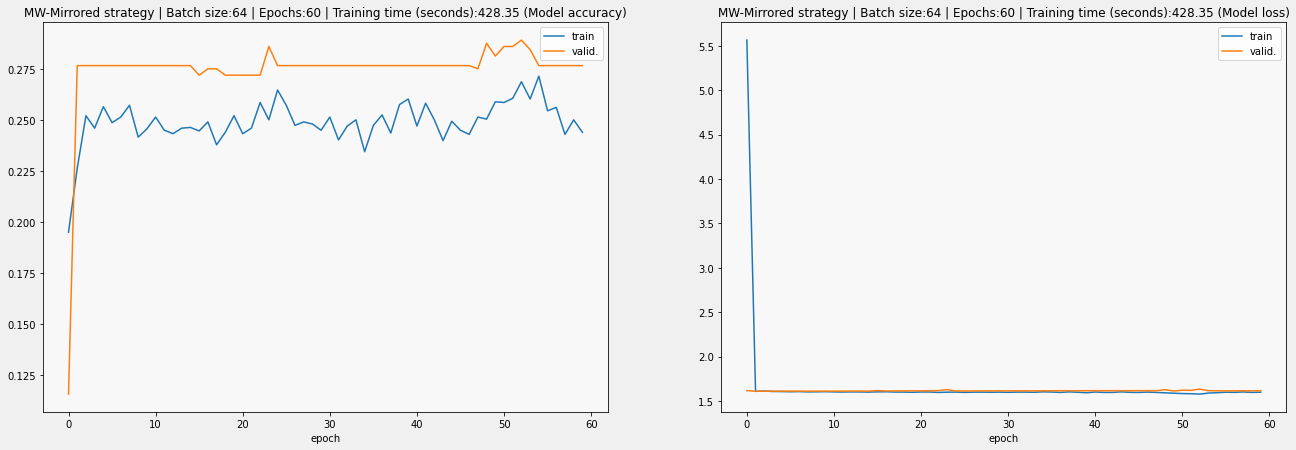

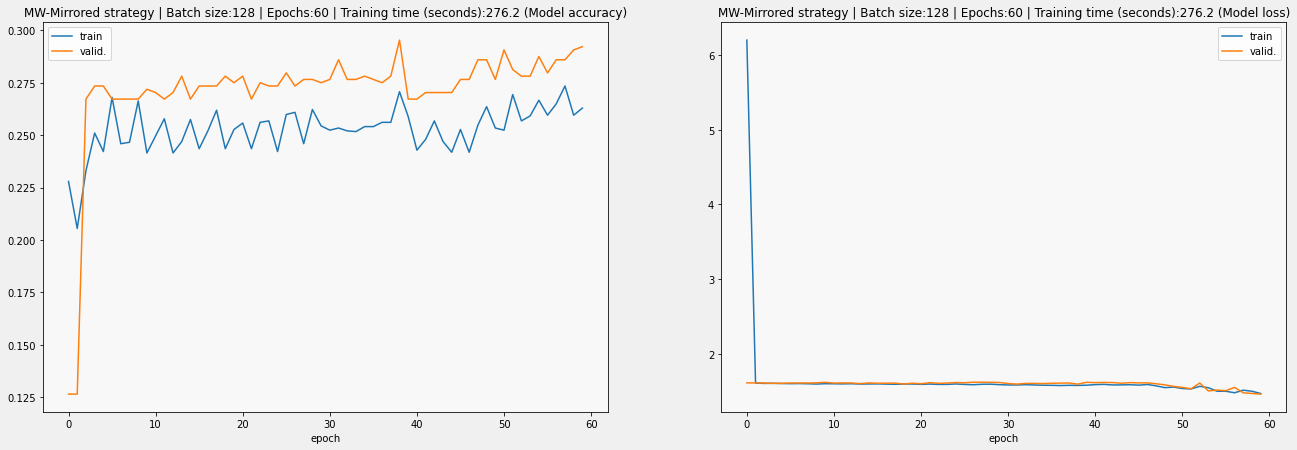

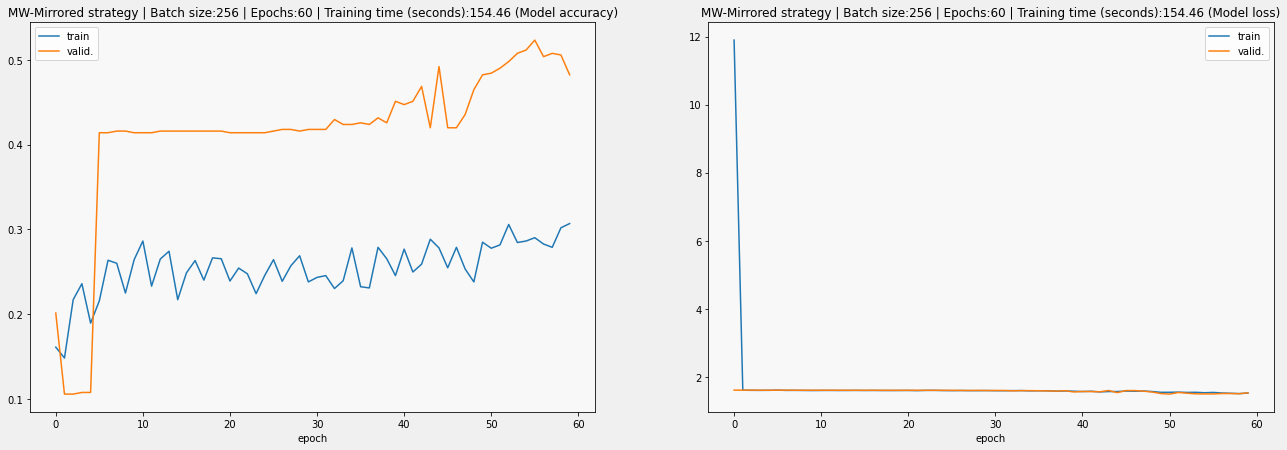

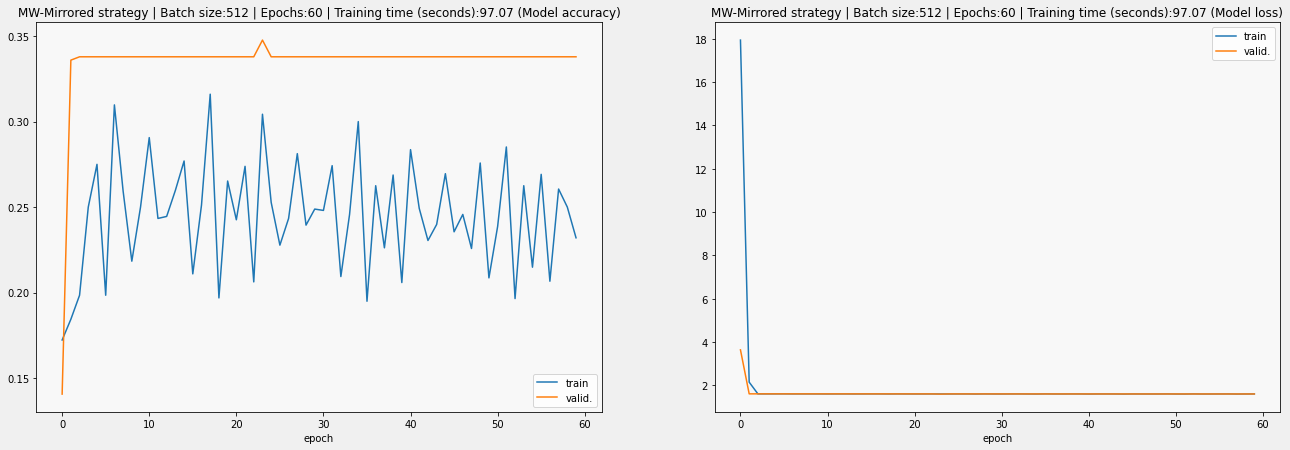

In [11]:
### CODING TASK ### 
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats 
from sklearn.linear_model import LinearRegression
import numpy as np


# Manually assignment of jobdir and filename for testing after the job was executed
job_dir_mwmirrored = ['gs://big-data-cw-adbr327-storage/jobs/mwmirrored_strategy_training_bs64_210423_230719',
                      'gs://big-data-cw-adbr327-storage/jobs/mwmirrored_strategy_training_bs128_210423_231522',
                      'gs://big-data-cw-adbr327-storage/jobs/mwmirrored_strategy_training_bs256_210423_232325',
                      'gs://big-data-cw-adbr327-storage/jobs/mwmirrored_strategy_training_bs512_210423_233128']


filename_mwmirrored = ['spark_job_history_mwmirrored_bs64_epochs60.pkl',
                       'spark_job_history_mwmirrored_bs128_epochs60.pkl',
                       'spark_job_history_mwmirrored_bs256_epochs60.pkl',
                       'spark_job_history_mwmirrored_bs512_epochs60.pkl']

i = 0
for jobdir in job_dir_mwmirrored:
    # Copy History file output to the local drive 
    FILENAME = filename_mwmirrored[i]
    full_path = jobdir + "/" + FILENAME
    print(full_path)
    %cd /content/drive/MyDrive/BD-CW
    !gsutil cp $full_path . 
    i+=1
#!ls -l


model_hist = [None] * len(filename_mwmirrored)

i = 0
for filename in filename_mwmirrored:
    with open('/content/drive/MyDrive/BD-CW/' + filename, mode='rb') as f:
        model_hist[i] = pickle.load(f) #[accuracy,val_accuracy] 
    # if 'val_accuracy' in model_hist[i][0][1]:
    #     accuracy = 'val_accuracy'
    #     loss = 'val_loss'
    # else:
    #     accuracy = 'accuracy'
    #     loss = 'loss'

    display_training_curves(model_hist[i][0][1]['accuracy'], model_hist[i][0][1]['val_accuracy'],
                         str(model_hist[i][0][0]['strategy']) + ' strategy' + ' | ' +
                         'Batch size:' + str(model_hist[i][0][0]['batch size']) + ' | ' +
                         'Epochs:' + str(model_hist[i][0][0]['epochs']) + ' | ' +
                         'Training time (seconds):' + str(round(model_hist[i][0][0]['training time'],2)) + ' (Model accuracy)', 121)
    display_training_curves(model_hist[i][0][1]['loss'], model_hist[i][0][1]['val_loss'],
                         str(model_hist[i][0][0]['strategy']) + ' strategy' + ' | ' +
                         'Batch size:' + str(model_hist[i][0][0]['batch size']) + ' | ' +
                         'Epochs:' + str(model_hist[i][0][0]['epochs']) + ' | ' +
                         'Training time (seconds):' + str(round(model_hist[i][0][0]['training time'],2)) + ' (Model loss)', 122)

    i+=1



In [15]:

a = model_hist[3]

#print(model_hist)
model_hist1 = [s[0] for s in a]
model_hist2 = [{'val_accuracy':s[1]['val_accuracy'][len(s[1]['val_accuracy'])-1],'val_loss':s[1]['val_loss'][len(s[1]['val_loss'])-1]} for s in a]

for item1,item2 in zip(model_hist1,model_hist2):
    item1.update( {'val_accuracy':item2['val_accuracy'],'val_loss':item2['val_loss']})

df_4c = pd.DataFrame(model_hist1)
df_4c

strategy  batch size  epochs  training time  val_accuracy  val_loss
0  MW-Mirrored         512      60      97.072375      0.337891   1.60362

After you have run the experiments, copy the results over from the bucket to the local file system, so that you can extract the values for a table.

In [ ]:
### CODING TASK ### 
# Read output from jobs

# Section 3. Theoretical discussion

## Task 5: Discussion in context. (20%)

In this task we refer to two ideas,what are introduced in these two papers:
-	Alipourfard, O., Liu, H. H., Chen, J., Venkataraman, S., Yu, M., & Zhang, M. (2017). [Cherrypick: Adaptively unearthing the best cloud configurations for big data analytics.](https://people.irisa.fr/Davide.Frey/wp-content/uploads/2018/02/cherrypick.pdf). In USENIX NSDI  17 (pp. 469-482).
-	Smith, S. L., Kindermans, P. J., Ying, C., & Le, Q. V. (2018). [Don't Decay the Learning Rate, Increase the Batch Size.](https://openreview.net/pdf?id=B1Yy1BxCZ) In ICLR (no pagination).

Alipourfard et al (2017) introduce  the prediction an optimal or near-optimal cloud configuration for a given task. 
Smith et al (2018) introduce the concept of varying the batch size during the training of neural networks. 

### 5a)	Contextualise

Relate the previous tasks and the results to these two concepts. (It is not necessary to work through the details of the papers, focus just on the main ideas). To what extent and under what conditions do the concepts and techniques in the paper apply for this task? (10%)

### 5b)	Strategise

Define - as far as possible - concrete strategies for different application scenarios (batch, on-line, stream) discuss general relationship with the two concepts above. (10%)

Provide the answers to these questions in your report. 
